# Dot Size
This notebook is used to determine the appropriate size of the quantum dot in a dot superconductor dot system

In [2]:
try:
    import nqcpfem
except ModuleNotFoundError as err:
    import sys
        # put path to nqcpfem module here   
    src_path = '/mnt/c/Users/swao/nqcp/NQCP_FEM/'
    sys.path.append(src_path)
    import nqcpfem
import sympy
sympy.init_printing(use_latex='mathjax')
import IPython.display as disp
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import logging
LOG = logging.getLogger()
LOG.setLevel(logging.INFO)
from nqcpfem.parameter_search import DBMPParameterSearch, ParameterSearch
from nqcpfem.band_model import LuttingerKohnHamiltonian
from nqcpfem.solvers import PETScSolver
from nqcpfem.envelope_function import RectangleDomain
from nqcpfem.fenics import FEniCsModel
from nqcpfem.g_matrix import GMatrix
from nqcpfem.band_model import __MAGNETIC_FIELD_NAMES__ as _B_
_B_ = sympy.symbols(_B_,commutative=False) # cast to symbols
from nqcpfem.functions import SymbolicFunction





# Single setup Test

In [37]:
bm = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge')
bm.add_z_confinement(1,'box',25e-9)
#bm.add_zeeman_term()#B=[1,1,1])



solver = PETScSolver(k=10,which='SM',sigma=0)
domain = RectangleDomain(Lx=300e-9,Ly=300e-9,Lz=0) 
domain.resolution = [300,300]
fem_model = FEniCsModel(bm,domain,0,('CG',1))


x,y,z = bm.position_symbols
omega_x,omega_y = sympy.symbols(r'\omega_x,\omega_y')
m = sympy.symbols('m')

V = 0.5*m*( (omega_x*x)**2 + (omega_y*y)**2 ) 

bm.add_potential(V)

bm.material_spec('Ge')

E0 = 1/(nqcpfem.UNIT_CONVENTION['J to eV']*1000000) # unit_scale: 1muev
omega_y_val = 1e11
omega_x_val = omega_y_val


fem_model.band_model.parameter_dict[omega_y] = omega_y_val

fem_model.band_model.parameter_dict[omega_x] = omega_x_val


In [38]:
sol = solver.solve(fem_model)

(362404, 362404)


In [39]:
sol[0]/E0

array([3235.13228711+0.j, 3235.13228711+0.j, 3548.19167683+0.j,
       3548.19167683+0.j, 3549.37676415+0.j, 3549.37676415+0.j,
       3858.18098591+0.j, 3858.18098591+0.j, 3940.1699853 +0.j,
       3940.1699853 +0.j, 3941.75210857+0.j])

In [28]:
import pyvista
from nqcpfem.plotting import plot_eigenvector

In [41]:
logging.disabled = True
plot_eigenvector(sol[1][8],fem_model)

INFO:trame_server.controller:trigger(trigger__43)
INFO:trame_server.controller:trigger(trigger__44)
INFO:trame_server.controller:trigger(P_0x7fe0e8c0cdd0_6Camera)
INFO:trame_server.controller:trigger(P_0x7fe0e8c0cdd0_6AnimateStart)
INFO:trame_server.controller:trigger(P_0x7fe0e8c0cdd0_6AnimateStop)
INFO:trame_client.widgets.core:js_key = class
INFO:trame_client.widgets.core:js_key = fluid
INFO:trame_client.widgets.core:js_key = class
INFO:trame_client.widgets.core:before: class = { 'rounded-circle': !P_0x7fe0e8c0cdd0_6_show_ui }
INFO:trame_server.utils.namespace:(prefix=None) token {
INFO:trame_server.state:has({ => {) = False
INFO:trame_server.utils.namespace:(prefix=None) token  
INFO:trame_server.state:has(  =>  ) = False
INFO:trame_server.utils.namespace:(prefix=None) token '
INFO:trame_server.state:has(' => ') = False
INFO:trame_server.utils.namespace:(prefix=None) token rounded
INFO:trame_server.state:has(rounded => rounded) = False
INFO:trame_server.utils.namespace:(prefix=None)

Widget(value='<iframe src="http://localhost:44673/index.html?ui=P_0x7fe0e8c0cdd0_6&reconnect=auto" class="pyvi…

In [9]:
from nqcpfem.observables import Observable

In [23]:
from nqcpfem.band_model import __POSITION_NAMES__
import sympy
X = sympy.symbols(__POSITION_NAMES__[0],commutative=False)
Xop = sympy.Array([[X,0,0,0],[0,X,0,0],[0,0,X,0],[0,0,0,X]])
Xsqop = sympy.Array([[X**2,0,0,0],[0,X**2,0,0],[0,0,X**2,0],[0,0,0,X**2]])
from nqcpfem.fenics import FEniCsObservable
fenics_x_op = FEniCsObservable(Xop,fem_model)
fenics_xsq_op = FEniCsObservable(Xsqop,fem_model)

In [30]:
for evec in sol[1]:
    print(fenics_x_op.mel(evec)*1e9)


-2.3549842198549465e-13
3.070043796549468e-13
-4.842758675713384e-15
2.6981955051630186e-10
-9.9811542437955e-12
-1.5261041611175437e-13
-2.2682529420488336e-11
-6.459237488328108e-10
-1.6446606321664914e-07
4.98824066198525e-10
1.7660106426067773e-10
4.3007019048350274e-14
1.5497313902522386e-09
-1.950112312489887e-10
2.32702204240784e-07
-3.89838493337502e-08


In [40]:

for i,evec in enumerate(sol[1]):
    print(i,np.sqrt(fenics_xsq_op.mel(evec))*1e9)

0 45.74309720676824
1 45.743097194581736
2 60.980417044923016
3 60.980417044993935
4 60.888852610269666
5 60.88885261031149
6 72.9463985342915
7 72.94639852276485
8 66.799531319719
9 66.79953132407584
10 67.05104407958618


# Size Parameter Search

## Model Initial setup

In [3]:
bm = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge')
bm.add_z_confinement(1,'box',25e-9)
#bm.add_zeeman_term()#B=[1,1,1])



solver = PETScSolver(k=10,which='SM',sigma=0)
domain = RectangleDomain(Lx=300e-9,Ly=300e-9,Lz=0) 
domain.resolution = [300,300]
fem_model = FEniCsModel(bm,domain,0,('CG',1))


x,y,z = bm.position_symbols
omega_x,omega_y = sympy.symbols(r'\omega_x,\omega_y')
m = sympy.symbols('m')

V = 0.5*m*( (omega_x*x)**2 + (omega_y*y)**2 ) 

bm.add_potential(V)

bm.material_spec('Ge')

E0 = 1/(nqcpfem.UNIT_CONVENTION['J to eV']*1000000) # unit_scale: 1muev
omega_y_val = 2e12
omega_x_val = omega_y_val


fem_model.band_model.parameter_dict[omega_y] = omega_y_val

fem_model.band_model.parameter_dict[omega_x] = omega_x_val


from nqcpfem.band_model import __POSITION_NAMES__
import sympy
X = sympy.symbols(__POSITION_NAMES__[0],commutative=False)
Xop = sympy.Array([[X,0,0,0],[0,X,0,0],[0,0,X,0],[0,0,0,X]])
Xsqop = sympy.Array([[X**2,0,0,0],[0,X**2,0,0],[0,0,X**2,0],[0,0,0,X**2]])
from nqcpfem.fenics import FEniCsObservable
fenics_x_op = FEniCsObservable(Xop,fem_model)
fenics_xsq_op = FEniCsObservable(Xsqop,fem_model)





## Parameter Search definition

In [4]:
from nqcpfem.parameter_search import DBParameterSearch


omega_range = np.linspace(1e10,4e12,128)




def size_meaurement(omega):
    fem_model.band_model.parameter_dict[omega_x] =omega
    fem_model.band_model.parameter_dict[omega_y] =omega

    # solve the system
    solution = solver.solve(fem_model)

    # extract only the numbers that we care about
    sq_vals = []
    last_E = -np.inf
    for eval,evec in zip(*solution):
        if not np.isclose(eval,last_E,rtol=1e-3,atol=0):
            # compute expectation value of X^2
            sq_vals.append(np.sqrt(fenics_xsq_op.mel(evec))*1e9)
            last_E = eval/E0
        else:
            pass
    print(sq_vals)
    return sq_vals
            

search = DBParameterSearch(omega_range,size_meaurement,'size_meaurement.save')




In [ ]:
search.run(True,False)

In [8]:
import pandas
from matplotlib import pyplot as plt

In [11]:
results = np.stack([s[:10] for s in search.results])

Text(0.5, 1.0, 'Width of bound states in spherical quantum dot (SHO)')

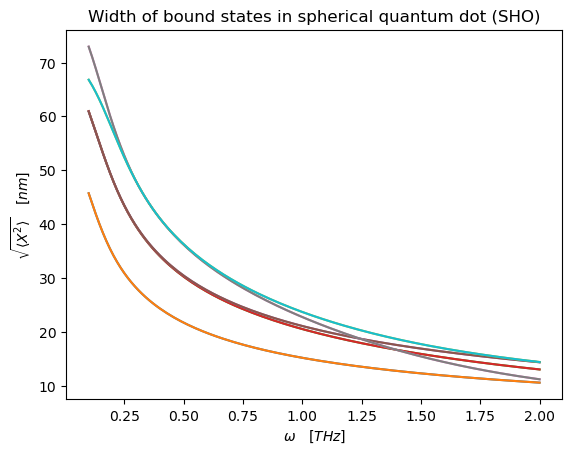

In [19]:
plt.plot(omega_range/1e12,results)
plt.xlabel(r'$\omega \quad [THz]$')
plt.ylabel(r'$\sqrt{\langle X^2 \rangle} \quad [nm]$')
plt.title('Width of bound states in spherical quantum dot (SHO)')

## Magnetic Field Sweep

In [30]:
OMEGA_Y_VAL = 2.5e11 # around 35*2=70 nm in diameter


B_field_magnitudes = np.linspace(1,2,8)
Lx_values =  np.linspace(0.5,2,48)*OMEGA_Y_VAL
param_dict = [{'b':b,'lx':lx} for b in B_field_magnitudes for lx in Lx_values]

from nqcpfem.spin_gap import find_spin_gap

from nqcpfem.solvers import IterativeSolver
single_solver = PETScSolver(k=6,which='SM',sigma=0)
solver = IterativeSolver(single_solver) # take previous states as next guess as they will be similar

def sho_eval_b_field(lx,b):
    #make band_model and fem model
    bm = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge')
    bm.add_z_confinement(1,'box',25e-9)
    bm.add_zeeman_term()#B=[1,1,1])



    domain = RectangleDomain(Lx=300e-9,Ly=300e-9,Lz=0)  #Ly does not need the same size but has same resolution
    domain.resolution = [150,150]
    fem_model = FEniCsModel(bm,domain,0,('CG',1))


    x,y,z = bm.position_symbols
    omega_x,omega_y = sympy.symbols(r'\omega_x,\omega_y')
    m = sympy.symbols('m')

    V = 0.5*m*( (omega_x*x)**2 + (omega_y*y)**2 ) 

    bm.add_potential(V)

    bm.material_spec('Ge')

    E0 = 1/(nqcpfem.UNIT_CONVENTION['J to eV']*1000000) # unit_scale: 1muev


    fem_model.band_model.parameter_dict[omega_y] = OMEGA_Y_VAL

    fem_model.band_model.parameter_dict[omega_x] = lx


    for bname in _B_:
    
        bm.function_dict[bname] = SymbolicFunction(sympy.sympify(0),bname)
    
    fem_model.band_model.function_dict[_B_[0]]= SymbolicFunction(sympy.sympify(b),_B_[0])
    fem_model.band_model.function_dict[_B_[1]]= SymbolicFunction(sympy.sympify(0),_B_[1])
    #compute Bx energies
    
    
    Bx_energies = find_spin_gap(solver.solve(fem_model),fem_model)
    
    
    LOG.info(Bx_energies[0])


    # extract only the numbers that we care about
    sq_vals = []
    last_E = -np.inf
    for eval,evec in zip(*solution):
        if not np.isclose(eval,last_E,rtol=1e-3,atol=0):
            # compute expectation value of X^2
            sq_vals.append(np.sqrt(fenics_xsq_op.mel(evec))*1e9)
            last_E = eval/E0
        else:
            pass
    print(sq_vals)



    
    #compute By energies
    fem_model.band_model.function_dict[_B_[0]]= SymbolicFunction(sympy.sympify(0),_B_[0])
    fem_model.band_model.function_dict[_B_[1]]= SymbolicFunction(sympy.sympify(b),_B_[1])
    By_energies = find_spin_gap(solver.solve(fem_model),fem_model)
    LOG.info(By_energies[0])
    
    fem_model.band_model.function_dict[_B_[1]]= SymbolicFunction(sympy.sympify(0),_B_[1])
    
    del fem_model
    
    return_val = (Bx_energies[0],By_energies[0]) #only return the eigenvalues and drop eigenvectors
    print(return_val)
    return return_val
    
from nqcpfem.parameter_search import ParameterSearch,DBMPParameterSearch
sho_save = 'sho_fem_b_field2.save'

#Lx_values = np.linspace(50e-9,200e-9,64)

sho_search  = None 

if os.path.exists(sho_save):
    try:
        sho_search = ParameterSearch.load(sho_save)
    except Exception as err:
        print(err)
#sho_search=None
#sho_search = None
if sho_search is None:
    sho_search = DBMPParameterSearch(parameter_sets = param_dict,evaluation_function=sho_eval_b_field,save_file=sho_save)

In [31]:

LOG.setLevel(logging.INFO)
sho_search.run(2,True,True)

res = np.stack([s[:6] for s in sho_search.results])
np.save('results_b.save',res)


INFO:nqcpfem.parameter_search:running database MP parametersearch with 384 points and 2 workers


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [203.8542749960066, 10510.27744393086, 10625.055967436892, 10653.51992503375, 10831.06162932531, 12699.825454542814, 12722.407916993612]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 203.8542749960066
INFO:root:(1.057077150942253e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [208.52032605473178, 10484.73096770548, 10366.435227906286, 10816.761875519613, 11007.372877412678]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 208.52032605473178
INFO:root:(2.5857228335445757e-24+0j)


((1.057077150942253e-24+0j), (2.5857228335445757e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [206.86353581811633, 10563.332620815061, 10688.889433081491, 10651.643050605337, 10829.280811587521]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 206.86353581811633
INFO:root:(1.0950761409610225e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [211.36454376847257, 10545.73464431367, 10414.163017442785, 10814.705166916801, 11005.776700510187]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 211.36454376847257
INFO:root:(2.5464985809798663e-24+0j)


((1.0950761409610225e-24+0j), (2.5464985809798663e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [209.53615362351502, 10610.298717445425, 10741.685710002183, 10649.313414377597, 10827.041272368855]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 209.53615362351502
INFO:root:(1.1355599291220021e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [213.83835027291434, 10590.947021222119, 10454.824941165072, 10812.066512153924, 11003.789220905699]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 213.83835027291434
INFO:root:(2.5047378377644247e-24+0j)


((1.1355599291220021e-24+0j), (2.5047378377644247e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [211.8786563745494, 10648.392885248468, 10788.115555252687, 10646.39693421175, 10824.178484616159]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 211.8786563745494
INFO:root:(1.1782131603957467e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [215.96942624862942, 10636.55264701211, 10488.790937937385, 10808.640453654778, 11001.286661158096]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 215.96942624862942
INFO:root:(2.4607698187483463e-24+0j)


((1.1782131603957467e-24+0j), (2.4607698187483463e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [213.90790993505743, 10672.620373832695, 10819.546378174664, 10642.698150647107, 10820.445795360625]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 213.90790993505743
INFO:root:(1.2227336519335285e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [217.75780873710713, 10547.336324973401, 10656.24423093282, 10804.115145218373, 10998.091448380388]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 217.75780873710713
INFO:root:(2.4149104780769746e-24+0j)


((1.2227336519335285e-24+0j), (2.4149104780769746e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [215.66363691656554, 10697.967099884076, 10848.425164135617, 10637.924536625836, 10815.46348921847]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 215.66363691656554
INFO:root:(1.2688420951906115e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [219.25302682591234, 10528.849141760174, 10691.905506123949, 10798.005228434953, 10993.938249874023]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 219.25302682591234
INFO:root:(2.367452353275274e-24+0j)


((1.2688420951906115e-24+0j), (2.367452353275274e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [217.17307076163596, 10707.586782566155, 10866.102842333281, 10631.617804457292, 10808.62627472563]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 217.17307076163596
INFO:root:(1.3162878241702243e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [220.47889234125205, 10534.241026090114, 10711.95423364584, 10789.530881523535, 10988.420345267456]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 220.47889234125205
INFO:root:(2.3186584615965737e-24+0j)


((1.3162878241702243e-24+0j), (2.3186584615965737e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [218.47777649050607, 10712.727493247476, 10871.26396532097, 10623.039262084449, 10798.927475217504]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 218.47777649050607
INFO:root:(1.364851343811098e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [221.48550724802197, 10531.653563905153, 10716.387931449446, 10777.387805746088, 10980.875698388063]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 221.48550724802197
INFO:root:(2.2687595513745666e-24+0j)


((1.364851343811098e-24+0j), (2.2687595513745666e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [219.61393208640666, 10712.386291198578, 10872.704259539689, 10610.971837886444, 10784.603941490286]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 219.61393208640666
INFO:root:(1.4143444104679225e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [222.3032609564797, 10523.167837803692, 10721.624784086933, 10759.281839128242, 10970.219327148085]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 222.3032609564797
INFO:root:(2.2179539031444284e-24+0j)


((1.4143444104679225e-24+0j), (2.2179539031444284e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [220.611637243937, 10693.69586818573, 10857.17965648177, 10593.30493489021, 10762.368579014079]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 220.611637243937
INFO:root:(1.4646084240510828e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [222.97220847287332, 10492.879013605187, 10715.457349431083, 10730.916509720873, 10954.536254934823]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 222.97220847287332
INFO:root:(2.1664089023104733e-24+0j)


((1.4646084240510828e-24+0j), (2.1664089023104733e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [221.49398745316202, 10666.979550577757, 10817.633068510828, 10566.139616646338, 10725.588028014872]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 221.49398745316202
INFO:root:(1.5155117838917662e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [223.51888206370194, 10440.112635385098, 10688.758084839727, 10683.710987476714, 10930.265487701403]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 223.51888206370194
INFO:root:(2.11426371113368e-24+0j)


((1.5155117838917662e-24+0j), (2.11426371113368e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [222.2838014446096, 10619.60830453094, 10750.062312072021, 10521.747110495622, 10659.580468290547]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 222.2838014446096
INFO:root:(1.566946721984161e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [223.9718213287982, 10348.592140709825, 10650.92052709196, 10599.413560066754, 10890.214678785931]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 223.9718213287982
INFO:root:(2.0616325072871843e-24+0j)


((1.566946721984161e-24+0j), (2.0616325072871843e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [223.00934062532036, 10523.790213077975, 10605.635569219874, 10443.296054422804, 10527.842674869155]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 223.00934062532036
INFO:root:(1.6188259880701337e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [224.34748072209305, 10159.47680971756, 10574.968465649892, 10431.080533800714, 10818.332644943346]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 224.34748072209305
INFO:root:(2.0086078980328817e-24+0j)


((1.6188259880701337e-24+0j), (2.0086078980328817e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [223.68546401457687, 10342.042555641483, 10265.11000003614, 10289.865509452839, 10223.437396740746]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 223.68546401457687
INFO:root:(1.6710796382635193e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [224.67034931458392, 9743.305234121344, 10413.288427507565, 10046.029491451303, 10672.530029119407]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 224.67034931458392
INFO:root:(1.9552642450819034e-24+0j)


((1.6710796382635193e-24+0j), (1.9552642450819034e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [224.31869670263455, 9956.421236222548, 9415.263883191314, 9950.546144922615, 9460.067571060548]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 224.31869670263455
INFO:root:(1.723652079973273e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [224.94922160178885, 8845.00316927065, 10049.509194176966, 9154.866437550543, 10330.112022232877]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 224.94922160178885
INFO:root:(1.9016607373803892e-24+0j)


((1.723652079973273e-24+0j), (1.9016607373803892e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [224.8789917816691, 9096.009761558878, 8217.079372113614, 9187.444221282673, 8369.072487033392]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 224.8789917816691
INFO:root:(1.7764994517491316e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [225.17222250224546, 7992.599272653869, 9180.395346522084, 8219.719043831472, 9462.199560042984]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 225.17222250224546
INFO:root:(1.8478441261794015e-24+0j)


((1.7764994517491316e-24+0j), (1.8478441261794015e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [225.48747870201356, 8055.197968949497, 8751.750784693622, 8253.566044276144, 9007.802028306363]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 225.48747870201356
INFO:root:(1.8295873647983e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [225.3270454642265, 8680.318170316315, 8162.457662461363, 8815.163010656517, 8348.383957250226]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 225.3270454642265
INFO:root:(1.7938510910662868e-24+0j)


((1.8295873647983e-24+0j), (1.7938510910662868e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [226.06203701788527, 8422.336703732444, 9776.71934085406, 8712.946908879083, 10067.711775322603]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 226.06203701788527
INFO:root:(1.8828889991570562e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [225.53297758178337, 9667.18518896611, 8930.334700413081, 9696.500343157993, 9014.500567785986]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 225.53297758178337
INFO:root:(1.7397102413392586e-24+0j)


((1.8828889991570562e-24+0j), (1.7397102413392586e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [226.59667002039043, 9382.689615952251, 10264.82759987238, 9705.2295852765, 10525.230331858213]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 226.59667002039043
INFO:root:(1.9363835275610313e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [225.7203754143947, 10166.885565790002, 9972.616654658223, 10129.26382418896, 9961.05884784124]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 225.7203754143947
INFO:root:(1.685443778467774e-24+0j)


((1.9363835275610313e-24+0j), (1.685443778467774e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [227.11380441027126, 9931.323241696624, 10481.031307537261, 10221.735213704089, 10726.563888917859]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 227.11380441027126
INFO:root:(1.990054829936906e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [225.85689691889382, 10399.923823459361, 10447.18240532648, 10331.975564740278, 10374.311213553618]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 225.85689691889382
INFO:root:(1.631068856515374e-24+0j)


((1.990054829936906e-24+0j), (1.631068856515374e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [227.62761731870233, 10192.85355808104, 10590.667233121854, 10458.977074408163, 10824.825088394904]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 227.62761731870233
INFO:root:(2.0438904579981164e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [226.0034438555837, 10522.962186576808, 10656.691598644637, 10434.685364977038, 10561.502549500787]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 226.0034438555837
INFO:root:(1.5765986815085494e-24+0j)


((2.0438904579981164e-24+0j), (1.5765986815085494e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [228.13959769440785, 10329.320100654331, 10653.192338638506, 10572.694513315333, 10875.259318659962]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 228.13959769440785
INFO:root:(2.0978808101169394e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [226.1492798025763, 10595.605917846357, 10763.122633782366, 10488.221190945309, 10650.662609689065]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 226.1492798025763
INFO:root:(1.5220433904263723e-24+0j)


((2.0978808101169394e-24+0j), (1.5220433904263723e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [228.6512891090255, 10408.4597137166, 10692.105518531707, 10638.803607544738, 10901.216790352088]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 228.6512891090255
INFO:root:(2.1520184797729877e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [226.27707633778704, 10641.781995119483, 10824.39648231589, 10520.233770179228, 10694.812838109763]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 226.27707633778704
INFO:root:(1.4674107475875168e-24+0j)


((2.1520184797729877e-24+0j), (1.4674107475875168e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [229.16027111395752, 10458.276598081504, 10717.985880831478, 10684.693755519624, 10924.78741622429]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 229.16027111395752
INFO:root:(2.20629774511717e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [226.41138803975136, 10672.909276019729, 10862.794738178869, 10548.723243782295, 10722.525407301719]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 226.41138803975136
INFO:root:(1.4127066920204266e-24+0j)


((2.20629774511717e-24+0j), (1.4127066920204266e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [229.6664659617729, 10491.645103913976, 10736.091456716982, 10712.007504578394, 10941.809723602439]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 229.6664659617729
INFO:root:(2.2607141718601703e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [226.54031665923637, 10694.912843911397, 10888.4230107295, 10565.719271811677, 10747.873973555934]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 226.54031665923637
INFO:root:(1.3579357647377376e-24+0j)


((2.2607141718601703e-24+0j), (1.3579357647377376e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [230.1700608296242, 10515.08452441547, 10749.271191547166, 10726.958153071786, 10952.272141603728]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 230.1700608296242
INFO:root:(2.3152643061911943e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [226.66927224140738, 10711.05538684604, 10906.365808764638, 10574.259895225227, 10763.24752271135]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 226.66927224140738
INFO:root:(1.3031014402523925e-24+0j)


((2.3152643061911943e-24+0j), (1.3031014402523925e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [230.67296183664453, 10532.166090721737, 10759.168790366797, 10732.961343108975, 10957.093246849949]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 230.67296183664453
INFO:root:(2.3699454385942588e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [226.79810566243182, 10723.253587897785, 10919.403915291705, 10576.232264214002, 10771.105706778579]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 226.79810566243182
INFO:root:(1.2482063824239859e-24+0j)


((2.3699454385942588e-24+0j), (1.2482063824239859e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [231.17413106736896, 10544.981168607315, 10766.78814351178, 10734.629829243073, 10957.027460509122]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 231.17413106736896
INFO:root:(2.4247554230558438e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [226.92459336754246, 10732.694275711949, 10929.164200498442, 10573.547204428081, 10772.993433565121]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 226.92459336754246
INFO:root:(1.1932526409748066e-24+0j)


((2.4247554230558438e-24+0j), (1.1932526409748066e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [231.67500280318757, 10554.820146301197, 10772.77366061447, 10745.45703991873, 10958.380696124688]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 231.67500280318757
INFO:root:(2.4796925392629125e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [227.04923088755908, 10740.145279497572, 10936.636843810154, 10580.775361717944, 10769.904235068234]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 227.04923088755908
INFO:root:(1.1382418018051906e-24+0j)


((2.4796925392629125e-24+0j), (1.1382418018051906e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [232.17481160477973, 10562.51502863175, 10777.554793834375, 10753.636529184998, 10963.551714327072]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 232.17481160477973
INFO:root:(2.5347553879616268e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [227.17550182723227, 10746.121854259027, 10942.46873828367, 10587.89617894285, 10773.45236530816]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 227.17550182723227
INFO:root:(1.0831751015552254e-24+0j)


((2.5347553879616268e-24+0j), (1.0831751015552254e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [232.67604050848533, 10568.623656373578, 10781.427226466121, 10758.00163159828, 10967.80449263863]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 232.67604050848533
INFO:root:(2.5899428117734142e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [227.30168809445195, 10750.980493022038, 10947.094643846078, 10591.326106802664, 10779.541997126034]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 227.30168809445195
INFO:root:(1.0280535146368471e-24+0j)


((2.5899428117734142e-24+0j), (1.0280535146368471e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [233.17302488583573, 10573.531652282352, 10784.599685630996, 10758.73665557268, 10970.116264678683]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 233.17302488583573
INFO:root:(2.6452538354540887e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [227.42494192434515, 10754.974752115173, 10950.799704805391, 10591.382241010653, 10783.445409474467]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 227.42494192434515
INFO:root:(9.72877819189042e-25+0j)


((2.6452538354540887e-24+0j), (9.72877819189042e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [233.674848630393, 10577.512908544119, 10787.22385116709, 10756.11653008183, 10970.118925625631]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 233.674848630393
INFO:root:(2.7006876209419118e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [227.54936380778614, 10758.289179678737, 10953.80358382739, 10588.319621901936, 10784.579216860584]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 227.54936380778614
INFO:root:(9.176486469788977e-25+0j)


((2.7006876209419118e-24+0j), (9.176486469788977e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [234.1743402104345, 10580.766461590458, 10789.412102297663, 10750.390046162142, 10967.71894416804]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 234.1743402104345
INFO:root:(2.756243433623914e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [227.67452579479627, 10761.06073850222, 10956.253205118375, 10582.349683285964, 10782.916773128503]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 227.67452579479627
INFO:root:(8.623665211397687e-25+0j)


((2.756243433623914e-24+0j), (8.623665211397687e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [234.6744200144992, 10583.439878337364, 10791.24753510481, 10745.919119967628, 10962.895621569742]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 234.6744200144992
INFO:root:(2.8119206170680327e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [227.799530368752, 10763.393038949549, 10958.264742835028, 10573.652278395979, 10778.55772854122]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 227.799530368752
INFO:root:(8.070318847726517e-25+0j)


((2.8119206170680327e-24+0j), (8.070318847726517e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [235.17749567760285, 10585.644905008481, 10792.796170426203, 10749.058759941978, 10960.541891762192]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 235.17749567760285
INFO:root:(2.8677185741377138e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [227.92769016864776, 10765.36556138387, 10959.917952954245, 10574.827927975084, 10771.627153157828]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 227.92769016864776
INFO:root:(7.516451227674052e-25+0j)


((2.8677185741377138e-24+0j), (7.516451227674052e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [235.67316199390746, 10587.467290519606, 10794.1066491456, 10752.217223754107, 10962.245779187691]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 235.67316199390746
INFO:root:(2.9236367528950074e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [228.05403784410822, 10767.040560649617, 10961.28499129334, 10579.304978732982, 10769.332654201127]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 228.05403784410822
INFO:root:(6.962065787224384e-25+0j)


((2.9236367528950074e-24+0j), (6.962065787224384e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [236.17026504788294, 10588.974023330595, 10795.219172585996, 10753.852480857733, 10964.236005217208]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 236.17026504788294
INFO:root:(2.9796746361002998e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [228.1781473327292, 10768.466666654396, 10962.408809848215, 10581.514653664452, 10771.7289397416]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 228.1781473327292
INFO:root:(6.407165685138661e-25+0j)


((2.9796746361002998e-24+0j), (6.407165685138661e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [236.6694697700711, 10590.218122801774, 10796.163746767279, 10753.552543087313, 10965.499146103439]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 236.6694697700711
INFO:root:(3.0358317333911384e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [228.30323224402153, 10769.683451476718, 10963.336512879001, 10581.513510234974, 10773.92916926638]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 228.30323224402153
INFO:root:(5.851753919394856e-25+0j)


((3.0358317333911384e-24+0j), (5.851753919394856e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [237.16661266392066, 10591.242372788649, 10796.966193970093, 10751.218491269872, 10965.56751570062]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 237.16661266392066
INFO:root:(3.0921075754680488e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [228.4293643907218, 10770.7218524876, 10964.094832968967, 10579.394144487178, 10774.86888080994, 13921.251559773633]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 228.4293643907218
INFO:root:(5.295833439793537e-25+0j)


((3.0921075754680488e-24+0j), (5.295833439793537e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [237.66201176076746, 10592.082105650543, 10797.64501197862, 10746.85686444366, 10964.201133311206, 13796.145481147016, 13958.010059136486]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 237.66201176076746
INFO:root:(3.1485017097697495e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [228.55832595570695, 10771.608275882283, 10964.714368620715, 10575.242497420284, 10774.182496140571]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 228.55832595570695
INFO:root:(4.739407277581988e-25+0j)


((3.1485017097697495e-24+0j), (4.739407277581988e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [238.15690553771702, 10592.76733428918, 10798.214579183072, 10740.514408774034, 10961.289942279978]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 238.15690553771702
INFO:root:(3.205013697257188e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [228.68562222368507, 10772.363332293957, 10965.210403535883, 10569.138538140258, 10771.743790419021, 13923.418036213257, 14086.81216515254]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 228.68562222368507
INFO:root:(4.182478728052674e-25+0j)


((3.205013697257188e-24+0j), (4.182478728052674e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [238.65183070779312, 10593.32593432679, 10798.685999598712, 10732.252223700169, 10956.775131886794, 13797.56478620419, 13960.136891574592]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 238.65183070779312
INFO:root:(3.26164311002597e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [228.8134970371155, 10773.004404512734, 10965.599689639957, 10561.157220554209, 10767.52980886941, 13924.265365104688, 14087.95882451193]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 228.8134970371155
INFO:root:(3.625051659894802e-25+0j)


((3.26164311002597e-24+0j), (3.625051659894802e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [239.14487150182603, 10593.787013568959, 10799.06092352408, 10728.883023359675, 10950.639067969674, 13798.052256670984, 13960.993442107861]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 239.14487150182603
INFO:root:(3.318389529519703e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [228.94399132388384, 10773.546602911374, 10965.901779046077, 10551.39034884805, 10761.558922527147, 13924.981411266115, 14088.931397797547]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 228.94399132388384
INFO:root:(3.0671311274209283e-25+0j)


((3.318389529519703e-24+0j), (3.0671311274209283e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [239.63654712988617, 10594.191170932976, 10799.33084476685, 10729.90866447883, 10947.924972483379, 13798.416524666007, 13961.733812839124]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 239.63654712988617
INFO:root:(3.3752525452044145e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [229.07465435787736, 10774.001043015269, 10966.12484602428, 10551.238081479682, 10753.870691290474, 13925.581621275222, 14089.751024396048]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 229.07465435787736
INFO:root:(2.508724771178824e-25+0j)


((3.3752525452044145e-24+0j), (2.508724771178824e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [240.12982613181634, 10594.620378626132, 10799.452087130569, 10731.277944892263, 13798.672632036456, 10948.29471704371, 13962.373457550651]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 240.12982613181634
INFO:root:(3.432231753572672e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [229.20804199136037, 10774.376988240458, 10966.275198114, 10553.794728150258, 13926.078458773783, 10749.72137092101, 14090.433440806013]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 229.20804199136037
INFO:root:(1.9498466035717856e-25+0j)


((3.432231753572672e-24+0j), (1.9498466035717856e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [240.6349373752145, 10595.331186511783, 10799.25199218066, 10731.991150429105, 13798.833426324263, 10949.250033458015, 13962.92145011874]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 240.6349373752145
INFO:root:(3.4893267573955e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [229.3565694869653, 10774.679278577067, 10966.363573203316, 10555.57036255707, 13926.479771260561, 10750.238350358642, 14090.997106227062]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 229.3565694869653
INFO:root:(1.3905299159079184e-25+0j)


((3.4893267573955e-24+0j), (1.3905299159079184e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [241.12679320171551, 10597.666602587067, 10797.782384985878, 10731.616310441028, 13798.90980271007, 13963.390690730945, 10950.011813565083]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 241.12679320171551
INFO:root:(3.546537165157202e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [229.5650731737322, 10774.889540720964, 10966.36453584708, 13926.775664508701, 10556.02985642631, 14091.434611737657, 10751.440282555011]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 229.5650731737322
INFO:root:(8.308923726082217e-26+0j)


((3.546537165157202e-24+0j), (8.308923726082217e-26+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [232.93317827724877, 10506.847007507542, 10637.777079003143, 10627.502175751122, 10829.853002902793, 12698.86966791645, 12720.534160322119]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 232.93317827724877
INFO:root:(1.2641538576762338e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [238.37807847560816, 10477.487211849915, 10341.399979003998, 10813.09276139918, 11031.941639463344]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 238.37807847560816
INFO:root:(3.010857085662705e-24+0j)


((1.2641538576762338e-24+0j), (3.010857085662705e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [236.3768672952252, 10558.46466005092, 10701.553364386396, 10625.273221360516, 10827.614241008805]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 236.3768672952252
INFO:root:(1.307622191994987e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [241.6166536155433, 10538.238800351748, 10387.104367323576, 10810.497224215509, 11030.019894502793]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 241.6166536155433
INFO:root:(2.9660666864862316e-24+0j)


((1.307622191994987e-24+0j), (2.9660666864862316e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [239.4376352237199, 10604.81948508645, 10754.249116282786, 10622.505083177655, 10824.767627768673]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 239.4376352237199
INFO:root:(1.3539295118178949e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [244.43431305053375, 10582.63249869689, 10425.60149042575, 10807.136681647537, 11027.597408673655]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 244.43431305053375
INFO:root:(2.918381355918603e-24+0j)


((1.3539295118178949e-24+0j), (2.918381355918603e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [242.11737799342367, 10641.071121550463, 10799.861022702407, 10619.034536052473, 10821.091197774513]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 242.11737799342367
INFO:root:(1.4027151011422135e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [246.86091161554623, 10627.506344910556, 10456.800006970592, 10802.734841667767, 11024.518747120692]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 246.86091161554623
INFO:root:(2.8681769089614287e-24+0j)


((1.4027151011422135e-24+0j), (2.8681769089614287e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [244.4398021031218, 10664.106632436691, 10830.23108526263, 10614.610517274325, 10816.252632656373]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 244.4398021031218
INFO:root:(1.4536334260895702e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [248.89572398654107, 10656.067404399526, 10476.54706502012, 10796.872816704781, 11020.555674121555]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 248.89572398654107
INFO:root:(2.8158139911974416e-24+0j)


((1.4536334260895702e-24+0j), (2.8158139911974416e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [246.44886403135422, 10687.199404545088, 10857.188932850297, 10608.865177734637, 10809.739792582566]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 246.44886403135422
INFO:root:(1.5063652012880454e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [250.59801598265832, 10491.15639186876, 10680.317539028274, 10788.898981625924, 11015.367252607806]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 250.59801598265832
INFO:root:(2.761626496164306e-24+0j)


((1.5063652012880454e-24+0j), (2.761626496164306e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [248.17306064175412, 10693.775973402215, 10872.09023910889, 10601.237603382884, 10800.735215735667]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 248.17306064175412
INFO:root:(1.560623957302405e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [251.99121349092883, 10491.943775010363, 10698.534030330502, 10777.76630771159, 11008.43981293117]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 251.99121349092883
INFO:root:(2.705914607100067e-24+0j)


((1.560623957302405e-24+0j), (2.705914607100067e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [249.6668126453224, 10696.584932884329, 10873.227452336974, 10590.839700690118, 10787.878228419988]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 249.6668126453224
INFO:root:(1.6161589060300383e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [253.1368682240387, 10483.575416346339, 10700.797290610837, 10761.722336148223, 10998.939078219386]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 253.1368682240387
INFO:root:(2.648941666527497e-24+0j)


((1.6161589060300383e-24+0j), (2.648941666527497e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [250.96762655794922, 10691.656127865765, 10868.429998974461, 10576.214178723185, 10768.789417231066]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 250.96762655794922
INFO:root:(1.672755011464213e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [254.0667958951824, 10466.716712151872, 10701.546998966445, 10737.68394299653, 10985.50381567454]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 254.0667958951824
INFO:root:(2.5909339543990983e-24+0j)


((1.672755011464213e-24+0j), (2.5909339543990983e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [252.10723057913413, 10666.783775750879, 10843.630644802928, 10554.859029738833, 10739.041975637885]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 252.10723057913413
INFO:root:(1.7302311349947637e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [254.82597974604644, 10424.89697517505, 10690.604734152994, 10699.940277626793, 10965.765269556377]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 254.82597974604644
INFO:root:(2.5320824866488787e-24+0j)


((1.7302311349947637e-24+0j), (2.5320824866488787e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [253.1153986784607, 10633.32015374491, 10788.538039528543, 10522.23696288199, 10689.797355496203]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 253.1153986784607
INFO:root:(1.788437000669966e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [255.44583242478996, 10352.588523528333, 10656.673823392157, 10637.698337124302, 10935.363652117921]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 255.44583242478996
INFO:root:(2.47254606716473e-24+0j)


((1.788437000669966e-24+0j), (2.47254606716473e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [254.01846926318478, 10573.915778609005, 10694.31702840819, 10469.54706398458, 10601.93524239763]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 254.01846926318478
INFO:root:(1.8472495670788325e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [255.96011146064674, 10228.814393626737, 10606.038295230293, 10526.420453382298, 10885.680701430687]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 255.96011146064674
INFO:root:(2.4124549854185668e-24+0j)


((1.8472495670788325e-24+0j), (2.4124549854185668e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [254.84919073577538, 10461.1546714525, 10501.134183895216, 10378.25685464446, 10428.74613047659]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 254.84919073577538
INFO:root:(1.9065692331808198e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [256.3879972303879, 9982.420944204405, 10511.663573727985, 10306.136923369932, 10797.925457553123]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 256.3879972303879
INFO:root:(2.3519149138617635e-24+0j)


((1.9065692331808198e-24+0j), (2.3519149138617635e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [255.6246527972781, 10255.285940186184, 10068.280641126412, 10205.693488025256, 10046.863145223791]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 255.6246527972781
INFO:root:(1.9663161650005214e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [256.7533369224132, 9470.338492015784, 10320.526905726165, 9824.756919430607, 10624.84471366786]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 256.7533369224132
INFO:root:(2.291010702907103e-24+0j)


((1.9663161650005214e-24+0j), (2.291010702907103e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [256.34535219565294, 9842.827960378829, 9135.514100161921, 9847.328297954917, 9217.166932676757]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 256.34535219565294
INFO:root:(2.0264269170867864e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [257.06920858683, 8556.877759793879, 9916.086933889359, 8892.994515653703, 10242.120206633943]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 257.06920858683
INFO:root:(2.2298098879655795e-24+0j)


((2.0264269170867864e-24+0j), (2.2298098879655795e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [256.9842944159629, 9018.72099481465, 8169.929797813082, 9126.577070558787, 8357.467755666208]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 256.9842944159629
INFO:root:(2.0868514379991652e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [257.3219590741382, 7965.699424710633, 9070.68587732528, 8209.88004472484, 9390.847787186034]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 257.3219590741382
INFO:root:(2.1683658108823086e-24+0j)


((2.0868514379991652e-24+0j), (2.1683658108823086e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [257.681290443173, 8071.126156981544, 8694.608102051177, 8287.109950885102, 8987.1202961042]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 257.681290443173
INFO:root:(2.147550489920639e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [257.4976736185073, 8646.82940359877, 8171.467953800955, 8798.503308029209, 8394.55977033133]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 257.4976736185073
INFO:root:(2.1067203201354496e-24+0j)


((2.147550489920639e-24+0j), (2.1067203201354496e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [258.3393012397693, 8216.607470826002, 9631.90233606269, 8524.66417038322, 9966.264399456884]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 258.3393012397693
INFO:root:(2.2084934740367986e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [257.7311257914871, 9548.802223346514, 8701.168775030064, 9593.756205421469, 8822.806207400921]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 257.7311257914871
INFO:root:(2.0449060548223864e-24+0j)


((2.2084934740367986e-24+0j), (2.0449060548223864e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [258.95093345219107, 9081.72604153753, 10145.914233533322, 9445.587471074157, 10457.043632677834]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 258.95093345219107
INFO:root:(2.26965663061457e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [257.9464109299732, 10060.453671730333, 9724.66191911342, 10032.13322125637, 9743.645125914072]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 257.9464109299732
INFO:root:(1.982948341866797e-24+0j)


((2.26965663061457e-24+0j), (1.982948341866797e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [259.54382090199005, 9701.693458089792, 10395.785156245722, 10047.0739160693, 10686.682706377287]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 259.54382090199005
INFO:root:(2.33102157125561e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [258.1035601939749, 10317.39892326536, 10296.496750612141, 10250.911266856756, 10239.148611020642]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 258.1035601939749
INFO:root:(1.9208667485260166e-24+0j)


((2.33102157125561e-24+0j), (1.9208667485260166e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [260.13168772607474, 10030.873600254385, 10527.879762436776, 10349.14057471106, 10805.313769745975]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 260.13168772607474
INFO:root:(2.39257409690909e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [258.2687048652692, 10458.493142952168, 10568.256871465908, 10368.485297574063, 10475.782754508793]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 258.2687048652692
INFO:root:(1.858676336985342e-24+0j)


((2.39257409690909e-24+0j), (1.858676336985342e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [260.71860100694096, 10207.872933690034, 10605.125503706575, 10499.9495160319, 10868.532697528535]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 260.71860100694096
INFO:root:(2.4543032560754962e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [258.43572387958744, 10543.722082305849, 10709.315638738859, 10432.524193314772, 10594.786412550611]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 258.43572387958744
INFO:root:(1.7963886674588027e-24+0j)


((2.4543032560754962e-24+0j), (1.7963886674588027e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [261.3035526290958, 10311.62308349026, 10653.979453830827, 10586.260804497482, 10902.293097890863]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 261.3035526290958
INFO:root:(2.5162006012323486e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [258.5804272667534, 10599.179212530491, 10791.154880301629, 10470.845061526834, 10656.56713965071]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 258.5804272667534
INFO:root:(1.7340125928999833e-24+0j)


((2.5162006012323486e-24+0j), (1.7340125928999833e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [261.88523732980593, 10377.226872757548, 10686.828745837158, 10645.569520885425, 10931.170544778424]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 261.88523732980593
INFO:root:(2.5782596063792902e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [258.7324368733353, 10637.053773467045, 10842.711284120878, 10503.860790933744, 10692.801197597659]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 258.7324368733353
INFO:root:(1.671554883661038e-24+0j)


((2.5782596063792902e-24+0j), (1.671554883661038e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [262.4637440082716, 10421.263050596073, 10710.006140179536, 10681.5307289905, 10952.456828516619]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 262.4637440082716
INFO:root:(2.6404752139513125e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [258.88066874415114, 10664.085993037397, 10877.24387093737, 10524.330852842711, 10725.699426735593]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 258.88066874415114
INFO:root:(1.6090207150927325e-24+0j)


((2.6404752139513125e-24+0j), (1.6090207150927325e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [263.0396052958287, 10452.238605164333, 10726.993129860404, 10702.280467654919, 10966.13324460598]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 263.0396052958287
INFO:root:(2.7028434844882426e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [259.0266922372617, 10684.07761137351, 10901.501165919613, 10535.46577366567, 10746.300426923217]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 259.0266922372617
INFO:root:(1.5464140458592433e-24+0j)


((2.7028434844882426e-24+0j), (1.5464140458592433e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [263.6151238875108, 10474.845180641927, 10739.833464556335, 10712.295201749406, 10973.446670294963]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 263.6151238875108
INFO:root:(2.7653613272162343e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [259.1732890583475, 10699.291566648197, 10919.193126528065, 10539.59463994211, 10758.005271320231]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 259.1732890583475
INFO:root:(1.483737909896914e-24+0j)


((2.7653613272162343e-24+0j), (1.483737909896914e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [264.1876277396859, 10491.838582548025, 10749.784673385093, 10717.568432369095, 10975.375750524016]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 264.1876277396859
INFO:root:(2.8280262938344616e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [259.31715816873043, 10711.143502752288, 10932.472922498273, 10539.450676692853, 10762.833624773122]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 259.31715816873043
INFO:root:(1.4209946406557881e-24+0j)


((2.8280262938344616e-24+0j), (1.4209946406557881e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [264.76193385514773, 10504.92344375393, 10757.654136612327, 10731.772574887484, 10977.885790136646]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 264.76193385514773
INFO:root:(2.8908364213502076e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [259.45961690503526, 10720.556530671036, 10942.69743212839, 10547.764760690367, 10762.066280211486]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 259.45961690503526
INFO:root:(1.3581860426134519e-24+0j)


((2.8908364213502076e-24+0j), (1.3581860426134519e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [265.33402803692854, 10515.192740804423, 10763.982958439501, 10741.79003181429, 10984.160261746574]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 265.33402803692854
INFO:root:(2.9537901127472855e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [259.6039372250679, 10728.15406935587, 10950.712700775679, 10555.622545755741, 10765.243496122665]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 259.6039372250679
INFO:root:(1.295313521968564e-24+0j)


((2.9537901127472855e-24+0j), (1.295313521968564e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [265.90796538262924, 10523.382931587237, 10769.145457349194, 10747.367986785885, 10989.39323936529]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 265.90796538262924
INFO:root:(3.0168860466932148e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [259.74789004003117, 10734.37009534617, 10957.105322956104, 10559.598770209079, 10772.835037718882]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 259.74789004003117
INFO:root:(1.2323781859108842e-24+0j)


((3.0168860466932148e-24+0j), (1.2323781859108842e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [266.4769825150394, 10530.000969494124, 10773.407572428347, 10748.953026777888, 10992.56707131544]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 266.4769825150394
INFO:root:(3.0801231094205456e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [259.8882199208752, 10739.514491822472, 10962.273604315167, 10560.055184721648, 10778.100662153529]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 259.8882199208752
INFO:root:(1.1693809178233824e-24+0j)


((3.0801231094205456e-24+0j), (1.1693809178233824e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [267.0514006285852, 10535.405611053886, 10776.96213418503, 10746.933801813853, 10993.360498434015]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 267.0514006285852
INFO:root:(3.143500343480948e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [260.03072892187066, 10743.813570133945, 10966.490209314929, 10557.280626641746, 10780.39232993772]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 260.03072892187066
INFO:root:(1.1063224341314034e-24+0j)


((3.143500343480948e-24+0j), (1.1063224341314034e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [267.6230798184405, 10539.857986116758, 10779.952099095784, 10741.623438871648, 10991.669220850279]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 267.6230798184405
INFO:root:(3.207016909288208e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [260.1752955570343, 10747.436057300569, 10969.9690623549, 10551.518644358797, 10779.72897287297]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 260.1752955570343
INFO:root:(1.0432033272428167e-24+0j)


((3.207016909288208e-24+0j), (1.0432033272428167e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [268.19387645541434, 10543.552424561285, 10782.486668924023, 10738.66576741657, 10987.505945543098]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 268.19387645541434
INFO:root:(3.2706720563166423e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [260.31815728917826, 10750.509815921163, 10972.85390794942, 10543.132275943244, 10776.249430855074]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 260.31815728917826
INFO:root:(9.800240980056725e-25+0j)


((3.2706720563166423e-24+0j), (9.800240980056725e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [268.7696384583917, 10546.63491079901, 10784.64667308108, 10742.82424672817, 10985.544687981797]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 268.7696384583917
INFO:root:(3.334465101576668e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [260.46536557923577, 10753.133419265603, 10975.264744457061, 10546.281066868994, 10770.107796330269]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 260.46536557923577
INFO:root:(9.167851803422375e-25+0j)


((3.334465101576668e-24+0j), (9.167851803422375e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [269.33662231705904, 10549.218247195027, 10786.499140362062, 10746.497523649747, 10987.591219495256]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 269.33662231705904
INFO:root:(3.398395413554351e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [260.60916402694977, 10755.383713988127, 10977.286234711737, 10550.822008072271, 10766.671465847856]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 260.60916402694977
INFO:root:(8.53486960145584e-25+0j)


((3.398395413554351e-24+0j), (8.53486960145584e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [269.90526886494234, 10551.390044289257, 10788.091666022698, 10748.385375409938, 10989.908526828676]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 269.90526886494234
INFO:root:(3.462462400241396e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [260.7513100808465, 10757.321809076726, 10978.98724523316, 10553.01243956548, 10769.30516289773]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 260.7513100808465
INFO:root:(7.901297901142344e-25+0j)


((3.462462400241396e-24+0j), (7.901297901142344e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [270.47515797545367, 10553.222144968713, 10789.466376002116, 10748.185692914876, 10991.498647391516]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 270.47515797545367
INFO:root:(3.52666550023167e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [260.89389796729546, 10758.99609068382, 10980.417099644099, 10552.960664294873, 10771.98471641282]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 260.89389796729546
INFO:root:(7.267140019581183e-25+0j)


((3.52666550023167e-24+0j), (7.267140019581183e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [271.0438933637402, 10554.770085936574, 10790.652789704647, 10745.854503132949, 10991.893844484299]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 271.0438933637402
INFO:root:(3.591004176095079e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [261.0386484286358, 10760.446226162554, 10981.624371305097, 10550.765138938103, 10773.444504464138]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 261.0386484286358
INFO:root:(6.632399173701668e-25+0j)


((3.591004176095079e-24+0j), (6.632399173701668e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [271.61021055114634, 10556.082953855273, 10791.677695501143, 10741.428736497992, 10990.862248837493]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 271.61021055114634
INFO:root:(3.6554779094529094e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [261.1863990976656, 10761.70418749984, 10982.639681656527, 10546.51617943155, 10773.265844412792, 13908.824431033778]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 261.1863990976656
INFO:root:(5.997078593769798e-25+0j)


((3.6554779094529094e-24+0j), (5.997078593769798e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [272.17619215595164, 10557.203878841174, 10792.555571319266, 10734.973004597245, 10988.28417147178, 13766.154425820714, 13950.010836863788]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 272.17619215595164
INFO:root:(3.720086197321849e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [261.33267272990497, 10762.796256200632, 10983.493664350628, 10540.297427278507, 10771.313454986948, 13910.17712363115, 14094.223256632169]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 261.33267272990497
INFO:root:(5.3611816647739e-25+0j)


((3.720086197321849e-24+0j), (5.3611816647739e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [272.74358671279975, 10558.179658215862, 10793.298364696711, 10726.559095221028, 10984.109196099744, 13767.123671146746, 13951.48779722235]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 272.74358671279975
INFO:root:(3.784828549388909e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [261.47710068523406, 10763.744890251703, 10984.211015808114, 10532.186782615485, 10767.562732167544, 13911.349581559434, 14095.998624472611]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 261.47710068523406
INFO:root:(4.724712139021717e-25+0j)


((3.784828549388909e-24+0j), (4.724712139021717e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [273.3093470737374, 10559.06763597019, 10793.898956722383, 10724.702973210227, 10978.313497945128, 13767.917493250288, 13952.800078744174]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 273.3093470737374
INFO:root:(3.849704485986944e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [261.6255684425955, 10764.567705612239, 10984.802208554662, 10522.268684378507, 10762.035841017132, 13912.363837646539, 14097.537428886777]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 261.6255684425955
INFO:root:(4.087674512368188e-25+0j)


((3.849704485986944e-24+0j), (4.087674512368188e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [273.8689844936161, 10559.981591323885, 10794.315396041331, 10726.16481555908, 10975.814148790174, 13768.557908775205, 13953.961087821956]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 273.8689844936161
INFO:root:(3.914713536583996e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [261.77281328656045, 10765.28022325764, 10985.28387026892, 10523.260442412684, 10754.772821810206, 13913.238575083606, 14098.86581000133]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 261.77281328656045
INFO:root:(3.4500747883131077e-25+0j)


((3.914713536583996e-24+0j), (3.4500747883131077e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [274.4344526159546, 10561.236574621778, 10794.373271494933, 10727.712228859935, 13769.063537781381, 10976.332878165807, 13954.986295039405]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 274.4344526159546
INFO:root:(3.979855238651157e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [261.91981334849123, 10765.895100276812, 10985.678580205966, 10526.37036327896, 13913.989352642473, 10749.407538409921, 14100.015827586552]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 261.91981334849123
INFO:root:(2.811922258663479e-25+0j)


((3.979855238651157e-24+0j), (2.811922258663479e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [275.01214355905756, 10564.34416088242, 10793.101028749616, 10728.445666782347, 13769.450248202593, 13955.889964380414, 10977.428468267462]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 275.01214355905756
INFO:root:(4.0451291368124465e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [262.07932270927637, 10766.421378882462, 10985.990263711064, 10528.224466193202, 13914.628596562985, 10749.725417816178, 14101.00264322623]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 262.07932270927637
INFO:root:(2.1732344057559093e-25+0j)


((4.0451291368124465e-24+0j), (2.1732344057559093e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [275.57399626436523, 10587.99768804482, 10776.253814576206, 10728.005249394178, 13769.731576056678, 13956.689964646675, 10978.355840513072]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 275.57399626436523
INFO:root:(4.110534782205724e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [262.24989763419165, 10766.862784539486, 10986.219021786814, 13915.163325068386, 10528.56007733547, 14101.84915983188, 10751.025735739948]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 262.24989763419165
INFO:root:(1.5340540536545776e-25+0j)


((4.110534782205724e-24+0j), (1.5340540536545776e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [261.9941614054428, 10502.854659292147, 10649.725431997922, 10601.515319194958, 10828.34233720881, 12697.486990820955, 12716.501722385754]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 261.9941614054428
INFO:root:(1.4935543310821824e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [268.2629107776214, 10469.636687738259, 10315.361407455679, 10808.96341375014, 11056.453354190053]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 268.2629107776214
INFO:root:(3.458181196272874e-24+0j)


((1.4935543310821824e-24+0j), (3.458181196272874e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [265.87492736605776, 10552.941837412773, 10713.294772235111, 10598.986651750574, 10825.569019095843]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 265.87492736605776
INFO:root:(1.5425079784713765e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [271.8910816396809, 10530.047892364808, 10358.921323967654, 10805.729690964363, 11054.171691697447]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 271.8910816396809
INFO:root:(3.407839443227539e-24+0j)


((1.5425079784713765e-24+0j), (3.407839443227539e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [269.32588589047117, 10598.623516323838, 10765.694900509412, 10595.803932882607, 10822.0136993067]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 269.32588589047117
INFO:root:(1.5946544708803552e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [275.04910924206587, 10573.600094402012, 10394.95317968457, 10801.513948702821, 11051.273550411433]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 275.04910924206587
INFO:root:(3.35424589498335e-24+0j)


((1.5946544708803552e-24+0j), (3.35424589498335e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [272.34350890691496, 10632.908123501236, 10810.259602963379, 10591.766690573944, 10817.38723125471]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 272.34350890691496
INFO:root:(1.649587611521519e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [277.7674607552253, 10617.530589679447, 10423.239515180423, 10795.95501798874, 11047.565352760872]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 277.7674607552253
INFO:root:(3.297822795592047e-24+0j)


((1.649587611521519e-24+0j), (3.297822795592047e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [274.96115089033657, 10654.711088060727, 10839.245144411798, 10586.583296755605, 10811.25623414192]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 274.96115089033657
INFO:root:(1.706918446508936e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [280.04534958559054, 10646.341440666743, 10437.687071363924, 10788.50576458137, 11042.763827075569]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 280.04534958559054
INFO:root:(3.2389753048206767e-24+0j)


((1.706918446508936e-24+0j), (3.2389753048206767e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [277.22426199539825, 10675.354048002959, 10863.881224912479, 10579.821057149635, 10802.952098161619]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 277.22426199539825
INFO:root:(1.7662876866612057e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [281.9517092022271, 10459.26880246032, 10667.915694397267, 10778.315000216486, 11036.45142848204]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 281.9517092022271
INFO:root:(3.1780784985197184e-24+0j)


((1.7662876866612057e-24+0j), (3.1780784985197184e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [279.16409729012275, 10678.722374723537, 10875.4600413907, 10570.8187753315, 10791.407195488122]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 279.16409729012275
INFO:root:(1.827373064125403e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [283.51075355709986, 10446.69280810436, 10683.703134798001, 10764.01430370073, 11027.998463681106]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 283.51075355709986
INFO:root:(3.1154695627473927e-24+0j)


((1.827373064125403e-24+0j), (3.1154695627473927e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [280.8474207059548, 10679.102236194514, 10871.80068486669, 10558.53878238472, 10774.847105159617]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 280.8474207059548
INFO:root:(1.8898925251185696e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [284.792047499269, 10431.274950552122, 10683.590817637629, 10743.312317799331, 11016.395363535405]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 284.792047499269
INFO:root:(3.0514442860217317e-24+0j)


((1.8898925251185696e-24+0j), (3.0514442860217317e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [282.31269319472125, 10669.3715198449, 10859.681482059183, 10541.292261082262, 10750.172688932447]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 282.31269319472125
INFO:root:(1.9536042825440642e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [285.8328495285223, 10404.785584042045, 10679.60502872852, 10712.207087778921, 10999.997991050133]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 285.8328495285223
INFO:root:(2.986256816714814e-24+0j)


((1.9536042825440642e-24+0j), (2.986256816714814e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [283.59401750195343, 10638.168051970148, 10823.982697909192, 10516.230286751968, 10711.656998047496]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 283.59401750195343
INFO:root:(2.018304707681319e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [286.68087905514426, 10349.376309575293, 10663.535983794929, 10663.797064822651, 10975.983725164679]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 286.68087905514426
INFO:root:(2.9201216880461317e-24+0j)


((2.018304707681319e-24+0j), (2.9201216880461317e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [284.7280045920419, 10597.97978122839, 10750.866013151595, 10478.253442594123, 10648.08797282482]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 284.7280045920419
INFO:root:(2.0838248997851552e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [287.3719716465332, 10254.804675448317, 10622.056422033475, 10583.801853447425, 10939.231539804417]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 287.3719716465332
INFO:root:(2.8532172493855838e-24+0j)


((2.0838248997851552e-24+0j), (2.8532172493855838e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [285.7470016741722, 10526.84435015194, 10626.054753056862, 10417.700321274777, 10535.451434664848]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 285.7470016741722
INFO:root:(2.1500265931084945e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [287.94570810188077, 10093.222986082215, 10558.34620573805, 10440.77534726322, 10879.827738050142]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 287.94570810188077
INFO:root:(2.7856898215850982e-24+0j)


((2.1500265931084945e-24+0j), (2.7856898215850982e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [286.68107003023954, 10398.736601095268, 10378.661483439508, 10314.958110544349, 10316.860679420317]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 286.68107003023954
INFO:root:(2.2167978812777902e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [288.424426635739, 9784.14600110402, 10446.02873598141, 10162.235428650118, 10776.519180811407]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 288.424426635739
INFO:root:(2.717658075795994e-24+0j)


((2.2167978812777902e-24+0j), (2.717658075795994e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [287.55685570749387, 10172.689684606494, 9856.866233915884, 10127.2036485474, 9865.91584011276]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 287.55685570749387
INFO:root:(2.2840490808605326e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [288.83111631807276, 9190.695561570052, 10228.286319923789, 9594.49182195301, 10578.897276167518]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 288.83111631807276
INFO:root:(2.649217296678447e-24+0j)


((2.2840490808605326e-24+0j), (2.649217296678447e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [288.36427477299833, 9744.008979330045, 8900.522126133856, 9760.826778763645, 9020.984793491336]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 288.36427477299833
INFO:root:(2.3517089288878778e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [289.1830920471938, 8326.074559319257, 9795.16960285461, 8680.178126751793, 10166.624757882273]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 289.1830920471938
INFO:root:(2.580443321797999e-24+0j)


((2.3517089288878778e-24+0j), (2.580443321797999e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [289.08133571402, 8962.04818078686, 8144.328080131757, 9085.778114742881, 8370.602128808829]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 289.08133571402
INFO:root:(2.419721214003977e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [289.4654267158761, 7960.1622713237475, 8987.447113135526, 8220.005553944171, 9344.80163727476]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 289.4654267158761
INFO:root:(2.5113960477061652e-24+0j)


((2.419721214003977e-24+0j), (2.5113960477061652e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [289.8690981337043, 8092.135882581859, 8653.053447424336, 8323.84559012353, 8983.012609792931]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 289.8690981337043
INFO:root:(2.488041874500316e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [289.66077659634936, 8625.374942222626, 8182.108048882626, 8792.957453576464, 8442.16990773933]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 289.66077659634936
INFO:root:(2.4421224627704025e-24+0j)


((2.488041874500316e-24+0j), (2.4421224627704025e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [290.6090672114467, 8069.556785031538, 9508.417739317503, 8395.472689568585, 9884.458277245263]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 290.6090672114467
INFO:root:(2.5566365533934458e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [289.9203345708198, 9451.493586286146, 8527.120332964672, 9512.266585476125, 8686.704299404988]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 289.9203345708198
INFO:root:(2.372659212463707e-24+0j)


((2.5566365533934458e-24+0j), (2.372659212463707e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.29903955790905, 8800.687872676885, 10031.603411246295, 9199.722974018554, 10393.804525025464]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.29903955790905
INFO:root:(2.625478575280906e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [290.16439477532555, 9962.565172500616, 9485.22812797425, 9944.77616303486, 9536.712621013474]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 290.16439477532555
INFO:root:(2.30303473020946e-24+0j)


((2.625478575280906e-24+0j), (2.30303473020946e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.9675406960456, 9456.589628803727, 10309.043891697193, 9859.221080987461, 10646.529113328099]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.9675406960456
INFO:root:(2.6945472969235666e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [290.3427113501314, 10237.04499430797, 10128.409380557625, 10173.705984721773, 10094.625010901405]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 290.3427113501314
INFO:root:(2.233270981075425e-24+0j)


((2.6945472969235666e-24+0j), (2.233270981075425e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.6311806030087, 9850.618824021098, 10461.998849577163, 10223.650260252667, 10784.239698083442]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.6311806030087
INFO:root:(2.763826779216028e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [290.52483614758063, 10393.700896988017, 10464.143569953158, 10303.605864195904, 10379.319749290968]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 290.52483614758063
INFO:root:(2.1633848708555637e-24+0j)


((2.763826779216028e-24+0j), (2.1633848708555637e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [293.2926088334692, 10071.962308841761, 10553.683166085699, 10415.632279796366, 10860.062024300449]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 293.2926088334692
INFO:root:(2.8333047292106718e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [290.7131416676039, 10490.432219520068, 10643.923675911965, 10376.989856242504, 10531.011279098837]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 290.7131416676039
INFO:root:(2.093389372693445e-24+0j)


((2.8333047292106718e-24+0j), (2.093389372693445e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [293.95042543424944, 10203.727839325873, 10612.641106864327, 10524.728151225803, 10902.130365563527]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 293.95042543424944
INFO:root:(2.902971664936918e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [290.87503917891695, 10554.521087561241, 10749.003726224555, 10421.581391312464, 10612.659959597198]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 290.87503917891695
INFO:root:(2.0232944196597432e-24+0j)


((2.902971664936918e-24+0j), (2.0232944196597432e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [294.6046890099819, 10287.581053151254, 10652.73698427068, 10599.720957579391, 10936.0399904838]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 294.6046890099819
INFO:root:(2.9728202612984285e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.0469715710743, 10599.071187321208, 10815.653630581177, 10458.497874944589, 10658.786520910071]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.0469715710743
INFO:root:(1.9531076063234734e-24+0j)


((2.9728202612984285e-24+0j), (1.9531076063234734e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [295.2563920091241, 10344.044781264465, 10681.265305297175, 10645.898209362924, 10961.77772486001]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 295.2563920091241
INFO:root:(3.042844841300907e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.21235734561856, 10631.174403404395, 10860.463765655457, 10482.483999942935, 10699.940301149218]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.21235734561856
INFO:root:(1.8828347363935546e-24+0j)


((3.042844841300907e-24+0j), (1.8828347363935546e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [295.9044898941982, 10383.832694520837, 10702.316571153215, 10673.553340818968, 10978.857578412291]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 295.9044898941982
INFO:root:(3.113040982728117e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.37416448061333, 10655.103343322147, 10892.023578888655, 10496.346044725642, 10726.53122510126]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.37416448061333
INFO:root:(1.812480247612905e-24+0j)


((3.113040982728117e-24+0j), (1.812480247612905e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [296.55257272493816, 10412.911678974362, 10718.31719450632, 10688.371987075572, 10988.820566635402]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 296.55257272493816
INFO:root:(3.183405215684176e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.5392020070253, 10673.436507940487, 10915.088184335693, 10502.828668970124, 10742.6361569972]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.5392020070253
INFO:root:(1.7420475396463225e-24+0j)


((3.183405215684176e-24+0j), (1.7420475396463225e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [297.1992826623163, 10434.79706181301, 10730.783259024505, 10698.39096867953, 10992.862727551552]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 297.1992826623163
INFO:root:(3.2539347911215073e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.69955784617724, 10687.804354467662, 10932.460943176215, 10505.087576436568, 10750.816060510297]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.69955784617724
INFO:root:(1.6715392259167e-24+0j)


((3.2539347911215073e-24+0j), (1.6715392259167e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [297.8451917276914, 10451.679197047777, 10740.695161073018, 10716.155331734522, 10996.618267916674]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 297.8451917276914
INFO:root:(3.324627504443056e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.85951582222236, 10699.27923196788, 10945.861976200298, 10514.229661272024, 10752.682955046814]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.85951582222236
INFO:root:(1.6009573262026303e-24+0j)


((3.324627504443056e-24+0j), (1.6009573262026303e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [298.4897895678085, 10464.958089256867, 10748.709834955293, 10728.172352401705, 11004.092181374344]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 298.4897895678085
INFO:root:(3.395481561580474e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.02160163003657, 10708.590566026747, 10956.417451748695, 10522.883828404501, 10755.68263947285]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.02160163003657
INFO:root:(1.530303413383639e-24+0j)


((3.395481561580474e-24+0j), (1.530303413383639e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [299.13808926359525, 10475.577368656051, 10755.282452102085, 10735.163349287788, 11010.394633079937]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 299.13808926359525
INFO:root:(3.466495477668293e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.1832202565146, 10716.248777995157, 10964.861426098569, 10527.463687395375, 10764.980969409766]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.1832202565146
INFO:root:(1.4595787248788373e-24+0j)


((3.466495477668293e-24+0j), (1.4595787248788373e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [299.78087228476863, 10484.186538505823, 10760.73874775501, 10737.781303660371, 11014.51390567825]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 299.78087228476863
INFO:root:(3.53766800061902e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.34036859057016, 10722.620295905295, 10971.71487758479, 10528.379876204857, 10771.792783786852]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.34036859057016
INFO:root:(1.3887842470347205e-24+0j)


((3.53766800061902e-24+0j), (1.3887842470347205e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [300.42653875774, 10491.248542437415, 10765.315691519598, 10736.517732918694, 11016.149265526203]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 300.42653875774
INFO:root:(3.608998053622558e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.5027133652847, 10727.973916152074, 10977.345342537388, 10525.97110310843, 10775.377462164242]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.5027133652847
INFO:root:(1.3179207788814424e-24+0j)


((3.608998053622558e-24+0j), (1.3179207788814424e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [301.0694390352179, 10497.097016076666, 10769.189805593205, 10731.752054307282, 11015.219532490366]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 301.0694390352179
INFO:root:(3.680484692009424e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.6665725823938, 10732.510634518689, 10982.01190835539, 10520.588546876303, 10775.817772330583]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.6665725823938
INFO:root:(1.246988980237712e-24+0j)


((3.680484692009424e-24+0j), (1.246988980237712e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [301.71071135316333, 10501.979599333466, 10772.493746738866, 10730.56673920847, 11011.75340595029]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 301.71071135316333
INFO:root:(3.7521270709435524e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.8269697699482, 10736.383274536747, 10985.916322965933, 10513.387493828064, 10773.30330899118]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.8269697699482
INFO:root:(1.1759894079888998e-24+0j)


((3.7521270709435524e-24+0j), (1.1759894079888998e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [302.3594833847912, 10506.08360982326, 10775.331142177274, 10735.831149526679, 11010.223023839055]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 302.3594833847912
INFO:root:(3.823924421283191e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.9927709817255, 10739.710103523976, 10989.199554945715, 10517.540317692055, 10768.021844103696]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.9927709817255
INFO:root:(1.104922543515741e-24+0j)


((3.823924421283191e-24+0j), (1.104922543515741e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [302.9979710914879, 10509.553029767276, 10777.7806886767, 10740.072245015439, 11012.652743132505]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 302.9979710914879
INFO:root:(3.895876031569411e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [293.15423952459486, 10742.583321973587, 10991.981233100283, 10522.126521858092, 10763.595608640775]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 293.15423952459486
INFO:root:(1.0337888135560693e-24+0j)


((3.895876031569411e-24+0j), (1.0337888135560693e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [303.6382170183543, 10512.505968691818, 10779.905298187497, 10742.253742065652, 11015.334031380715]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 303.6382170183543
INFO:root:(3.967981234609205e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [293.3141613279488, 10745.07653724079, 10994.3436610724, 10524.321926169703, 10766.401545761284]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 293.3141613279488
INFO:root:(9.625886063207493e-25+0j)


((3.967981234609205e-24+0j), (9.625886063207493e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [304.2785147403383, 10515.028189888595, 10781.75424205176, 10742.19048326944, 11017.280731710818]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 304.2785147403383
INFO:root:(4.0402393974917764e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [293.47419037294765, 10747.248217152504, 10996.366781287346, 10524.241951060918, 10769.609221212204]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 293.47419037294765
INFO:root:(8.913222843336496e-25+0j)


((4.0402393974917764e-24+0j), (8.913222843336496e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [304.91906501441605, 10517.195339726586, 10783.364621660663, 10739.895571202907, 11018.023642551523]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 304.91906501441605
INFO:root:(4.112649914164399e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [293.63820770552036, 10749.146276307594, 10998.094377982341, 10521.990765691507, 10771.632159791041]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 293.63820770552036
INFO:root:(8.199901953016733e-25+0j)


((4.112649914164399e-24+0j), (8.199901953016733e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [305.55694099451046, 10519.07969955368, 10784.766960521847, 10735.436124680815, 11017.341694352504]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 305.55694099451046
INFO:root:(4.185212199914929e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [293.805028034251, 10750.80921080047, 10999.569112955633, 10517.663354108874, 10772.002369091417, 13894.145028621828]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 293.805028034251
INFO:root:(7.485926823471076e-25+0j)


((4.185212199914929e-24+0j), (7.485926823471076e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [306.19645080741566, 10520.743878884057, 10785.976154375387, 10728.894284275384, 11015.112013193666, 13734.278909745095, 13939.338710741195]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 306.19645080741566
INFO:root:(4.257925687276291e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [293.9697225855907, 10752.269655581178, 11000.835838896159, 10511.347192467263, 10770.571105017385, 13895.868507049832, 14099.45340224369]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 293.9697225855907
INFO:root:(6.771300952592673e-25+0j)


((4.257925687276291e-24+0j), (6.771300952592673e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [306.8355034043937, 10522.275075625908, 10786.9914462931, 10720.70571495215, 11011.282336003664, 13735.62579765394, 13941.331876913224]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 306.8355034043937
INFO:root:(4.330789822975173e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [294.1305478650093, 10753.553669882567, 11001.923905566717, 10503.123492417257, 10767.313954731404, 13897.38079238408, 14101.973997376752]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 294.1305478650093
INFO:root:(6.056028053432457e-25+0j)


((4.330789822975173e-24+0j), (6.056028053432457e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [307.4735258685902, 10523.832041946289, 10787.769269276818, 10720.180087965733, 11005.834863172458, 13736.761010588114, 13943.132426944127]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 307.4735258685902
INFO:root:(4.4038040656679325e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [294.29757988892896, 10754.683929925717, 11002.854701576865, 10493.07075804407, 10762.254906414455, 13898.707474301367, 14104.182677277433]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 294.29757988892896
INFO:root:(5.34011228683512e-25+0j)


((4.4038040656679325e-24+0j), (5.34011228683512e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [308.1011643565552, 10525.845751328332, 10788.100105665526, 10722.08278029763, 11003.57824083324, 13737.710577985461, 13944.77004068119]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 308.1011643565552
INFO:root:(4.476967884246379e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [294.4617409639932, 10755.678984344328, 11003.6502787284, 10495.830126252724, 10755.440412995442, 13899.870336775992, 14106.118187921036]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 294.4617409639932
INFO:root:(4.623558681646368e-25+0j)


((4.476967884246379e-24+0j), (4.623558681646368e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [308.7399248293458, 10530.402088025421, 10786.73669903287, 10723.811018292665, 13738.496620837894, 11004.269904831777, 13946.24339857396]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 308.7399248293458
INFO:root:(4.550280756577646e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [294.62545422115215, 10756.554267428239, 11004.324342068583, 10499.194175536162, 13900.887696203466, 10749.034190431903, 14107.81779814627]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 294.62545422115215
INFO:root:(3.9063739943754533e-25+0j)


((4.550280756577646e-24+0j), (3.9063739943754533e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [309.38917800480897, 10566.281605754642, 10763.15122765257, 10724.573486397227, 13739.138058391152, 13947.56212138739, 11005.532511395984]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 309.38917800480897
INFO:root:(4.623742168553542e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [294.7980906238684, 10757.32318265962, 11004.890182969199, 10500.943182481205, 13901.775091149824, 10749.055264525196, 14109.30764919489]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 294.7980906238684
INFO:root:(3.1885687112557705e-25+0j)


((4.623742168553542e-24+0j), (3.1885687112557705e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [310.021471810558, 10773.38824804454, 10551.657770130558, 10724.06971418281, 13739.651132218329, 13948.74149962009, 11006.602836995406]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 310.021471810558
INFO:root:(4.69735161337068e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [294.97272747499625, 10757.995218588578, 11005.358165588474, 13902.544776834904, 10501.11410641831, 14110.615130286149, 10750.450913315728]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 294.97272747499625
INFO:root:(2.470162531152062e-25+0j)


((4.69735161337068e-24+0j), (2.470162531152062e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.0359804263297, 10498.341344603527, 10660.885486394209, 10575.74057100712, 10826.511488163947, 12695.78821134136, 12710.136507953503]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.0359804263297
INFO:root:(1.7480048291402885e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [298.17855940505444, 10461.215402396905, 10288.264364037896, 10804.329938280225, 11080.928976749687]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 298.17855940505444
INFO:root:(3.930401119789529e-24+0j)


((1.7480048291402885e-24+0j), (3.930401119789529e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [295.356791618524, 10546.813834940689, 10724.081352827614, 10572.888852424312, 10823.122191517612]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 295.356791618524
INFO:root:(1.8024615058526655e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [302.19030313634624, 10521.203802003449, 10329.515711003038, 10800.34727999062, 11078.261765218454]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 302.19030313634624
INFO:root:(3.874524570882363e-24+0j)


((1.8024615058526655e-24+0j), (3.874524570882363e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [299.1988809598804, 10591.770532674725, 10775.980494686482, 10569.26389482133, 10818.7499858776]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 299.1988809598804
INFO:root:(1.8604645094865324e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [305.6846326804223, 10563.929650645372, 10362.7960499434, 10795.12729942258, 11074.851754292173]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 305.6846326804223
INFO:root:(3.815041143783248e-24+0j)


((1.8604645094865324e-24+0j), (3.815041143783248e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [302.55599288678525, 10623.980530141509, 10819.24838121266, 10564.63392205539, 10813.027484197672]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 302.55599288678525
INFO:root:(1.9215620303518626e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [308.69051786769955, 10606.710391993383, 10387.949756288199, 10788.208053165316, 11070.466174247085]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 308.69051786769955
INFO:root:(3.752419319768891e-24+0j)


((1.9215620303518626e-24+0j), (3.752419319768891e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [305.47059748828207, 10644.527576304487, 10846.51747194106, 10558.662901678596, 10805.403558198686]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 305.47059748828207
INFO:root:(1.985321619345908e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [311.20776645780194, 10634.759051617544, 10398.751290361328, 10778.889820917255, 11064.76652844866]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 311.20776645780194
INFO:root:(3.687108573796198e-24+0j)


((1.985321619345908e-24+0j), (3.687108573796198e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [307.9878275814362, 10662.55714971631, 10868.40544728684, 10550.851015598299, 10795.02773507002]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 307.9878275814362
INFO:root:(2.0513439551432955e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [313.31489381723236, 10654.429143641526, 10411.082854186572, 10766.083685057503, 11057.256656726307]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 313.31489381723236
INFO:root:(3.619524968788915e-24+0j)


((2.0513439551432955e-24+0j), (3.619524968788915e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [310.14534775114197, 10662.593914757159, 10876.081562326122, 10540.43843594946, 10780.543585025429]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 310.14534775114197
INFO:root:(2.11927097874417e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [315.0389045626221, 10398.809303561158, 10667.459158395915, 10748.037840130546, 11047.183350861831]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 315.0389045626221
INFO:root:(3.550042510062215e-24+0j)


((2.11927097874417e-24+0j), (3.550042510062215e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [312.01870936253187, 10660.498786514097, 10866.791643448048, 10526.24696301103, 10759.698501194747]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 312.01870936253187
INFO:root:(2.188789402698451e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [316.45275695269066, 10374.4206962077, 10664.931519073563, 10721.831135418544, 11033.365643235284]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 316.45275695269066
INFO:root:(3.478989265242669e-24+0j)


((2.188789402698451e-24+0j), (3.478989265242669e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [313.64770344536055, 10645.844911815491, 10846.200567166521, 10506.391954756149, 10728.572919918628]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 313.64770344536055
INFO:root:(2.2596307361353046e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [317.60360458339966, 10336.847557422228, 10656.036731330923, 10682.802440429357, 11013.879221184783]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 317.60360458339966
INFO:root:(3.406647103472225e-24+0j)


((2.2596307361353046e-24+0j), (3.406647103472225e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [315.0703304816549, 10608.292439219587, 10797.926293377268, 10477.703609458105, 10680.049601193119]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 315.0703304816549
INFO:root:(2.3315689152704684e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [318.5360983577085, 10265.565415848443, 10634.605691519333, 10621.973906010091, 10985.463324082819]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 318.5360983577085
INFO:root:(3.333253947486113e-24+0j)


((2.3315689152704684e-24+0j), (3.333253947486113e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [316.33199014511484, 10561.583453690804, 10704.372144095745, 10434.630284383054, 10600.290766978393]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 316.33199014511484
INFO:root:(2.4044164717016702e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [319.2984302343567, 10145.571441912594, 10585.479810195306, 10520.930818983394, 10942.287113812217]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 319.2984302343567
INFO:root:(3.2590075835683315e-24+0j)


((2.4044164717016702e-24+0j), (3.2590075835683315e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [317.46922744584344, 10479.395991697034, 10545.267852887271, 10366.90382091691, 10460.07469899534]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 317.46922744584344
INFO:root:(2.4780199707055055e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [319.92763403544643, 9940.976115345768, 10508.698338342994, 10341.374432318056, 10873.340810421892]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 319.92763403544643
INFO:root:(3.1840702730378077e-24+0j)


((2.4780199707055055e-24+0j), (3.1840702730378077e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [318.5046928950359, 10337.784048645522, 10239.481099077144, 10254.403795560844, 10194.881330066095]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 318.5046928950359
INFO:root:(2.552255251717328e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [320.4557307585245, 9567.004511551797, 10379.412577067698, 9999.583603134033, 10755.224457710168]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 320.4557307585245
INFO:root:(3.1085736105124736e-24+0j)


((2.552255251717328e-24+0j), (3.1085736105124736e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [319.4806725416974, 10095.752768719636, 9639.654765929787, 10055.474606211888, 9685.17560480142]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 319.4806725416974
INFO:root:(2.62702282747589e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [320.90468422183824, 8920.987538312278, 10138.707824569929, 9361.712147151666, 10536.324897269737]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 320.90468422183824
INFO:root:(3.0326232532009273e-24+0j)


((2.62702282747589e-24+0j), (3.0326232532009273e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [320.37368597021253, 9659.661090141111, 8705.299241709023, 9689.083096200442, 8865.013488506474]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 320.37368597021253
INFO:root:(2.7022436571064628e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [321.2897230888232, 8147.5597270612925, 9687.776772202651, 8517.629191261816, 10105.596615664026]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 321.2897230888232
INFO:root:(2.9563032905645736e-24+0j)


((2.7022436571064628e-24+0j), (2.9563032905645736e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [321.1713711135387, 8921.521277806743, 8133.4015806987645, 9060.037598862458, 8397.338473615655]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 321.1713711135387
INFO:root:(2.7778554029826104e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [321.600611342935, 7968.159610826601, 8923.70978809196, 8241.861981380294, 9319.362035292022]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 321.600611342935
INFO:root:(2.8796801331030824e-24+0j)


((2.7778554029826104e-24+0j), (2.8796801331030824e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [322.0484125574762, 8115.575036641027, 8623.09473610076, 8362.272384813874, 8991.008184082772]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 322.0484125574762
INFO:root:(2.853809207567698e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [321.8169482935677, 8613.420038693692, 8193.915127595079, 8795.81780573145, 8492.327888940163]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 321.8169482935677
INFO:root:(2.802805876091752e-24+0j)


((2.853809207567698e-24+0j), (2.802805876091752e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [322.871284889103, 7970.204409672362, 9404.15655052345, 8309.024832877578, 9822.352109871124]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 322.871284889103
INFO:root:(2.930066978762657e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [322.1003928403629, 9372.769135940274, 8399.19023741317, 9448.829312881166, 8596.81064413037]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 322.1003928403629
INFO:root:(2.72572114469782e-24+0j)


((2.930066978762657e-24+0j), (2.72572114469782e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [323.63934802717415, 8551.034315375427, 9924.309973227213, 8977.604987968656, 10337.290970647186]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 323.63934802717415
INFO:root:(3.0065991441760317e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [322.37310514598266, 9874.39421806032, 9260.670158920993, 9867.749590475714, 9351.4842864162]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 322.37310514598266
INFO:root:(2.6484574572325786e-24+0j)


((3.0065991441760317e-24+0j), (2.6484574572325786e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [324.38555448698264, 9207.90431669709, 10222.790573967673, 9660.287384748082, 10607.765643249191]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 324.38555448698264
INFO:root:(3.083382820692137e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [322.5730717897063, 10160.407586529478, 9947.639198679572, 10101.54995466591, 9943.984477623468]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 322.5730717897063
INFO:root:(2.5710391589981338e-24+0j)


((3.083382820692137e-24+0j), (2.5710391589981338e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [325.1250312291103, 9653.485278476846, 10394.367664303474, 10082.631331660308, 10762.616613414266]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 325.1250312291103
INFO:root:(3.160400341004217e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [322.7702346736566, 10329.798359611807, 10345.345621398988, 10241.018571330029, 10273.186187176394]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 322.7702346736566
INFO:root:(2.4934849850418807e-24+0j)


((3.160400341004217e-24+0j), (2.4934849850418807e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [325.8601921738203, 9921.252531664368, 10499.796199108854, 10319.190461598046, 10850.55523140419]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 325.8601921738203
INFO:root:(3.237638080004741e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [322.97991663425256, 10436.831424692651, 10566.815740161244, 10322.41654380124, 10459.48316228491]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 322.97991663425256
INFO:root:(2.4158093096350585e-24+0j)


((3.237638080004741e-24+0j), (2.4158093096350585e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [326.590894750904, 10084.128798783819, 10568.732884935907, 10454.529009906013, 10901.080086582358]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 326.590894750904
INFO:root:(3.315085528485229e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [323.16077807450176, 10508.706673585057, 10697.795005575435, 10372.748793333873, 10562.908659447496]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 323.16077807450176
INFO:root:(2.338023136190021e-24+0j)


((3.315085528485229e-24+0j), (2.338023136190021e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [327.3186101199571, 10188.71045002671, 10616.171461771542, 10546.75401965438, 10939.742309053005]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 327.3186101199571
INFO:root:(3.3927345677785614e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [323.3509873945219, 10559.545720960452, 10781.454438524379, 10413.138168072472, 10622.554073806215]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 323.3509873945219
INFO:root:(2.2601348753329253e-24+0j)


((3.3927345677785614e-24+0j), (2.2601348753329253e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [328.0432781065579, 10259.442494859724, 10650.214554229311, 10604.791726781761, 10970.038427749505]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 328.0432781065579
INFO:root:(3.470578905650052e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [323.53538231410107, 10596.63235515293, 10837.917500184905, 10440.56433866013, 10670.471470379363]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 323.53538231410107
INFO:root:(2.1821509522621964e-24+0j)


((3.470578905650052e-24+0j), (2.1821509522621964e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [328.7647630369566, 10309.399016287978, 10675.503902167638, 10640.530603307352, 10990.63773696726]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 328.7647630369566
INFO:root:(3.5486136402498894e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [323.7121514329883, 10624.492560907758, 10877.789723569687, 10457.172891223272, 10703.834763866387]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 323.7121514329883
INFO:root:(2.104076277960014e-24+0j)


((3.5486136402498894e-24+0j), (2.104076277960014e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [329.4871911570769, 10345.955733215238, 10694.833169557325, 10661.125784636783, 11003.35913811642]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 329.4871911570769
INFO:root:(3.6268349248450336e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [323.8940030772892, 10645.978687633014, 10906.999243334973, 10466.030961502056, 10724.9122075257]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 323.8940030772892
INFO:root:(2.0259146128231203e-24+0j)


((3.6268349248450336e-24+0j), (2.0259146128231203e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [330.2072016959239, 10373.515221193598, 10709.961714645986, 10677.310949196417, 11009.621216362537]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 330.2072016959239
INFO:root:(3.7052397112687004e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [324.0708327944499, 10662.914710692216, 10929.036380818608, 10470.482194034928, 10736.87101498614]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 324.0708327944499
INFO:root:(1.9476688459282102e-24+0j)


((3.7052397112687004e-24+0j), (1.9476688459282102e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [330.92408407237366, 10394.794724175124, 10722.044984572338, 10698.310745596833, 11014.719110887296]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 330.92408407237366
INFO:root:(3.783825554428317e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [324.24894817013774, 10676.511169548312, 10946.075012207053, 10480.33417221241, 10741.697640587263]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 324.24894817013774
INFO:root:(1.869341208596968e-24+0j)


((3.783825554428317e-24+0j), (1.869341208596968e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [331.6442899236649, 10411.559051165126, 10731.858786302488, 10712.570276887976, 11023.467786673835]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 331.6442899236649
INFO:root:(3.862590463911491e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [324.4275456506251, 10687.597463613585, 10959.520516341803, 10489.829930260506, 10744.741033351056]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 324.4275456506251
INFO:root:(1.790933437095111e-24+0j)


((3.862590463911491e-24+0j), (1.790933437095111e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [332.3668387895186, 10424.992587457196, 10739.943380825123, 10721.228895937142, 11030.902025533249]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 332.3668387895186
INFO:root:(3.9415327917184955e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [324.6062832382033, 10696.757831249404, 10970.312358511275, 10495.068772580391, 10755.954049286049]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 324.6062832382033
INFO:root:(1.7124468961634932e-24+0j)


((3.9415327917184955e-24+0j), (1.7124468961634932e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [333.0818325226584, 10435.908992446843, 10746.68446141902, 10725.095078771486, 11036.024323244523]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 333.0818325226584
INFO:root:(4.0206511475889635e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [324.78164958114616, 10704.413592983406, 10979.096489153504, 10496.521851864856, 10764.509502431792]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 324.78164958114616
INFO:root:(1.6338826725315957e-24+0j)


((4.0206511475889635e-24+0j), (1.6338826725315957e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [333.79982038781895, 10444.887562996366, 10752.364209988978, 10724.763660985464, 11038.541803108383]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 333.79982038781895
INFO:root:(4.099944335316334e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [324.9646109419098, 10710.875334126185, 10986.335633133807, 10494.609204377395, 10769.521282311696]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 324.9646109419098
INFO:root:(1.5552416455363372e-24+0j)


((4.099944335316334e-24+0j), (1.5552416455363372e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [334.5134715699328, 10452.348425691778, 10757.193070949777, 10720.687098955037, 11038.418840037833]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 334.5134715699328
INFO:root:(4.179411304963159e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [325.1461326902371, 10716.376171435562, 10992.361313763178, 10489.876006614679, 10771.16833693464]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 325.1461326902371
INFO:root:(1.4765245403468593e-24+0j)


((4.179411304963159e-24+0j), (1.4765245403468593e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [335.22405399685545, 10458.606699301443, 10761.331786095778, 10721.581318101633, 11035.679246825777]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 335.22405399685545
INFO:root:(4.259051117080278e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [325.32442522338613, 10721.094021367115, 10997.422691282776, 10484.134256441423, 10769.703755696115]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 325.32442522338613
INFO:root:(1.3977319680458754e-24+0j)


((4.259051117080278e-24+0j), (1.3977319680458754e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [335.9462059474177, 10463.896048810668, 10764.902765942801, 10728.041502253393, 11034.608221300567]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 335.9462059474177
INFO:root:(4.338862915986608e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [325.50854951423554, 10725.16675048221, 11001.71036325511, 10488.609862455656, 10765.354388981841]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 325.50854951423554
INFO:root:(1.3188644558290599e-24+0j)


((4.338862915986608e-24+0j), (1.3188644558290599e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [336.65651993666944, 10468.39670930944, 10768.000989601544, 10732.895237359853, 11037.459568411532]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 336.65651993666944
INFO:root:(4.418845909818562e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [325.68732797956125, 10728.702543503072, 11005.361415666875, 10493.263510974157, 10760.148841083732]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 325.68732797956125
INFO:root:(1.2399224698433057e-24+0j)


((4.418845909818562e-24+0j), (1.2399224698433057e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [337.3684686833382, 10472.250598959527, 10770.702104024951, 10735.407633063081, 11040.538818097895]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 337.3684686833382
INFO:root:(4.498999355685338e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [325.86530860827065, 10731.78727818632, 11008.481047691937, 10495.484406829866, 10763.024889467502]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 325.86530860827065
INFO:root:(1.1609064326167657e-24+0j)


((4.498999355685338e-24+0j), (1.1609064326167657e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [338.0790608139371, 10475.583455298392, 10773.064091698809, 10735.518778591506, 11042.863207518358]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 338.0790608139371
INFO:root:(4.579322548615234e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [326.0434233445592, 10734.490366958373, 11011.16750912421, 10495.395403139344, 10766.786127369618]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 326.0434233445592
INFO:root:(1.081816736619074e-24+0j)


((4.579322548615234e-24+0j), (1.081816736619074e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [338.7935460866772, 10478.487330320917, 10775.129585076438, 10733.29671346117, 11043.978546918417]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 338.7935460866772
INFO:root:(4.659814813344672e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [326.2261903603186, 10736.867400646774, 11013.487533701997, 10493.106810430592, 10769.42140615522]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 326.2261903603186
INFO:root:(1.0026537552493966e-24+0j)


((4.659814813344672e-24+0j), (1.0026537552493966e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [339.5043150065588, 10481.071710958002, 10776.92778448937, 10728.83835518341, 11043.659484067532]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 339.5043150065588
INFO:root:(4.740475498214003e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [326.41284944709616, 10738.96484000155, 11015.497625543769, 10488.719252786832, 10770.383219145435, 13878.4708446493]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 326.41284944709616
INFO:root:(9.234178524058017e-25+0j)


((4.740475498214003e-24+0j), (9.234178524058017e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [340.2160606932135, 10483.454504312778, 10778.461787298662, 10722.241835705803, 11041.791298329768, 13701.35866159013, 13927.191724289398]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 340.2160606932135
INFO:root:(4.8213039706371494e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [326.5951472353861, 10740.820038825248, 11017.242116880241, 10482.327286498314, 10769.508341967414, 13880.573980189703]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 326.5951472353861
INFO:root:(8.441093918839485e-25+0j)


((4.8213039706371494e-24+0j), (8.441093918839485e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [340.92646010033525, 10485.872036033627, 10779.673038417772, 10714.724733199022, 11038.316574209963, 13703.110781161353, 13929.768473736323]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 340.92646010033525
INFO:root:(4.9022996137321666e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [326.77301894290144, 10742.464995910015, 11018.756869346436, 10474.032164854969, 10766.775244761031]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 326.77301894290144
INFO:root:(7.647287482142048e-25+0j)


((4.9022996137321666e-24+0j), (7.647287482142048e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [341.63848444396, 10488.996050151536, 10780.264208682365, 10715.307385971519, 11033.218726338326]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 341.63848444396
INFO:root:(4.9834618238161255e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [326.95793132350707, 10743.925879170398, 11020.066630973117, 10464.377807495002, 10762.212230646877, 13884.08317981733, 14108.805796167217]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 326.95793132350707
INFO:root:(6.852763215315562e-25+0j)


((4.9834618238161255e-24+0j), (6.852763215315562e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [342.33429523192194, 10496.479868043763, 10778.157024833832, 10717.651450752808, 13705.898612741657]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 342.33429523192194
INFO:root:(5.064790008537392e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [327.14009158032286, 10745.224841001454, 11021.20606088536, 10468.796420484303, 13885.542959357632, 10755.868204892722, 14111.447721958368]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 327.14009158032286
INFO:root:(6.057525613386477e-25+0j)


((5.064790008537392e-24+0j), (6.057525613386477e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [343.04489428239145, 10580.891639199906, 10725.169155937905, 10719.557260679167, 13706.990068504356, 11032.123395794686]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 343.04489428239145
INFO:root:(5.1462835854837494e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [327.3220933354114, 10746.381184918648, 11022.19982983542, 10472.04019352771, 13886.835508908182, 10748.683624776953, 14113.789271828125]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 327.3220933354114
INFO:root:(5.261580095821975e-25+0j)


((5.1462835854837494e-24+0j), (5.261580095821975e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [343.76562813041136, 10773.21034411255, 10508.238225187037, 10720.35468417243, 13707.910472090172, 13937.963242004897, 11033.555011184468]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 343.76562813041136
INFO:root:(5.227941981129622e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [327.5102412026043, 10747.410278311412, 11023.065096355369, 10473.64162168874, 13887.97875134736, 10748.229528931563, 14115.862039982812]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 327.5102412026043
INFO:root:(4.464933880234483e-25+0j)


((5.227941981129622e-24+0j), (4.464933880234483e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [344.4686376509477, 10782.844538907246, 10494.878318972145, 10719.791416007154, 13708.678739135681, 13939.576852167063, 11034.802989878026]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 344.4686376509477
INFO:root:(5.3097646300532e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [327.70200097911527, 10748.325446711635, 11023.810114811415, 13888.987858984408, 10473.655063900693, 14117.706416737668, 10749.703364087542]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 327.70200097911527
INFO:root:(3.667597982018874e-25+0j)


((5.3097646300532e-24+0j), (3.667597982018874e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [320.0575061682656, 10493.352359321525, 10671.210709632393, 10550.17034091796, 10824.33882788531, 12694.01149751028, 12701.230395583607]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 320.0575061682656
INFO:root:(2.0302088330654154e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [328.12829338989997, 10452.263251315742, 10260.032991377888, 10799.14010702113, 11105.39438244062]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 328.12829338989997
INFO:root:(4.43019879494952e-24+0j)


((2.0302088330654154e-24+0j), (4.43019879494952e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [324.8185466197429, 10540.135325563879, 10733.86666894672, 10546.980243672126, 10820.246166280902]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 324.8185466197429
INFO:root:(2.0901879152698543e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [332.5170468114327, 10511.752225313892, 10298.783458762742, 10794.283849992755, 11102.317583339633]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 332.5170468114327
INFO:root:(4.368805744127989e-24+0j)


((2.0901879152698543e-24+0j), (4.368805744127989e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [329.055299794195, 10584.327107215013, 10785.054272475765, 10542.897694556355, 10814.9404790174]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 329.055299794195
INFO:root:(2.1540663759424237e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [336.3446277701501, 10553.738830506567, 10329.021106785276, 10787.891422272707, 11098.364830501636]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 336.3446277701501
INFO:root:(4.3034527191623e-24+0j)


((2.1540663759424237e-24+0j), (4.3034527191623e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [332.75432041775514, 10614.371707643659, 10826.763009984992, 10537.657522552952, 10807.964139480642]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 332.75432041775514
INFO:root:(2.2213466490113344e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [339.6316096072371, 10595.12102397569, 10350.759873759871, 10779.381776602339, 11093.263754056685]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 339.6316096072371
INFO:root:(4.234654226222419e-24+0j)


((2.2213466490113344e-24+0j), (4.234654226222419e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [335.9657674424414, 10633.654818674766, 10851.95665703757, 10530.880753109537, 10798.630499200512]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 335.9657674424414
INFO:root:(2.291552709545475e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [342.3872468307192, 10622.187771739998, 10357.664783989578, 10767.874534789991, 11086.617433116611]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 342.3872468307192
INFO:root:(4.1629038348355135e-24+0j)


((2.291552709545475e-24+0j), (4.1629038348355135e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [338.73780887532286, 10648.943660375826, 10870.644048213237, 10521.99908157443, 10785.880839694822]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 338.73780887532286
INFO:root:(2.3642451750888428e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [344.68835254046894, 10638.636796019924, 10360.944803179054, 10751.998786096088, 11077.853108826166]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 344.68835254046894
INFO:root:(4.088658378282762e-24+0j)


((2.3642451750888428e-24+0j), (4.088658378282762e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [341.1153267478319, 10645.568019356047, 10873.79871895549, 10510.171420764298, 10768.02755855408]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 341.1153267478319
INFO:root:(2.439030205572966e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [346.5754022843099, 10361.849821197964, 10650.317708379891, 10729.552553095305, 11066.093396083787]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 346.5754022843099
INFO:root:(4.012328477145138e-24+0j)


((2.439030205572966e-24+0j), (4.012328477145138e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [343.17928783714524, 10641.001716977948, 10858.002753445797, 10494.103819723032, 10742.272373480735]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 343.17928783714524
INFO:root:(2.5155633169737893e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [348.11997044699723, 10312.677968077543, 10644.954179655615, 10697.263537208211, 11049.984370042162]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 348.11997044699723
INFO:root:(3.934274292514939e-24+0j)


((2.5155633169737893e-24+0j), (3.934274292514939e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [344.97091487589563, 10621.396148712338, 10827.719528801495, 10471.709720900344, 10703.82276928168]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 344.97091487589563
INFO:root:(2.593549368300268e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [349.37732081667934, 10262.28498648649, 10631.111563571645, 10649.136946560207, 11027.33627362573]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 349.37732081667934
INFO:root:(3.854805249894923e-24+0j)


((2.593549368300268e-24+0j), (3.854805249894923e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [346.5347062421591, 10577.721534863693, 10765.083779749279, 10439.571402691729, 10644.022511506348]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 346.5347062421591
INFO:root:(2.67273992257786e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [350.3914411408101, 10172.60645074928, 10604.179265363402, 10573.48144003975, 10994.474482246305]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 350.3914411408101
INFO:root:(3.774182519125855e-24+0j)


((2.67273992257786e-24+0j), (3.774182519125855e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [347.92686994657885, 10524.74751186185, 10649.036685477598, 10391.789477538854, 10546.166255510425]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 347.92686994657885
INFO:root:(2.752929007653843e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [351.2246523403997, 10023.776190169889, 10547.475939528129, 10447.938483544587, 10944.939320266029]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 351.2246523403997
INFO:root:(3.692623202259953e-24+0j)


((2.752929007653843e-24+0j), (3.692623202259953e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [349.18212529437636, 10432.487530890152, 10451.215088410021, 10317.7525250867, 10375.814969152822]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 349.18212529437636
INFO:root:(2.8339480815131637e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [351.90748165271077, 9772.187012392666, 10457.91773287127, 10227.129314556754, 10866.835958229523]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 351.90748165271077
INFO:root:(3.610305399532278e-24+0j)


((2.8339480815131637e-24+0j), (3.610305399532278e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [350.31802805412565, 10279.337045215841, 10085.533088597693, 10197.3524197923, 10067.218233709938]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 350.31802805412565
INFO:root:(2.915660786243598e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [352.4817739059921, 9337.436002070152, 10313.043004485926, 9820.406415731894, 10735.058644445118]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 352.4817739059921
INFO:root:(3.527373544891227e-24+0j)


((2.915660786243598e-24+0j), (3.527373544891227e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [351.3946086166966, 10025.463616271258, 9426.241204635744, 9991.02497699536, 9510.2206464901]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 351.3946086166966
INFO:root:(2.9979578813405373e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [352.9711492355517, 8668.409748274304, 10053.450570846362, 9135.000893690174, 10498.358593904493]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 352.9711492355517
INFO:root:(3.443943599009547e-24+0j)


((2.9979578813405373e-24+0j), (3.443943599009547e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [352.375067872242, 9588.965043207203, 8549.116839513725, 9630.617046661688, 8749.131193115662]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 352.375067872242
INFO:root:(3.080752591850406e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [353.38950946861894, 8016.366076440897, 9593.806094645392, 8397.002051022268, 10057.681355138422]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 353.38950946861894
INFO:root:(3.360107846898171e-24+0j)


((3.080752591850406e-24+0j), (3.360107846898171e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [353.2515268143399, 8893.973486660956, 8130.506928476178, 9045.865272717294, 8432.909687903657]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 353.2515268143399
INFO:root:(3.1639764910221776e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [353.72739755946736, 7985.059771286507, 8874.894320338735, 8273.073473000539, 9309.421368284226]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 353.72739755946736
INFO:root:(3.2759391672418006e-24+0j)


((3.1639764910221776e-24+0j), (3.2759391672418006e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [354.2187082138553, 8141.02808952516, 8601.764973811562, 8401.582517253863, 9008.370850033736]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 354.2187082138553
INFO:root:(3.2475759564141222e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [353.9633836765574, 8609.676648053111, 8205.962570287858, 8805.395265889614, 8543.400440264291]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 353.9633836765574
INFO:root:(3.1914947251411487e-24+0j)


((3.2475759564141222e-24+0j), (3.1914947251411487e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [355.1241650799098, 7904.821347591678, 9317.02488393042, 8256.536402232909, 9777.7640181527]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 355.1241650799098
INFO:root:(3.3315091861512596e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [354.2719511865315, 9309.885694730954, 8303.697916031731, 9400.24015481976, 8539.415980497817]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 354.2719511865315
INFO:root:(3.106819095417418e-24+0j)


((3.3315091861512596e-24+0j), (3.106819095417418e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [355.9728757207687, 8339.11395990258, 9826.928790484242, 8782.240517799277, 10288.658364330899]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 355.9728757207687
INFO:root:(3.41574373134699e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [354.5723841256246, 9796.42725674353, 9055.842154829003, 9801.023605429938, 9187.427507490242]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 354.5723841256246
INFO:root:(3.0219468568865802e-24+0j)


((3.41574373134699e-24+0j), (3.0219468568865802e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [356.79658536526904, 8961.983889900948, 10138.708034843277, 9455.15322139518, 10571.736672545901]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 356.79658536526904
INFO:root:(3.500254485373929e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [354.7940742978795, 10088.657503357406, 9760.097565932769, 10035.342355196857, 9791.265737013924]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 354.7940742978795
INFO:root:(2.9369047152373787e-24+0j)


((3.500254485373929e-24+0j), (2.9369047152373787e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [357.6111621562217, 9442.345686334826, 10326.219793663788, 9926.633945454289, 10741.438679888945]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 357.6111621562217
INFO:root:(3.5850220656504524e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [355.00318674294334, 10267.854207683127, 10213.228871038278, 10181.550936963127, 10161.086811033168]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 355.00318674294334
INFO:root:(2.8517132185257805e-24+0j)


((3.5850220656504524e-24+0j), (2.8517132185257805e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [358.42036944937985, 9755.70815915552, 10444.357463851133, 10210.112168756212, 10840.648011852583]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 358.42036944937985
INFO:root:(3.67003152500605e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [355.23478986317764, 10383.746805116814, 10477.916570438421, 10269.455965915047, 10380.464855647406]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 355.23478986317764
INFO:root:(2.766388128778083e-24+0j)


((3.67003152500605e-24+0j), (2.766388128778083e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [359.2251426459459, 9952.209655557806, 10522.903475829844, 10375.39816943292, 10899.350551597878]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 359.2251426459459
INFO:root:(3.75527133479069e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [355.4362447606605, 10462.657211939642, 10637.37899423747, 10324.846461502395, 10507.242440107026]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 355.4362447606605
INFO:root:(2.6809415086554143e-24+0j)


((3.75527133479069e-24+0j), (2.6809415086554143e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [360.0262690308622, 10079.96590769722, 10577.607648944868, 10486.199478450382, 10942.663116847416]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 360.0262690308622
INFO:root:(3.8407325887140024e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [355.6425526741597, 10519.070874395178, 10739.91280450386, 10368.235353643482, 10582.10501955541]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 355.6425526741597
INFO:root:(2.5953825755712195e-24+0j)


((3.8407325887140024e-24+0j), (2.5953825755712195e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [360.823933708535, 10166.870104148587, 10617.214183665212, 10557.958879749465, 10977.5180622359]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 360.823933708535
INFO:root:(3.926408383778416e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [355.8461310136265, 10560.91904952286, 10809.434257123505, 10398.91616118371, 10637.200650812643]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 355.8461310136265
INFO:root:(2.509718368394511e-24+0j)


((3.926408383778416e-24+0j), (2.509718368394511e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [361.62257577560666, 10228.424917870396, 10646.836562551869, 10603.206512747625, 11001.689320200483]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 361.62257577560666
INFO:root:(4.012293341809328e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [356.0389959911599, 10592.615698444308, 10858.667222563932, 10418.184248786694, 10678.119717300277]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 356.0389959911599
INFO:root:(2.4239542647069736e-24+0j)


((4.012293341809328e-24+0j), (2.4239542647069736e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [362.41691230140526, 10273.560166798123, 10669.602974160338, 10630.956477515385, 11017.236490464855]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 362.41691230140526
INFO:root:(4.098383241628904e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [356.2390647715562, 10617.221178183368, 10894.791881459088, 10429.334961108583, 10704.750987977997]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 356.2390647715562
INFO:root:(2.338094379941037e-24+0j)


((4.098383241628904e-24+0j), (2.338094379941037e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [363.212098797812, 10307.621109646361, 10687.504231242341, 10653.317425760011, 11025.768231704633]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 363.212098797812
INFO:root:(4.184674737622707e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [356.4310389785412, 10636.72585656161, 10922.098557252897, 10435.773445845054, 10720.926912560535]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 356.4310389785412
INFO:root:(2.252141873909775e-24+0j)


((4.184674737622707e-24+0j), (2.252141873909775e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [364.0038217981594, 10333.948812967486, 10701.858472138578, 10677.852297905363, 11032.261758237806]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 364.0038217981594
INFO:root:(4.271165145317203e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [356.6254782266108, 10652.46318012178, 10943.246329360463, 10446.264115138283, 10729.04942266653]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 356.6254782266108
INFO:root:(2.1660991851993528e-24+0j)


((4.271165145317203e-24+0j), (2.1660991851993528e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [364.79605230103414, 10354.714386959302, 10713.563917006308, 10694.74544296119, 11042.340001910432]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 364.79605230103414
INFO:root:(4.3578522786308774e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [356.8218253668044, 10665.353864423989, 10959.960214313696, 10456.634198010639, 10732.446974590608]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 356.8218253668044
INFO:root:(2.079968209718247e-24+0j)


((4.3578522786308774e-24+0j), (2.079968209718247e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [365.5916569019363, 10371.379213022292, 10723.242042066695, 10705.385175011954, 11050.971640880758]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 365.5916569019363
INFO:root:(4.444734326768567e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [357.01907933099744, 10676.050639100493, 10973.401039869037, 10462.585662372707, 10745.76070455016]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 357.01907933099744
INFO:root:(1.9937504362319337e-24+0j)


((4.444734326768567e-24+0j), (1.9937504362319337e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [366.3793961322636, 10384.94524886024, 10731.342547472519, 10710.749129183565, 11057.139797715818]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 366.3793961322636
INFO:root:(4.5318097613759335e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [357.2118761609962, 10685.02696069583, 10984.364187099549, 10464.658499092036, 10756.255838182045]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 357.2118761609962
INFO:root:(1.9074470489415095e-24+0j)


((4.5318097613759335e-24+0j), (1.9074470489415095e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [367.1695244178048, 10396.126740137586, 10738.193019962464, 10711.550185716673, 11060.5965345813]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 367.1695244178048
INFO:root:(4.61907726672309e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [357.41287564209756, 10692.633373768867, 10993.420251257929, 10463.370904922343, 10762.810076927964]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 357.41287564209756
INFO:root:(1.8210590049083317e-24+0j)


((4.61907726672309e-24+0j), (1.8210590049083317e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [367.95634264807586, 10405.442271715641, 10744.039054893776, 10708.325059424575, 11061.30020592577]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 367.95634264807586
INFO:root:(4.706535687319402e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [357.61174103437116, 10699.134104784069, 11000.987058508856, 10459.451637022, 10765.759642220048]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 357.61174103437116
INFO:root:(1.734587092361924e-24+0j)


((4.706535687319402e-24+0j), (1.734587092361924e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [368.73375118647397, 10413.275920835624, 10749.067435311596, 10711.689989851933, 11059.314706670119]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 368.73375118647397
INFO:root:(4.794183988705861e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [357.80867377262007, 10704.73152260559, 11007.358467662234, 10454.9711103108, 10765.428666188585]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 357.80867377262007
INFO:root:(1.6480319745570124e-24+0j)


((4.794183988705861e-24+0j), (1.6480319745570124e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [369.5289678108578, 10419.9285846329, 10753.421521183926, 10719.412780778086, 11058.742209256616]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 369.5289678108578
INFO:root:(4.8820212281604474e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [358.01046417531234, 10709.5829352715, 11012.764211462463, 10459.545791251061, 10762.08455228117]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 358.01046417531234
INFO:root:(1.5613942227361732e-24+0j)


((4.8820212281604474e-24+0j), (1.5613942227361732e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [370.31165604182956, 10425.617184000574, 10757.212537171275, 10724.903498716281, 11062.047945775355]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 370.31165604182956
INFO:root:(4.970046532850865e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [358.206199302524, 10713.812253442196, 11017.396471042252, 10464.284909346668, 10756.460883919583]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 358.206199302524
INFO:root:(1.4746743409435788e-24+0j)


((4.970046532850865e-24+0j), (1.4746743409435788e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [371.096708928285, 10430.524336145405, 10760.526505666854, 10727.783840484719, 11065.548420756095]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 371.096708928285
INFO:root:(5.058259083564661e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [358.40243451892434, 10717.517996346218, 11021.377588645853, 10466.549540395423, 10759.154351548723, 13852.383322370813]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 358.40243451892434
INFO:root:(1.3878727848077046e-24+0j)


((5.058259083564661e-24+0j), (1.3878727848077046e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [371.88016053624403, 10434.816536383461, 10763.430304758542, 10728.111822543337, 11068.27689616482, 13658.725535088608, 13903.14585793675]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 371.88016053624403
INFO:root:(5.146658102603144e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [358.5995465342689, 10720.779600840187, 11024.823802966, 10466.470732362654, 10763.500671114241, 13855.944473238127]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 358.5995465342689
INFO:root:(1.300989975911794e-24+0j)


((5.146658102603144e-24+0j), (1.300989975911794e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [372.66743939854047, 10438.626647295308, 10765.96410925353, 10726.005954458655, 11069.776818324375, 13662.055474456847, 13907.599981860129]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 372.66743939854047
INFO:root:(5.2352428447932665e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [358.802487441361, 10723.661861777422, 11027.81487646654, 10464.167466694389, 10766.800321250572, 13859.095869815634]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 358.802487441361
INFO:root:(1.2140263130802037e-24+0j)


((5.2352428447932665e-24+0j), (1.2140263130802037e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [373.4497568665429, 10442.165020642513, 10768.134363015692, 10721.588394704853, 11069.83636140214, 13664.947353115454, 13911.512698184204]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 373.4497568665429
INFO:root:(5.3240125908072475e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [359.0075334110565, 10726.217508499805, 11030.411630125878, 10459.752600664848, 10768.398648878145, 13861.891568321018, 14098.12640359326]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 359.0075334110565
INFO:root:(1.1269821816602003e-24+0j)


((5.3240125908072475e-24+0j), (1.1269821816602003e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [374.23538148507254, 10445.789141617131, 10769.854018373278, 10714.973077019176, 11068.3409945877, 13667.460482486093, 13914.968521995423]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 374.23538148507254
INFO:root:(5.412966642197189e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [359.20728508756577, 10728.490653959967, 11032.685977081357, 10453.349042550188, 10768.119174867592, 13864.377244787638, 14103.080889327983]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 359.20728508756577
INFO:root:(1.0398579618250885e-24+0j)


((5.412966642197189e-24+0j), (1.0398579618250885e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [375.01748229010354, 10450.761593840698, 10770.591202671874, 10708.427452966964, 11065.225452541812, 13669.642554627513, 13918.039475119112]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 375.01748229010354
INFO:root:(5.502104317717376e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [359.40357363442945, 10730.517608435048, 11034.682146413805, 10445.178613399232, 10765.941391345594, 13866.590626505524, 14107.46218419425]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 359.40357363442945
INFO:root:(9.526540370205615e-25+0j)


((5.502104317717376e-24+0j), (9.526540370205615e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [375.80305772644147, 10465.853250035923, 10765.35984350009, 10710.049696248441, 11060.484281549183, 13671.537488139504, 13920.781145101]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 375.80305772644147
INFO:root:(5.591424950581993e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [359.6046185828864, 10732.329124761856, 11036.439854820175, 10437.154737649138, 10761.90005258855, 13868.564123043227, 14111.34626383409]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 359.6046185828864
INFO:root:(8.653708040393452e-25+0j)


((5.591424950581993e-24+0j), (8.653708040393452e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [376.56799898865074, 10691.495817857378, 10585.532439794544, 10712.839084070709, 13673.17776794109, 11058.789534723011, 13923.248287192213]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 376.56799898865074
INFO:root:(5.6809278864244614e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [359.8057226870454, 10733.95121651457, 11037.980014481484, 10441.752232455277, 13870.325173832083, 10756.049976899498, 14114.797677166107]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 359.8057226870454
INFO:root:(7.780086871377575e-25+0j)


((5.6809278864244614e-24+0j), (7.780086871377575e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [377.35016531141173, 10770.373289855113, 10463.58938202863, 10714.931955558752, 13674.594252017496, 11059.880057218226, 13925.486379762382]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 377.35016531141173
INFO:root:(5.770612481775318e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [360.00827960493, 10735.421739259094, 11039.331273193304, 10444.868190031184, 13871.897331439981, 10748.515170993698, 14117.87486189246]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 360.00827960493
INFO:root:(6.905681606993329e-25+0j)


((5.770612481775318e-24+0j), (6.905681606993329e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [378.1428889592601, 10776.05700863024, 10456.60493617312, 10715.76282453559, 13675.812359122632, 13927.525490200707, 11061.487768376128]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 378.1428889592601
INFO:root:(5.8604781029179405e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [360.2115478549119, 10736.758177422913, 11040.518535433703, 10446.331987626138, 13873.300770423364, 10747.260369364183, 14120.61821379401]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 360.2115478549119
INFO:root:(6.030497899115356e-25+0j)


((5.8604781029179405e-24+0j), (6.030497899115356e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [378.91779045899443, 10778.188388853649, 10455.737283911376, 10715.144043728209, 13676.85285345399, 13929.467288345379, 11062.932973194049]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 378.91779045899443
INFO:root:(5.950524125029592e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [360.42064395769114, 10737.967378420208, 11041.558089800454, 13874.552840255215, 10446.198885890264, 14123.074263451774, 10748.778304037914]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 360.42064395769114
INFO:root:(5.154543115704629e-25+0j)


((5.950524125029592e-24+0j), (5.154543115704629e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [349.0541487593673, 10487.937140512668, 10680.67275044412, 10524.806701256388, 10821.798258652721, 12692.349747264972, 12689.54745573375]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 349.0541487593673
INFO:root:(2.3428444599692728e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [358.1148094400437, 10442.823551776431, 10230.576798500228, 10793.331587119874, 11129.874818873179]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 358.1148094400437
INFO:root:(4.960229429126368e-24+0j)


((2.3428444599692728e-24+0j), (4.960229429126368e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [354.258819656493, 10532.965704086491, 10742.603923715915, 10521.268725527461, 10816.907480530139]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 354.258819656493
INFO:root:(2.4083668865722954e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [362.87356247243224, 10501.742320700188, 10266.605332576535, 10787.46004706619, 11126.36848093116]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 362.87356247243224
INFO:root:(4.8933398739142865e-24+0j)


((2.4083668865722954e-24+0j), (4.8933398739142865e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [358.8921198198339, 10576.363905537371, 10792.853356806174, 10516.716796865197, 10810.541556775332]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 358.8921198198339
INFO:root:(2.4781412568644724e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [367.030731017057, 10543.135559391727, 10293.487973032976, 10779.703511535852, 11121.849794371134]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 367.030731017057
INFO:root:(4.822139444474893e-24+0j)


((2.4781412568644724e-24+0j), (4.822139444474893e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [362.93508043372714, 10604.171074006015, 10832.722978795136, 10510.860967370363, 10802.139689006612]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 362.93508043372714
INFO:root:(2.5516240945868092e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [370.59375749310595, 10582.838729143816, 10311.477488086486, 10769.340453060238, 11116.000561577352]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 370.59375749310595
INFO:root:(4.747188439244846e-24+0j)


((2.5516240945868092e-24+0j), (4.747188439244846e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [366.44734602876764, 10622.198870157086, 10855.462360340296, 10503.270847313312, 10790.860906064543]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 366.44734602876764
INFO:root:(2.628295713886171e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [373.5847664821781, 10608.806059528406, 10314.013648647124, 10755.27703061206, 11108.374087919668]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 373.5847664821781
INFO:root:(4.669024280204811e-24+0j)


((2.628295713886171e-24+0j), (4.669024280204811e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [369.4724478342074, 10634.655845607096, 10870.45466211334, 10493.331810297605, 10775.409098948505]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 369.4724478342074
INFO:root:(2.707676642311052e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [376.0732066926413, 10622.451724658506, 10310.809178955904, 10735.811310238201, 11098.310893895463]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 376.0732066926413
INFO:root:(4.588144332834201e-24+0j)


((2.707676642311052e-24+0j), (4.588144332834201e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [372.0740669277379, 10627.829136852617, 10868.424725854125, 10480.130498009039, 10753.718904165897]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 372.0740669277379
INFO:root:(2.7893372722275007e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [378.12091212465145, 10631.45385015642, 10296.830981612313, 10708.590291772956, 11084.824761066096]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 378.12091212465145
INFO:root:(4.504995608544441e-24+0j)


((2.7893372722275007e-24+0j), (4.504995608544441e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [374.32621353988816, 10620.84366524936, 10845.181087765111, 10462.250304363348, 10722.408904145192]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 374.32621353988816
INFO:root:(2.872901965662229e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [379.79298821384776, 10246.932701025828, 10624.233596909147, 10669.402577558147, 11066.38528971637]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 379.79298821384776
INFO:root:(4.419970157418476e-24+0j)


((2.872901965662229e-24+0j), (4.419970157418476e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [376.280481162126, 10596.346335131953, 10803.87705604907, 10437.449685783915, 10675.727947915353]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 376.280481162126
INFO:root:(2.9580489918267787e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [381.15339081626024, 10180.400536263167, 10605.175767080003, 10610.363274923126, 11040.554743544559]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 381.15339081626024
INFO:root:(4.333404780032783e-24+0j)


((2.9580489918267787e-24+0j), (4.333404780032783e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [377.9888505085189, 10547.164872542837, 10725.011760422874, 10402.113186615838, 10603.31746533862]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 377.9888505085189
INFO:root:(3.044507609471141e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [382.2519433984238, 10069.516121857923, 10572.627623755141, 10517.32000649434, 11003.288022529874]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 382.2519433984238
INFO:root:(4.245583736133487e-24+0j)


((3.044507609471141e-24+0j), (4.245583736133487e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [379.51266075101637, 10488.0522488682, 10583.809225016903, 10350.130179688927, 10485.441137891406]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 379.51266075101637
INFO:root:(3.132053413475994e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [383.1517673224248, 9888.32487943611, 10508.552824083212, 10363.619133967331, 10947.58936927593]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 383.1517673224248
INFO:root:(4.156743309664631e-24+0j)


((3.132053413475994e-24+0j), (4.156743309664631e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [380.88372418664744, 10386.883633873344, 10343.710158898433, 10270.769906197427, 10283.77418018617]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 380.88372418664744
INFO:root:(3.2205028226091125e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [383.88670913905486, 9588.497438053486, 10406.775783881993, 10097.043154958044, 10860.848116192]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 383.88670913905486
INFO:root:(4.067077327421498e-24+0j)


((3.2205028226091125e-24+0j), (4.067077327421498e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [382.1190313342436, 10224.255838330375, 9919.520498955793, 10144.361856458068, 9934.045848755659]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 382.1190313342436
INFO:root:(3.3097073441372134e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [384.50194519993124, 9102.137818985784, 10248.010440885999, 9630.175401292445, 10716.887117898263]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 384.50194519993124
INFO:root:(3.976742969476686e-24+0j)


((3.3097073441372134e-24+0j), (3.976742969476686e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [383.30187908278253, 9962.421698686547, 9225.062051824107, 9934.135826057704, 9348.386673615752]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 383.30187908278253
INFO:root:(3.399548039824154e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [385.0295818445861, 8439.99573704899, 9973.735277990318, 8928.188956891814, 10465.894541591942]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 385.0295818445861
INFO:root:(3.8858664233413146e-24+0j)


((3.399548039824154e-24+0j), (3.8858664233413146e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [384.3665861865263, 9530.848902229462, 8424.983608117223, 9583.92296542756, 8663.503844820425]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 384.3665861865263
INFO:root:(3.4899304486119766e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [385.48138745647265, 7922.575884427789, 9512.66588188818, 8314.270214260721, 10022.036011407381]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 385.48138745647265
INFO:root:(3.794548106983877e-24+0j)


((3.4899304486119766e-24+0j), (3.794548106983877e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [385.3217750590492, 8877.187754062212, 8133.282361092599, 9040.884967964601, 8475.934076151632]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 385.3217750590492
INFO:root:(3.580780095199743e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [385.84463732166677, 8010.62134268644, 8837.542685323719, 8310.005952791738, 9311.879676887093]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 385.84463732166677
INFO:root:(3.7028673163681455e-24+0j)


((3.580780095199743e-24+0j), (3.7028673163681455e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [386.3783830562811, 8170.399938556301, 8587.244112406079, 8442.785666121494, 9033.375344317064]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 386.3783830562811
INFO:root:(3.6720386259316135e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [386.1004214849014, 8613.389967132895, 8218.292693259667, 8820.482010507956, 8596.161398326212]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 386.1004214849014
INFO:root:(3.61088624510529e-24+0j)


((3.6720386259316135e-24+0j), (3.61088624510529e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [387.36915321912545, 7866.286670929577, 9244.626520806634, 8230.327768786055, 9747.837839267768]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 387.36915321912545
INFO:root:(3.763660556706333e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [386.43148369405225, 9260.756013083013, 8232.69349153022, 9364.1372112533, 8508.241838289481]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 386.43148369405225
INFO:root:(3.5186533841447216e-24+0j)


((3.763660556706333e-24+0j), (3.5186533841447216e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [388.2976682975588, 8161.175894751896, 9739.648769046025, 8620.89991850181, 10248.515189385136]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 388.2976682975588
INFO:root:(3.855610584354206e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [386.7610277087961, 9728.71225278887, 8873.050400210437, 9744.247059769083, 9046.601202895286]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 386.7610277087961
INFO:root:(3.426206345557721e-24+0j)


((3.855610584354206e-24+0j), (3.426206345557721e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [389.19828533750047, 8725.48343072261, 10058.16948652855, 9249.789523586125, 10539.492413073971]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 389.19828533750047
INFO:root:(3.947861396429595e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [387.0066455863398, 10022.646183936236, 9574.176121849177, 9976.231446577895, 9640.301157563888]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 387.0066455863398
INFO:root:(3.3335741731926694e-24+0j)


((3.947861396429595e-24+0j), (3.3335741731926694e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [390.0885680227683, 9223.795800474427, 10258.675572443397, 9758.554810072634, 10721.608700476982]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 390.0885680227683
INFO:root:(4.040391908995554e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [387.223544756083, 10208.766403517835, 10069.583561490672, 10125.792306893145, 10045.565484068851]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 387.223544756083
INFO:root:(3.2407792098977993e-24+0j)


((4.040391908995554e-24+0j), (3.2407792098977993e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [390.97367295430723, 9576.00843120275, 10388.208869179209, 10087.945639330672, 10830.964242836797]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 390.97367295430723
INFO:root:(4.133185863647904e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [387.4779669895883, 10331.912397060494, 10377.419837049025, 10218.72275539817, 10294.424332387898]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 387.4779669895883
INFO:root:(3.147838590429862e-24+0j)


((4.133185863647904e-24+0j), (3.147838590429862e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [391.85213370008165, 9807.501634548218, 10475.789490292937, 10286.161907410207, 10897.406075188268]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 391.85213370008165
INFO:root:(4.226230720615777e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [387.6987647460355, 10417.058527627418, 10567.699954378368, 10278.32023471681, 10445.676678426167]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 387.6987647460355
INFO:root:(3.0547654242203695e-24+0j)


((4.226230720615777e-24+0j), (3.0547654242203695e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [392.7282712144984, 9960.670458561977, 10537.528497827008, 10417.403781998137, 10945.17009721021]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 392.7282712144984
INFO:root:(4.3195167922979554e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [387.92014458576256, 10478.452323727815, 10690.787599188676, 10324.19850973217, 10537.048925278785]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 387.92014458576256
INFO:root:(2.9615697250223555e-24+0j)


((4.3195167922979554e-24+0j), (2.9615697250223555e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [393.6022595609735, 10065.682787239877, 10582.635548929142, 10504.887423880195, 10984.487391835952]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 393.6022595609735
INFO:root:(4.413036569640194e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [388.14261642860237, 10524.489267977206, 10774.794489889378, 10357.857527636743, 10600.046577336741]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 388.14261642860237
INFO:root:(2.868259136561187e-24+0j)


((4.413036569640194e-24+0j), (2.868259136561187e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [394.4752546403112, 10140.365620314433, 10616.60773157259, 10561.20166083456, 11012.226302628866]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 394.4752546403112
INFO:root:(4.506784201588422e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [388.3519641690118, 10559.846705318076, 10834.455089664503, 10379.612014941938, 10649.30862368307]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 388.3519641690118
INFO:root:(2.7748394955129458e-24+0j)


((4.506784201588422e-24+0j), (2.7748394955129458e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [395.345140676446, 10195.235370029863, 10642.862753621597, 10597.317611143919, 11030.614090929155]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 395.345140676446
INFO:root:(4.600755094973225e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [388.56934718871423, 10587.474625201368, 10878.322964502691, 10392.913034933808, 10682.086741231255]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 388.56934718871423
INFO:root:(2.6813152659117506e-24+0j)


((4.600755094973225e-24+0j), (2.6813152659117506e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [396.2152191173659, 10236.704020096648, 10663.603519375363, 10625.783728788176, 11041.454444978763]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 396.2152191173659
INFO:root:(4.694945608409235e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [388.77917097230176, 10609.498623686419, 10911.522760529633, 10401.1560755829, 10702.932032425702]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 388.77917097230176
INFO:root:(2.5876898727484717e-24+0j)


((4.694945608409235e-24+0j), (2.5876898727484717e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [397.0801376533551, 10268.794037960424, 10680.296995079783, 10654.460734452106, 11049.397891876915]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 397.0801376533551
INFO:root:(4.7893528191189924e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [388.993891958696, 10627.356521032063, 10937.270376024879, 10412.212809077348, 10714.703470663493]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 388.993891958696
INFO:root:(2.4939659570376762e-24+0j)


((4.7893528191189924e-24+0j), (2.4939659570376762e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [397.9432463994604, 10294.128320913394, 10693.96201975375, 10674.45058344808, 11060.834494145318]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 397.9432463994604
INFO:root:(4.883974345963588e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [389.20663033746797, 10642.049178974938, 10957.649118645988, 10423.472643161953, 10719.291201371832]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 389.20663033746797
INFO:root:(2.400145570096752e-24+0j)


((4.883974345963588e-24+0j), (2.400145570096752e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [398.8117859065917, 10314.475567751711, 10705.300871226993, 10687.43080733127, 11070.69201126102]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 398.8117859065917
INFO:root:(4.9788082156007814e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [389.4188194231532, 10654.29092444136, 10974.056741723432, 10430.176296186892, 10734.485098379278]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 389.4188194231532
INFO:root:(2.3062303209977557e-24+0j)


((4.9788082156007814e-24+0j), (2.3062303209977557e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [399.6724697701591, 10331.06020506151, 10714.82061611863, 10694.575746904393, 11077.948063333908]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 399.6724697701591
INFO:root:(5.073852761555366e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [389.628619650603, 10664.602966643568, 10987.4632938833, 10432.93301566179, 10747.005412344466]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 389.628619650603
INFO:root:(2.212221488131795e-24+0j)


((5.073852761555366e-24+0j), (2.212221488131795e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [400.53478408063927, 10344.750179462888, 10722.896194823836, 10696.73547715329, 11082.359558054482]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 400.53478408063927
INFO:root:(5.1691065483343294e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [389.84848032911185, 10673.373072826485, 10998.559020168133, 10432.350518952735, 10755.196797674234]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 389.84848032911185
INFO:root:(2.1181201033815714e-24+0j)


((5.1691065483343294e-24+0j), (2.1181201033815714e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [401.3952458757235, 10356.1866565917, 10729.809413386258, 10694.54457889475, 11083.924496394722]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 401.3952458757235
INFO:root:(5.264568314494653e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [390.0634634582377, 10680.894798366857, 11007.832978130875, 10429.28685240001, 10759.549110151343]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 390.0634634582377
INFO:root:(2.0239270154788326e-24+0j)


((5.264568314494653e-24+0j), (2.0239270154788326e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [402.2426990239117, 10365.8344262339, 10735.77304648093, 10700.89985621276, 11082.711702581235]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 402.2426990239117
INFO:root:(5.3602369300351216e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [390.2778721027279, 10687.393871135266, 11015.6745964575, 10425.845841917722, 10760.443356940956]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 390.2778721027279
INFO:root:(1.929642937597976e-24+0j)


((5.3602369300351216e-24+0j), (1.929642937597976e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [403.1086610828553, 10374.048351002775, 10740.950922766648, 10709.86731683838, 11082.665521838962]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 403.1086610828553
INFO:root:(5.456111364574658e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [390.49652090748765, 10693.046280422344, 11022.349084307387, 10430.416284012805, 10758.183815555576]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 390.49652090748765
INFO:root:(1.8352684830658744e-24+0j)


((5.456111364574658e-24+0j), (1.8352684830658744e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [403.96661240950397, 10381.116397590691, 10745.468814824664, 10716.009678969473, 11086.443751606728]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 403.96661240950397
INFO:root:(5.552190663614294e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [390.708816341098, 10697.991001387216, 11028.079474140584, 10435.257155677626, 10753.019376095936]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 390.708816341098
INFO:root:(1.740804192164182e-24+0j)


((5.552190663614294e-24+0j), (1.740804192164182e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [404.8245220135469, 10387.278484279868, 10749.42051935596, 10719.301910418033, 11090.39592147977]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 404.8245220135469
INFO:root:(5.648473930869586e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [390.92465626688085, 10702.37455385992, 11033.015109344853, 10437.585019632288, 10754.778460289177, 13833.641443652708]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 390.92465626688085
INFO:root:(1.6462505522790933e-24+0j)


((5.648473930869586e-24+0j), (1.6462505522790933e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [405.68023779166236, 10392.76807327741, 10752.865946140706, 10719.899433778342, 11093.535987383118, 13622.212849362473, 13886.622019191547]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 405.68023779166236
INFO:root:(5.744960315126424e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [391.14133971991066, 10706.2775530089, 11037.294104342478, 10437.542071829423, 10759.73868006002, 13837.691365673592]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 391.14133971991066
INFO:root:(1.5516080131647154e-24+0j)


((5.744960315126424e-24+0j), (1.5516080131647154e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [406.5412043220777, 10397.889990145908, 10755.808887873904, 10717.961178386175, 11095.453033961014, 13626.166478194566, 13892.163113473574]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 406.5412043220777
INFO:root:(5.8416490004826425e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [391.3637964962673, 10709.756381165897, 11041.034113390062, 10435.262154190592, 10763.755502337159, 13841.290701777049, 14088.172191326306]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 391.3637964962673
INFO:root:(1.4568769986596424e-24+0j)


((5.8416490004826425e-24+0j), (1.4568769986596424e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [407.397331734954, 10403.35120930637, 10758.074015661163, 10713.631515777279, 11095.900510247078, 13629.617875734704, 13897.049904509691]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 407.397331734954
INFO:root:(5.9385391990943746e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [391.58671565498986, 10712.869567393838, 11044.311670268806, 10430.884437596198, 10766.038672870765, 13844.498388305989, 14095.150960335039]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 391.58671565498986
INFO:root:(1.362057915956622e-24+0j)


((5.9385391990943746e-24+0j), (1.362057915956622e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [408.25691392766595, 10412.097594583121, 10758.415217283775, 10707.039271801754, 11094.776594012681, 13632.63529340224, 13901.38672518249]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 408.25691392766595
INFO:root:(6.035630145796518e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [391.8035951742166, 10715.657528640977, 11047.189146332066, 10424.598828500337, 10766.393931936296, 13847.363390600376, 14101.341990609531]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 391.8035951742166
INFO:root:(1.2671511633355216e-24+0j)


((6.035630145796518e-24+0j), (1.2671511633355216e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [409.1109815593985, 10461.121378141861, 10738.759680772568, 10701.752147375038, 11092.032501057232, 13635.275081649754, 13905.25414092825]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 409.1109815593985
INFO:root:(6.132921094106243e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [392.0186285568871, 10718.169224754536, 11049.720207390295, 10416.848530819967, 10764.803540820796, 13849.927293913264, 14106.840159617212]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 392.0186285568871
INFO:root:(1.1721571372445065e-24+0j)


((6.132921094106243e-24+0j), (1.1721571372445065e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [409.9709242946729, 10746.019452780165, 10449.193736301562, 10704.386960471613, 11087.644486928979, 13637.58606582871, 13908.718948567343]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 409.9709242946729
INFO:root:(6.230411313257645e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [392.23700062940554, 10720.4346625121, 11051.956072308505, 10410.287861518618, 13852.225314955036, 10761.311048480267, 14111.736906518041]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 392.23700062940554
INFO:root:(1.077076239686846e-24+0j)


((6.230411313257645e-24+0j), (1.077076239686846e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [410.8045229570486, 10764.045696801404, 10418.990172240834, 10707.627246738684, 13639.605215995212, 11086.2539154194, 13911.83884627695]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 410.8045229570486
INFO:root:(6.328100085987674e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [392.45741187870465, 10722.479672033802, 11053.929857239425, 10414.708115135307, 13854.287537594484, 10755.978102844547, 14116.107584643849]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 392.45741187870465
INFO:root:(9.819088872205924e-25+0j)


((6.328100085987674e-24+0j), (9.819088872205924e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [411.6577207869296, 10767.861647049716, 10416.386887767918, 10709.904846245841, 13641.365886222173, 11087.556556859032, 13914.662645372106]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 411.6577207869296
INFO:root:(6.425986706884052e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [392.6810863055071, 10724.33006365266, 11055.685434143666, 10417.704651628083, 13856.139750996723, 10748.871606164994, 14120.015427065646]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 392.6810863055071
INFO:root:(8.86655523666239e-25+0j)


((6.425986706884052e-24+0j), (8.86655523666239e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [412.52160060214146, 10770.033503613126, 10416.735837221004, 10710.77257934539, 13642.900203135101, 13917.228852837912, 11089.386994787785]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 412.52160060214146
INFO:root:(6.524070481158335e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [392.89904104407213, 10726.01169047224, 11057.241587738376, 10419.039124357238, 13857.80419609026, 10746.162587061148, 14123.524525812149]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 392.89904104407213
INFO:root:(7.913166403630274e-25+0j)


((6.524070481158335e-24+0j), (7.913166403630274e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [413.36801425161093, 10771.701417328179, 10417.68366625564, 10710.100294217842, 13644.231920099652, 13919.568673753407, 11091.005954466651]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 413.36801425161093
INFO:root:(6.622350723704767e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [393.1234116022031, 10727.543588408227, 11058.633264829094, 13859.300096912566, 10418.768108365262, 14126.67121406245, 10747.663813358917]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 393.1234116022031
INFO:root:(6.958928118216903e-25+0j)


((6.622350723704767e-24+0j), (6.958928118216903e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [378.02296732269804, 10482.148978397145, 10689.215059379752, 10499.651545994599, 10818.858557601687, 12690.916930517253, 12674.839148105835]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 378.02296732269804
INFO:root:(2.6885618621653053e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [388.1406268573402, 10432.9430728188, 10199.77934938721, 10786.829707056466, 11154.396937668382]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 388.1406268573402
INFO:root:(5.523118771187137e-24+0j)


((2.6885618621653053e-24+0j), (5.523118771187137e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [383.6757905159276, 10525.382052841574, 10750.235106261513, 10495.761565753726, 10813.0659440161]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 383.6757905159276
INFO:root:(2.7596500280743086e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [393.26405600981803, 10491.227253155062, 10232.841041761369, 10779.780414765404, 11150.447019490679]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 393.26405600981803
INFO:root:(5.450754377416826e-24+0j)


((2.7596500280743086e-24+0j), (5.450754377416826e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [388.7077282802913, 10567.957559822253, 10799.29881129513, 10490.742992131341, 10805.50096097344]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 388.7077282802913
INFO:root:(2.835342157128296e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [397.74551088789497, 10531.96993468289, 10256.029009282694, 10770.439320224668, 11145.34193942008]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 397.74551088789497
INFO:root:(5.373730616878633e-24+0j)


((2.835342157128296e-24+0j), (5.373730616878633e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [393.0957615691076, 10593.473219219159, 10837.016537728352, 10484.269642921072, 10795.485688759209]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 393.0957615691076
INFO:root:(2.9150486998822252e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [401.5779307207513, 10569.942033005751, 10269.871803543469, 10757.919325972944, 11138.727958431999]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 401.5779307207513
INFO:root:(5.2926533275785674e-24+0j)


((2.9150486998822252e-24+0j), (5.2926533275785674e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [396.9138805093027, 10610.271317332472, 10856.894900169016, 10475.890625214328, 10782.003990461162]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 396.9138805093027
INFO:root:(2.9982062210002283e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [404.8007660928408, 10594.7307457915, 10267.473422459698, 10740.882671808702, 11130.097551801227]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 404.8007660928408
INFO:root:(5.208103520448783e-24+0j)


((2.9982062210002283e-24+0j), (5.208103520448783e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [400.1900476198538, 10619.8413719693, 10867.663544413586, 10464.945584427567, 10763.489870029534]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 400.1900476198538
INFO:root:(3.084295130127366e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [407.4715875664204, 10605.709201480862, 10257.320671044166, 10717.625100549027, 11118.71160034726]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 407.4715875664204
INFO:root:(5.120618833606209e-24+0j)


((3.084295130127366e-24+0j), (5.120618833606209e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [403.0176985660571, 10609.565885082877, 10859.73222436089, 10450.430318304056, 10737.465941282233]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 403.0176985660571
INFO:root:(3.1728500696512976e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [409.67829008489576, 10613.176591643263, 10227.445919515103, 10685.027531583792, 11103.476236734263]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 409.67829008489576
INFO:root:(5.030682424372455e-24+0j)


((3.1728500696512976e-24+0j), (5.030682424372455e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [405.45909339088666, 10600.261656272813, 10828.01339418882, 10430.8305039808, 10699.929154541334]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 405.45909339088666
INFO:root:(3.2634642963148734e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [411.47314356477705, 10205.479978095025, 10610.808018469805, 10637.509135618284, 11082.704108064223]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 411.47314356477705
INFO:root:(4.938718008411734e-24+0j)


((3.2634642963148734e-24+0j), (4.938718008411734e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [407.576680924498, 10571.011526823133, 10774.280730612796, 10403.801129509993, 10644.043988253845]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 407.576680924498
INFO:root:(3.355789556870932e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [412.9318667645229, 10090.528669269948, 10578.82682832512, 10565.533910963395, 11053.724876507596]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 412.9318667645229
INFO:root:(4.845089563086871e-24+0j)


((3.355789556870932e-24+0j), (4.845089563086871e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [409.4339753052177, 10517.127193716684, 10677.187348187217, 10365.596098764612, 10557.610997322472]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 409.4339753052177
INFO:root:(3.449532881972992e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [414.1159116925957, 9955.250865109434, 10540.318901781422, 10452.3355372725, 11012.17169560149]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 414.1159116925957
INFO:root:(4.750104265893973e-24+0j)


((3.449532881972992e-24+0j), (4.750104265893973e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [411.08750124759, 10452.03020148017, 10507.985903630855, 10309.99802481441, 10417.837994490983]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 411.08750124759
INFO:root:(3.5444515113287836e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [415.07652216844906, 9738.306176565526, 10469.202104160055, 10266.615178665556, 10950.620461807273]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 415.07652216844906
INFO:root:(4.65401743589104e-24+0j)


((3.5444515113287836e-24+0j), (4.65401743589104e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [412.57359135808986, 10343.216659737569, 10222.94827880677, 10226.348224001062, 10186.434701138834]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 412.57359135808986
INFO:root:(3.6403468989889195e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [415.8656090942037, 9390.41561345206, 10356.453861708478, 9950.299024300333, 10855.90265869523]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 415.8656090942037
INFO:root:(4.557038503090742e-24+0j)


((3.6403468989889195e-24+0j), (4.557038503090742e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [413.9095398183467, 10173.17848117173, 9745.769396242677, 10095.77990947144, 9797.448682936249]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 413.9095398183467
INFO:root:(3.737058485614688e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [416.51968650634376, 8866.37088506783, 10185.25387425564, 9431.068064911098, 10701.413153306063]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 416.51968650634376
INFO:root:(4.459337291239243e-24+0j)


((3.737058485614688e-24+0j), (4.459337291239243e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [415.19873580975417, 9906.889761824625, 9037.429292211755, 9884.672875732935, 9203.772185924034]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 415.19873580975417
INFO:root:(3.834457695621866e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [417.0804469535996, 8244.149105808385, 9900.34815205774, 8743.783232282114, 10439.526419624306]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 417.0804469535996
INFO:root:(4.361050130335573e-24+0j)


((3.834457695621866e-24+0j), (4.361050130335573e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [416.34695375483034, 9484.258127875259, 8324.96190286894, 9547.631794966803, 8606.221833684893]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 416.34695375483034
INFO:root:(3.932442433905677e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [417.5624967787868, 7861.5065027438895, 9443.429940773629, 8262.376543786017, 9997.749860396489]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 417.5624967787868
INFO:root:(4.262285502310188e-24+0j)


((3.932442433905677e-24+0j), (4.262285502310188e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [417.38155436096747, 8869.439913234362, 8140.352454416598, 9043.451701185724, 8524.059123489225]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 417.38155436096747
INFO:root:(4.030932220523562e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [417.95272685000646, 8042.383972852961, 8809.806842655713, 8353.149174566419, 9324.420018445859]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 417.95272685000646
INFO:root:(4.163129064202258e-24+0j)


((4.030932220523562e-24+0j), (4.163129064202258e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [418.5295344950124, 8203.821776435883, 8578.439617292197, 8487.182950942588, 9064.852361367984]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 418.5295344950124
INFO:root:(4.1298640069811005e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [418.2263407617569, 8623.190081221881, 8231.281349971501, 8840.23687218883, 8650.384643298868]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 418.2263407617569
INFO:root:(4.0636479924473026e-24+0j)


((4.1298640069811005e-24+0j), (4.0636479924473026e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [419.6032752618619, 7849.431622800244, 9185.087147219505, 8224.493952752502, 9730.710804994698]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 419.6032752618619
INFO:root:(4.2291886566070764e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [418.58033310446865, 9223.615460503368, 8181.7422378959345, 9338.496039084048, 8496.851051012074]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 418.58033310446865
INFO:root:(3.963894656986066e-24+0j)


((4.2291886566070764e-24+0j), (3.963894656986066e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [420.6111878971313, 8020.30356580897, 9662.026265792643, 8488.80372741842, 10217.118279705996]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 420.6111878971313
INFO:root:(4.328868035794964e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [418.93824885050714, 9670.980774665413, 8716.1018949421, 9696.718176322469, 8931.679394494096]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 418.93824885050714
INFO:root:(3.8639096729087894e-24+0j)


((4.328868035794964e-24+0j), (3.8639096729087894e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [421.58995929555374, 8504.702278769091, 9982.219989589865, 9055.065931122059, 10512.686560880788]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 421.58995929555374
INFO:root:(4.428872645201535e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [419.2066142928356, 9962.85604622616, 9392.104042873338, 9923.819533589874, 9496.883936933324]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 419.2066142928356
INFO:root:(3.763724397518082e-24+0j)


((4.428872645201535e-24+0j), (3.763724397518082e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [422.55802916116, 9003.026128408485, 10192.734035256643, 9582.828871401609, 10703.893072182645]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 422.55802916116
INFO:root:(4.529179714370953e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [419.43502277957793, 10153.240514930447, 9916.695061831668, 10074.202846461772, 9926.712150927642]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 419.43502277957793
INFO:root:(3.6633629481685106e-24+0j)


((4.529179714370953e-24+0j), (3.6633629481685106e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [423.51812772394214, 9383.684933076922, 10332.141049810425, 9952.442399904616, 10822.101843576851]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 423.51812772394214
INFO:root:(4.629771685147602e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [419.70955441156013, 10281.985912507047, 10265.767727783916, 10170.633379254714, 10201.961372093727]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 419.70955441156013
INFO:root:(3.5628438155922546e-24+0j)


((4.629771685147602e-24+0j), (3.5628438155922546e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [424.4747896412583, 9649.743799498166, 10428.004058140556, 10186.001360966091, 10895.672480917272]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 424.4747896412583
INFO:root:(4.730635015414323e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [419.948569488707, 10372.433017478934, 10488.308571400004, 10233.597037914124, 10378.304929154285]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 419.948569488707
INFO:root:(3.46218114205013e-24+0j)


((4.730635015414323e-24+0j), (3.46218114205013e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [425.42676597584796, 9830.14262682976, 10496.413458751542, 10339.56706225634, 10947.624350612094]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 425.42676597584796
INFO:root:(4.831759242860252e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [420.1818200760962, 10438.27641897981, 10633.778320519274, 10281.389478014398, 10487.269508559573]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 420.1818200760962
INFO:root:(3.361385725946112e-24+0j)


((4.831759242860252e-24+0j), (3.361385725946112e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [426.3787471764623, 9955.189577981588, 10546.85618813374, 10444.86940076001, 10991.232267412544]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 426.3787471764623
INFO:root:(4.933136257256343e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [420.42312242207396, 10487.957322366843, 10733.725491164852, 10317.66690853552, 10558.938442223209]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 420.42312242207396
INFO:root:(3.2604658059846675e-24+0j)


((4.933136257256343e-24+0j), (3.2604658059846675e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [427.32731850144353, 10044.585759927086, 10585.118913732207, 10513.841712996436, 11022.46294186058]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 427.32731850144353
INFO:root:(5.034759738194697e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [420.64940337430426, 10526.555952306597, 10804.928809026283, 10341.682025443177, 10617.315190344747]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 420.64940337430426
INFO:root:(3.15942766952171e-24+0j)


((5.034759738194697e-24+0j), (3.15942766952171e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [428.26958178434734, 10110.457838696262, 10614.858107481554, 10559.399731574442, 11043.665680424132]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 428.26958178434734
INFO:root:(5.136624722974486e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [420.8854602357508, 10557.051832455507, 10857.391154105599, 10356.94893410755, 10656.852511560535]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 420.8854602357508
INFO:root:(3.0582761219691175e-24+0j)


((5.136624722974486e-24+0j), (3.0582761219691175e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [429.212545419131, 10160.317387282235, 10638.461353357281, 10594.279215062652, 11056.811935806816]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 429.212545419131
INFO:root:(5.2387272760805905e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [421.1155309665281, 10581.499156267697, 10897.156610130893, 10366.832185944248, 10682.844445988552]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 421.1155309665281
INFO:root:(2.9570148472475688e-24+0j)


((5.2387272760805905e-24+0j), (2.9570148472475688e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [430.1513568342214, 10198.943461926046, 10657.534655464684, 10627.788114044772, 11066.222044573631]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 430.1513568342214
INFO:root:(5.341064237429008e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [421.34744290096063, 10601.419531631811, 10928.024062653916, 10378.36893450298, 10698.65159234177]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 421.34744290096063
INFO:root:(2.8556466833646417e-24+0j)


((5.341064237429008e-24+0j), (2.8556466833646417e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [431.0863911055612, 10229.464066354722, 10673.197388507442, 10651.401029952513, 11079.034904300579]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 431.0863911055612
INFO:root:(5.443633031327298e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [421.5765927173096, 10617.88087043866, 10952.480016341264, 10390.510271247345, 10706.557600957578]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 421.5765927173096
INFO:root:(2.754173832290773e-24+0j)


((5.443633031327298e-24+0j), (2.754173832290773e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [432.02605535814865, 10253.998681638132, 10686.242959603891, 10667.130047018207, 11090.148417818053]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 432.02605535814865
INFO:root:(5.54643152201432e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [421.8056822224634, 10631.650724177636, 10972.193713793115, 10397.98066361566, 10722.00960140412]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 421.8056822224634
INFO:root:(2.6525980192220964e-24+0j)


((5.54643152201432e-24+0j), (2.6525980192220964e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [432.95985686378447, 10274.016415312826, 10697.229703086356, 10676.377428033526, 11098.507748092397]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 432.95985686378447
INFO:root:(5.649457904732909e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [422.03500057463225, 10643.292546826253, 10988.313011717919, 10401.451231307323, 10736.63922622543]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 422.03500057463225
INFO:root:(2.5509206130535694e-24+0j)


((5.649457904732909e-24+0j), (2.5509206130535694e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [433.89466679235824, 10290.568933424993, 10706.575775961373, 10680.152284313595, 11103.89782932152]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 433.89466679235824
INFO:root:(5.752710623842305e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [422.27049987543586, 10653.266117866242, 11001.675172544112, 10401.603493582208, 10746.610195445011]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 422.27049987543586
INFO:root:(2.4491427172349985e-24+0j)


((5.752710623842305e-24+0j), (2.4491427172349985e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [434.8317139171501, 10304.420266285895, 10714.595865410043, 10679.202627273311, 11106.338769178492]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 434.8317139171501
INFO:root:(5.856188311397726e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [422.50036572087856, 10661.940446415236, 11012.865750895422, 10399.37187690744, 10752.488222969485]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 422.50036572087856
INFO:root:(2.3472652381257545e-24+0j)


((5.856188311397726e-24+0j), (2.3472652381257545e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [435.753935345963, 10316.138807571264, 10721.529407113447, 10689.195720039817, 11105.915653485745]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 435.753935345963
INFO:root:(5.959889741181864e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [422.73163354723897, 10669.494619674706, 11022.341570643124, 10396.792405440954, 10754.709777129805]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 422.73163354723897
INFO:root:(2.245288936293534e-24+0j)


((5.959889741181864e-24+0j), (2.245288936293534e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [436.69440029005403, 10326.172549616322, 10727.558604710408, 10699.281261617143, 11106.415254198566]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 436.69440029005403
INFO:root:(6.063813794381577e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [422.96719759885787, 10676.111118328421, 11030.41275939974, 10401.300855162935, 10753.62035051865]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 422.96719759885787
INFO:root:(2.1432144649539652e-24+0j)


((6.063813794381577e-24+0j), (2.1432144649539652e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [437.622803433709, 10334.897469454794, 10732.816646753801, 10706.098012906032, 11110.68854244475]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 437.622803433709
INFO:root:(6.167959433988727e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [423.1950023691607, 10681.932117880271, 11037.348914374772, 10406.259549571776, 10749.499947211294, 13809.319041934054]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 423.1950023691607
INFO:root:(2.04104239874464e-24+0j)


((6.167959433988727e-24+0j), (2.04104239874464e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [438.5553344605165, 10342.689346965846, 10737.385015406184, 10709.864296714886, 11115.105283631809, 13579.43631852656, 13860.595840207896]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 438.5553344605165
INFO:root:(6.272325685755288e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [423.43030027209863, 10687.083549548795, 11043.355715907423, 10408.673849680988, 10749.88891180775, 13814.292039121445, 14060.430720408216]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 423.43030027209863
INFO:root:(1.9387732552764404e-24+0j)


((6.272325685755288e-24+0j), (1.9387732552764404e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [439.48579117133994, 10350.112029467053, 10741.23677201038, 10710.798627320326, 11118.689534635283, 13584.698704470053, 13868.228227097354]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 439.48579117133994
INFO:root:(6.376911624018862e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [423.6665431079435, 10691.658489050393, 11048.588134496611, 10408.700811311435, 10755.474991809115, 13818.757643619661, 14071.526282667028]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 423.6665431079435
INFO:root:(1.8364075113211294e-24+0j)


((6.376911624018862e-24+0j), (1.8364075113211294e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [440.41735120897494, 10358.764773648933, 10743.930147776437, 10709.090716173348, 11121.014976725659, 13589.31393679271, 13874.944034296495]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 440.41735120897494
INFO:root:(6.481716361185199e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [423.9073376558154, 10695.74373921868, 11053.156328450921, 10406.496038921445, 10760.269617083697, 13822.77305263815, 14081.167515006691]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 423.9073376558154
INFO:root:(1.7339456150655506e-24+0j)


((6.481716361185199e-24+0j), (1.7339456150655506e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [441.3458893566797, 10379.30205312826, 10740.842330285546, 10704.904787712883, 11121.860535975182, 13593.359122220585, 13880.88898758209]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 441.3458893566797
INFO:root:(6.5867390399170866e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [424.14785214617393, 10699.401112943353, 11057.168430525257, 10402.238233328811, 10763.292180616496, 13826.382113736601, 14089.610755865446]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 424.14785214617393
INFO:root:(1.6313879955519765e-24+0j)


((6.5867390399170866e-24+0j), (1.6313879955519765e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [442.27831536064417, 10656.868922410655, 10547.508550682549, 10698.38425376284, 11121.126702459747, 13596.911102506585, 13886.176472785679]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 442.27831536064417
INFO:root:(6.691978827341418e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [424.3831695466514, 10702.687197628056, 11060.701426042033, 10396.200322751081, 10764.323576739263, 13829.618212493424, 14097.150438611208]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 424.3831695466514
INFO:root:(1.528735070188295e-24+0j)


((6.691978827341418e-24+0j), (1.528735070188295e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [443.20401985700823, 10747.717975785014, 10381.24366228283, 10694.650968513328, 11118.746679147547, 13600.038155907372, 13890.904341240646]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 443.20401985700823
INFO:root:(6.797434910742747e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [424.61565937196957, 10705.650671990968, 11063.828263951003, 10389.017821203022, 10763.354698439103, 13832.525895079152, 14103.889297618329]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 424.61565937196957
INFO:root:(1.4259872510916346e-24+0j)


((6.797434910742747e-24+0j), (1.4259872510916346e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [444.1378875998132, 10754.844977496281, 10373.712460672958, 10698.299789373781, 11114.723587371587, 13602.791062129425, 13895.148708033817]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 444.1378875998132
INFO:root:(6.903106494370548e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [424.85189647055853, 10708.333098361727, 11066.600752488594, 10383.487610368578, 13835.143048461108, 10760.438680401154, 14109.913719877923]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 424.85189647055853
INFO:root:(1.3231449509958354e-24+0j)


((6.903106494370548e-24+0j), (1.3231449509958354e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [445.04024437533326, 10758.087959708686, 10374.040441875311, 10701.984460709049, 13605.214203759147, 11113.654375512177, 13898.979016586782]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 445.04024437533326
INFO:root:(7.008992797062275e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [425.09328191376255, 10710.766404304108, 11069.082818865118, 10387.69475230432, 13837.50211298514, 10755.645200790015, 14115.311583680726]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 425.09328191376255
INFO:root:(1.2202085895254854e-24+0j)


((7.008992797062275e-24+0j), (1.2202085895254854e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [445.96616724497034, 10760.492893982573, 10375.629802631538, 10704.442227884974, 13607.344066250305]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 445.96616724497034
INFO:root:(7.115093050468272e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [425.3360701091886, 10712.977361592933, 11071.294033392142, 10390.579113149282, 13839.63096895862, 10749.048609761763, 14120.158422734472]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 425.3360701091886
INFO:root:(1.1171786009140281e-24+0j)


((7.115093050468272e-24+0j), (1.1171786009140281e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [446.89916299963994, 10762.523203890145, 10377.411794225372, 10705.347445984828, 13609.21631925546, 13905.601799511654, 11117.240485333423]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 446.89916299963994
INFO:root:(7.221406497726e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [425.56908813459376, 10714.990972306854, 11073.25994782573, 13841.553717927094, 10391.791920963877, 10744.966314045216, 14124.516393419908]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 425.56908813459376
INFO:root:(1.0140554448860196e-24+0j)


((7.221406497726e-24+0j), (1.0140554448860196e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [447.8175292651303, 10764.311896609262, 10379.147636207801, 10704.625671123651, 13610.856737645212, 13908.479360007155, 11119.06695324466]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 447.8175292651303
INFO:root:(7.327932392458612e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [425.8104454803203, 10716.828096510233, 11075.00917458311, 13843.291253338655, 10391.391334781067, 14128.452874838862, 10746.3680918414]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 425.8104454803203
INFO:root:(9.108396237279388e-25+0j)


((7.327932392458612e-24+0j), (9.108396237279388e-25+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [406.9607049032036, 10476.044681525806, 10696.772128583256, 10474.71674760555, 10815.482232102155, 12689.799625929312, 12656.926246161856]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 406.9607049032036
INFO:root:(3.0699806138579887e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [418.2089792209272, 10422.672220416833, 10167.51301699252, 10779.544661629654, 11178.987662402295]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 418.2089792209272
INFO:root:(6.121460373283944e-24+0j)


((3.0699806138579887e-24+0j), (6.121460373283944e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [413.06664193638585, 10517.849009966856, 10756.672880494116, 10470.480649628897, 10808.673557835202]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 413.06664193638585
INFO:root:(3.1466582537635035e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [423.6905766962791, 10480.263275101008, 10197.321475825735, 10771.129693719684, 11174.585619406367]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 423.6905766962791
INFO:root:(6.043644437111312e-24+0j)


((3.1466582537635035e-24+0j), (6.043644437111312e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [418.5008981784381, 10559.188096875381, 10804.289250548596, 10464.998229632916, 10799.756498694203]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 418.5008981784381
INFO:root:(3.228291267362442e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [428.49002347234403, 10520.308660073395, 10216.435404554974, 10759.948257357803, 11168.885909521974]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 428.49002347234403
INFO:root:(5.9608232639438994e-24+0j)


((3.228291267362442e-24+0j), (5.9608232639438994e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [423.23756880141184, 10582.37677434925, 10839.534115254062, 10457.938415042054, 10787.920655688547]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 423.23756880141184
INFO:root:(3.314243861093482e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [432.5845012442927, 10556.513957999206, 10225.68111095994, 10744.956355391718, 11161.492126977979]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 432.5845012442927
INFO:root:(5.873647958793033e-24+0j)


((3.314243861093482e-24+0j), (5.873647958793033e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [427.36082980112747, 10597.986158039157, 10856.104473018346, 10448.819446253581, 10771.951315972627]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 427.36082980112747
INFO:root:(3.403908759179209e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [436.03534548771194, 10580.069010365167, 10217.700282859843, 10724.908813049577, 11151.846260216833]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 436.03534548771194
INFO:root:(5.7827428367839246e-24+0j)


((3.403908759179209e-24+0j), (5.7827428367839246e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [430.8915699391032, 10604.651105824236, 10862.061366965432, 10436.914707516096, 10749.98026475343]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 430.8915699391032
INFO:root:(3.4967262273248045e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [438.8873850223428, 10588.443415237178, 10199.790986266771, 10697.353317545205, 11139.136864038826]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 438.8873850223428
INFO:root:(5.688685527712167e-24+0j)


((3.4967262273248045e-24+0j), (5.688685527712167e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [433.94719570502264, 10591.311266870496, 10847.449097708102, 10421.16294474935, 10719.109269108387]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 433.94719570502264
INFO:root:(3.592195180331764e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [441.24634803067175, 10593.888381201301, 10159.580908260978, 10658.191566701766, 11122.16030637244]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 441.24634803067175
INFO:root:(5.59199506934597e-24+0j)


((3.592195180331764e-24+0j), (5.59199506934597e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [436.57847473779486, 10579.492234721276, 10806.14972360424, 10399.981019469553, 10674.6103000352]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 436.57847473779486
INFO:root:(3.689877824894334e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [443.16049398723874, 10583.287251604892, 10105.662088364095, 10600.723367805249, 11099.083849802033]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 443.16049398723874
INFO:root:(5.493126600502691e-24+0j)


((3.689877824894334e-24+0j), (5.493126600502691e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [438.8623086119462, 10545.696655730984, 10738.434053311244, 10370.955574237634, 10608.471350790269]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 438.8623086119462
INFO:root:(3.789399460031791e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [444.71726302365255, 9993.040402212213, 10553.384729133579, 10513.704929381267, 11067.04057709577]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 444.71726302365255
INFO:root:(5.392471059868562e-24+0j)


((3.789399460031791e-24+0j), (5.392471059868562e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [440.8674625254559, 10487.884855146116, 10620.995672650173, 10330.253054468374, 10506.542672585752]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 440.8674625254559
INFO:root:(3.890444971989044e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [445.98089561853647, 9828.657897016481, 10507.610312754337, 10377.264234419445, 11021.383725314208]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 445.98089561853647
INFO:root:(5.290358355418657e-24+0j)


((3.890444971989044e-24+0j), (5.290358355418657e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [442.6477425214313, 10417.158809975532, 10421.035536217007, 10271.66815363769, 10344.199961169365]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 442.6477425214313
INFO:root:(3.992753330229589e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [447.00407141446885, 9573.156023580756, 10429.905913493556, 10155.475536251972, 10954.397463957455]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 447.00407141446885
INFO:root:(5.187062681445193e-24+0j)


((3.992753330229589e-24+0j), (5.187062681445193e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [444.2534734711746, 10302.00204634486, 10091.482609252911, 10184.813546954654, 10082.85620955573]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 444.2534734711746
INFO:root:(4.096111105066966e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [447.84200200718186, 9180.487255636452, 10307.955080656944, 9788.203271002749, 10852.478978029834]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 447.84200200718186
INFO:root:(5.082808936655688e-24+0j)


((4.096111105066966e-24+0j), (5.082808936655688e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [445.68936905183847, 10126.561284813386, 9569.924104530397, 10051.859242788283, 9659.834186397444]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 445.68936905183847
INFO:root:(4.200345744441556e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [448.536657310338, 8636.516961040734, 10125.54108322972, 9227.996846383994, 10689.189546164076]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 448.536657310338
INFO:root:(4.977779476577671e-24+0j)


((4.200345744441556e-24+0j), (4.977779476577671e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [447.083659787813, 9858.877791328676, 8864.824248230409, 9842.573932169465, 9074.82575565954]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 447.083659787813
INFO:root:(4.305319100633155e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [449.12314394885817, 8078.764998313011, 9833.754887593752, 8587.60487687723, 10419.600964931977]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 449.12314394885817
INFO:root:(4.872120681444999e-24+0j)


((4.305319100633155e-24+0j), (4.872120681444999e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [448.3169779134154, 9448.057116300566, 8249.222775654163, 9520.43353951768, 8570.123995153714]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 448.3169779134154
INFO:root:(4.4109215005390574e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [449.6326131373291, 7827.827765092303, 9384.989415428148, 8236.730785638001, 9983.874979069216]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 449.6326131373291
INFO:root:(4.765949021573143e-24+0j)


((4.4109215005390574e-24+0j), (4.765949021573143e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [449.43416702596653, 8869.638385081771, 8150.750139559153, 9052.325904948128, 8576.315776986385]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 449.43416702596653
INFO:root:(4.517066506737042e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [450.0474638048629, 8078.805136799657, 8789.78317518733, 8399.963818988545, 9345.48264470418]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 450.0474638048629
INFO:root:(4.659356453412492e-24+0j)


((4.517066506737042e-24+0j), (4.659356453412492e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [450.66740197580316, 8239.785345858683, 8574.5022322324, 8532.751024573683, 9101.92333802226]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 450.66740197580316
INFO:root:(4.623686414841718e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [450.34162104577587, 8638.483315631807, 8246.193745250821, 8864.088185657729, 8706.848185681853]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 450.34162104577587
INFO:root:(4.55241508601379e-24+0j)


((4.623686414841718e-24+0j), (4.55241508601379e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [451.82385315372795, 7850.316623108721, 9136.477584058575, 8234.929226093194, 9724.734061918]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 451.82385315372795
INFO:root:(4.730728467274176e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [450.7186072459894, 9196.942090887798, 8143.670161113878, 9321.766129130161, 8500.716169093685]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 450.7186072459894
INFO:root:(4.4451811274318156e-24+0j)


((4.730728467274176e-24+0j), (4.4451811274318156e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [452.91334481101103, 7910.708706871026, 9593.679364105257, 8388.780283502672, 10194.348790494636]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 452.91334481101103
INFO:root:(4.8381517253621776e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [451.1034463630343, 9622.725233917352, 8580.34638209321, 9657.774964322112, 8837.13630272135]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 451.1034463630343
INFO:root:(4.337698162426057e-24+0j)


((4.8381517253621776e-24+0j), (4.337698162426057e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [453.9717455480448, 8308.358897100103, 9911.69925855624, 8874.928091229107, 10491.748579603733]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 453.9717455480448
INFO:root:(4.945924522927679e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [451.3951984537664, 9909.582180204114, 9216.561518664326, 9877.952498631552, 9364.914547387092]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 451.3951984537664
INFO:root:(4.229999834460533e-24+0j)


((4.945924522927679e-24+0j), (4.229999834460533e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [455.01832562852235, 8784.163445421134, 10129.22784804428, 9400.874637664885, 10688.915555917989]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 455.01832562852235
INFO:root:(5.0540224186455444e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [451.6306431696652, 10101.829882917773, 9757.123842624283, 10027.006404656953, 9806.010197395297]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 451.6306431696652
INFO:root:(4.1221120129491885e-24+0j)


((5.0540224186455444e-24+0j), (4.1221120129491885e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [456.05948446340807, 9182.860843533264, 10276.868704670427, 9803.652854230128, 10814.610629975727]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 456.05948446340807
INFO:root:(5.1624265666653405e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [451.9254191826373, 10234.530035479278, 10143.681439877902, 10125.573924664941, 10104.387401100064]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 451.9254191826373
INFO:root:(4.0140545260212714e-24+0j)


((5.1624265666653405e-24+0j), (4.0140545260212714e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [457.09428842075505, 9479.356830966408, 10380.131382346812, 10074.107368316367, 10894.565418618546]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 457.09428842075505
INFO:root:(5.271122431666708e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [452.1860379196057, 10329.263851401534, 10398.996381312973, 10190.983182939628, 10305.302394283182]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 452.1860379196057
INFO:root:(3.9058425332862044e-24+0j)


((5.271122431666708e-24+0j), (3.9058425332862044e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [458.1240748380357, 9687.877422505515, 10454.729798062508, 10251.790182246485, 10950.386146110606]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 458.1240748380357
INFO:root:(5.380098783455279e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [452.43064302044485, 10398.994942762407, 10568.57973158862, 10240.117155842754, 10432.721771528735]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 452.43064302044485
INFO:root:(3.797487604800478e-24+0j)


((5.380098783455279e-24+0j), (3.797487604800478e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [459.15131765278807, 9834.671623069904, 10510.252858694459, 10377.089114722745, 10998.0239806165]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 459.15131765278807
INFO:root:(5.489346915614973e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [452.69074805214126, 10451.883868078967, 10685.909728030043, 10278.62688622989, 10515.94615774635]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 452.69074805214126
INFO:root:(3.68899856324597e-24+0j)


((5.489346915614973e-24+0j), (3.68899856324597e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [460.1722744216073, 9940.414412399781, 10552.6760404438, 10460.383452102482, 11032.619062757163]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 460.1722744216073
INFO:root:(5.5988600419254004e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [452.93429263252284, 10493.245720618266, 10769.8228121047, 10304.611538171275, 10582.027848343316]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 452.93429263252284
INFO:root:(3.580382137274314e-24+0j)


((5.5988600419254004e-24+0j), (3.580382137274314e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [461.1885221787901, 10018.63390112029, 10585.840537740823, 10516.514278883305, 11056.571063375019]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 461.1885221787901
INFO:root:(5.70863283257819e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [453.1858345950063, 10526.261972273176, 10831.779930063649, 10321.630432683764, 10628.956107720645]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 453.1858345950063
INFO:root:(3.471643465612761e-24+0j)


((5.70863283257819e-24+0j), (3.471643465612761e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [462.20368565886, 10077.950329409843, 10612.287354872547, 10558.321457077685, 11071.985155044867]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 462.20368565886
INFO:root:(5.818661059471848e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [453.43519019854097, 10552.994438962425, 10878.806484923407, 10332.975372141478, 10660.59491627197]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 453.43519019854097
INFO:root:(3.362786484130302e-24+0j)


((5.818661059471848e-24+0j), (3.362786484130302e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [463.2179989066191, 10123.962219733821, 10633.743781643867, 10597.427438144032, 11082.875347416006]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 463.2179989066191
INFO:root:(5.9289413260886104e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [453.6831158680683, 10574.884020843318, 10915.350671246833, 10344.903462263004, 10680.848113786327]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 453.6831158680683
INFO:root:(3.2538142217503135e-24+0j)


((5.9289413260886104e-24+0j), (3.2538142217503135e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [464.22749694302956, 10160.36018359981, 10651.422726882434, 10625.259187105987, 11097.053064484626]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 464.22749694302956
INFO:root:(6.039470862544652e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [453.9291939871838, 10593.091325980264, 10944.325910113019, 10357.89726116926, 10692.450535621854]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 453.9291939871838
INFO:root:(3.1447290257741128e-24+0j)


((6.039470862544652e-24+0j), (3.1447290257741128e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [465.2374810762659, 10189.641341897883, 10666.201438067863, 10644.202857940707, 11109.42125992533]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 465.2374810762659
INFO:root:(6.150247370624385e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [454.176190655046, 10608.586203211273, 10967.691034292278, 10366.121674307566, 10708.150733424838]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 454.176190655046
INFO:root:(3.0355327328437265e-24+0j)


((6.150247370624385e-24+0j), (3.0355327328437265e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [466.2475050042681, 10213.557976453407, 10678.685151076754, 10655.919940851507, 11118.899756592475]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 466.2475050042681
INFO:root:(6.261268906959171e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [454.42445726021236, 10621.806161873803, 10986.829987048863, 10370.309216187308, 10725.085598843378]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 454.42445726021236
INFO:root:(2.9262267982283078e-24+0j)


((6.261268906959171e-24+0j), (2.9262267982283078e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [467.2587114113321, 10233.368706709975, 10689.33174735984, 10661.602623870369, 11125.281874547256]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 467.2587114113321
INFO:root:(6.372533795203882e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [454.67728623614533, 10633.160245832169, 11002.702475952154, 10371.18747216062, 10736.995256403612]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 454.67728623614533
INFO:root:(2.816812393299984e-24+0j)


((6.372533795203882e-24+0j), (2.816812393299984e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [468.2725220308356, 10250.000611888876, 10698.487965038801, 10662.723022264678, 11128.60333327828]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 468.2725220308356
INFO:root:(6.484040560183356e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [454.92418318283615, 10642.98079143303, 11016.012917867421, 10369.731884719837, 10744.529640068597]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 454.92418318283615
INFO:root:(2.7072904788226377e-24+0j)


((6.484040560183356e-24+0j), (2.7072904788226377e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [469.26787055513165, 10264.13759386977, 10706.411783299713, 10676.351228818417, 11128.974966422478]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 469.26787055513165
INFO:root:(6.5957878786152946e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [455.1721587639194, 10651.536918058715, 11027.274744248316, 10367.88514808971, 10748.18685045366]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 455.1721587639194
INFO:root:(2.597661859921878e-24+0j)


((6.5957878786152946e-24+0j), (2.597661859921878e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [470.281586941724, 10276.417915320068, 10713.292889377877, 10687.461547965697, 11130.030966913431]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 470.281586941724
INFO:root:(6.707774542309584e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [455.4226308253107, 10659.034647337403, 11036.906230557108, 10372.286844524468, 10748.358275475764, 13783.411936240089]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 455.4226308253107
INFO:root:(2.4879272272225476e-24+0j)


((6.707774542309584e-24+0j), (2.4879272272225476e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [471.2837982457251, 10287.464919054686, 10719.224391889495, 10695.02672586339, 11134.829714173811]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 471.2837982457251
INFO:root:(6.819999430741751e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [455.66681142769016, 10665.649842990371, 11045.20176513701, 10377.379493646877, 10745.358537267128, 13789.347398165331]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 455.66681142769016
INFO:root:(2.378087187583291e-24+0j)


((6.819999430741751e-24+0j), (2.378087187583291e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [472.28514821154505, 10298.52359018202, 10724.07887129746, 10699.358568231923, 11139.721065223386, 13540.158193675772, 13838.967665078491]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 472.28514821154505
INFO:root:(6.93246149063632e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [455.92100189890175, 10671.511444135776, 11052.383576921107, 10379.904757830278, 10744.493185690826, 13794.661270285247, 14046.096158912918]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 455.92100189890175
INFO:root:(2.268142287050104e-24+0j)


((6.93246149063632e-24+0j), (2.268142287050104e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [473.2890919953432, 10314.971509097055, 10726.195067733159, 10700.71516039221, 11143.765282840961, 13546.201818163794, 13848.00137929136]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 473.2890919953432
INFO:root:(7.045159720790896e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [456.17535155062365, 10676.730214892254, 11058.643057349238, 10380.03734386924, 10750.684538872025, 13799.441219789098, 14059.544690631988]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 456.17535155062365
INFO:root:(2.1580930279969228e-24+0j)


((7.045159720790896e-24+0j), (2.1580930279969228e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [474.29095431474593, 10432.412600005167, 10692.244406614936, 10699.312898636575, 11146.512091103139, 13551.507715811496, 13855.979640844565]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 474.29095431474593
INFO:root:(7.158093160806754e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [456.43393089888684, 10681.3969487179, 11064.122792210832, 10377.959203823415, 10756.32838164062, 13803.76110708721, 14071.242031188915]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 456.43393089888684
INFO:root:(2.0479398819861896e-24+0j)


((7.158093160806754e-24+0j), (2.0479398819861896e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [475.2918736374708, 10726.075062355281, 10347.26311569132, 10695.336016103432, 11147.761603536384, 13556.17724127644, 13863.051393010313]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 475.2918736374708
INFO:root:(7.271260882724297e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [456.6899950491697, 10685.586610386132, 11068.94776813412, 10373.89453892815, 10760.152074278332, 13807.681033453326, 14081.477952531244]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 456.6899950491697
INFO:root:(1.9376832994930126e-24+0j)


((7.271260882724297e-24+0j), (1.9376832994930126e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [476.29702258654424, 10738.568736019562, 10326.533056928503, 10688.943606201425, 11147.401481931518, 13560.295550188936, 13869.359697332051]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 476.29702258654424
INFO:root:(7.384661984825193e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [456.94305718353485, 10689.361704995414, 11073.221399614644, 10368.18418910657, 10761.909351057317, 13811.231428186398, 14090.485997095924]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 456.94305718353485
INFO:root:(1.8273237174046313e-24+0j)


((7.384661984825193e-24+0j), (1.8273237174046313e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [477.2968479435737, 10743.277458661894, 10326.61133661402, 10687.099556239662, 11145.4038837028, 13563.943404898473, 13875.009012548646]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 477.2968479435737
INFO:root:(7.498295587021618e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [457.192167624236, 10692.776517227278, 11077.025341481194, 10361.591021324208, 10761.591184940455, 13814.467727453266, 14098.553168810013]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 457.192167624236
INFO:root:(1.7168615650188237e-24+0j)


((7.498295587021618e-24+0j), (1.7168615650188237e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [478.30288817577286, 10746.630185337015, 10329.136022765195, 10691.758900381159, 13567.169137455177, 11141.732475109564, 13880.094588631953]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 478.30288817577286
INFO:root:(7.612160827444312e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [457.44702339401016, 10695.87245827825, 11080.400807018721, 10356.777620932085, 13817.394316993354, 10759.273297985283, 14105.815230005921]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 457.44702339401016
INFO:root:(1.6062972691471502e-24+0j)


((7.612160827444312e-24+0j), (1.6062972691471502e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [479.27466030107524, 10749.453140040203, 10332.017271370874, 10695.87312428881, 13570.022033255218, 11140.99525407154, 13884.685691302398]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 479.27466030107524
INFO:root:(7.726256859896833e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [457.7099895148141, 10698.687133459798, 11083.403434704414, 10360.74842605119, 13820.041945849543, 10755.038235492775, 14112.34889472889]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 457.7099895148141
INFO:root:(1.4956312589346685e-24+0j)


((7.726256859896833e-24+0j), (1.4956312589346685e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [480.2739926778109, 10751.947810647041, 10334.804846341534, 10698.499712275856, 13572.545234277019, 13888.854072108172, 11142.807891350942]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 480.2739926778109
INFO:root:(7.840582851964987e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [457.97049070841035, 10701.252402380791, 11086.093196767599, 10363.527745652527, 13822.44035198308, 10748.969611305123, 14118.234715380622]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 457.97049070841035
INFO:root:(1.3848639710181911e-24+0j)


((7.840582851964987e-24+0j), (1.3848639710181911e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [481.2746932156847, 10754.18978755538, 10337.379894917494, 10699.442665359837, 13574.775761060537, 13892.648348986799, 11145.05210240381]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 481.2746932156847
INFO:root:(7.955137983596457e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [458.21960938333876, 10703.59557671767, 11088.507558020226, 13824.615295908588, 10364.627316285148, 10743.700467391913, 14123.547378331734]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 458.21960938333876
INFO:root:(1.2739958558997213e-24+0j)


((7.955137983596457e-24+0j), (1.2739958558997213e-24+0j))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [482.2655461190261, 10756.225539012867, 10339.727212902697, 10698.678386988273, 13576.745791263202, 13896.113399447942, 11147.091118204873]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 482.2655461190261
INFO:root:(8.06992144603326e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [458.47821653819415, 10705.74058445871, 11090.681524663927, 13826.5891885407, 10364.107316747095, 14128.349821925463, 10744.882722513868]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 458.47821653819415
INFO:root:(1.1630273868374224e-24+0j)


((8.06992144603326e-24+0j), (1.1630273868374224e-24+0j))


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


In [32]:
ps =[]
for r,p in zip(sho_search.results,sho_search.parameter_sets):
    p=p.copy()
    p['Ex'] = r[0]
    p['Ey'] = r[1]
    ps.append(p)


In [33]:
import pandas as pd
df = pd.DataFrame(ps)


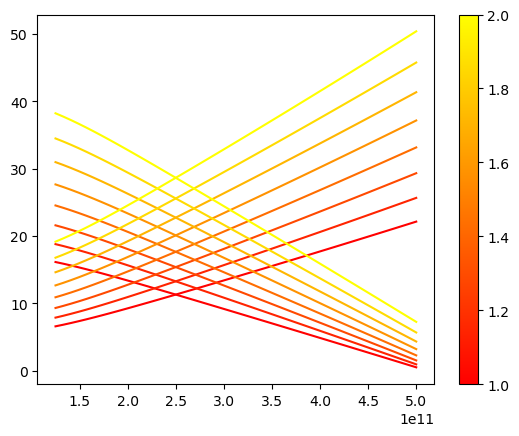

In [42]:
fig,ax = plt.subplots()
import matplotlib as mpl
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
c1 = mpl.colormaps.get_cmap('autumn')
c2 = mpl.colormaps.get_cmap('winter')
norm =Normalize()
norm.autoscale(df['b'])
E0 = 1/(nqcpfem.UNIT_CONVENTION['J to eV']*1000000) # unit_scale: 1muev
for n,g in df.groupby('b'):
    ax.plot(g['lx'],g['Ex']/E0,label='Ex',c=c1(norm(n)))
    ax.plot(g['lx'],g['Ey']/E0,label='Ey',c=c1(norm(n)))

fig.colorbar(ScalarMappable(norm=norm,cmap=c1),ax =ax)

In [46]:
1.75/np.sqrt(2)

1.2374368670764582

### Fix B verification

In [3]:
OMEGA_Y_VAL = 2.5e11 # around 35*2=70 nm in diameter
B_VAL = 1.75/np.sqrt(2) # we need 1.75 total magnitude of the B-field in the final experiment to get the splittings shown in the plot.
Lx_values =  np.linspace(0.25,4,64)*OMEGA_Y_VAL

from nqcpfem.spin_gap import find_spin_gap

from nqcpfem.solvers import IterativeSolver
single_solver = PETScSolver(k=6,which='SM',sigma=0)
solver = IterativeSolver(single_solver) # take previous states as next guess as they will be similar

from nqcpfem.band_model import __POSITION_NAMES__
import sympy
X,Y = sympy.symbols(__POSITION_NAMES__[:2],commutative=False)
Xop = sympy.Array([[X,0,0,0],[0,X,0,0],[0,0,X,0],[0,0,0,X]])
Xsqop = sympy.Array([[X**2,0,0,0],[0,X**2,0,0],[0,0,X**2,0],[0,0,0,X**2]])
Ysqop = sympy.Array([[Y**2,0,0,0],[0,Y**2,0,0],[0,0,Y**2,0],[0,0,0,Y**2]])
from nqcpfem.fenics import FEniCsObservable


def compute_variance(eigenvecs,Xop,Yop):
    X_vals = []
    Y_vals = []
    for ev in eigenvecs:
        X_vals.append(Xop.mel(ev))
        Y_vals.append(Yop.mel(ev))
    return X_vals,Y_vals


def sho_eval_b_field(lx):
    #make band_model and fem model
    bm = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge')
    bm.add_z_confinement(1,'box',25e-9)
    bm.add_zeeman_term()#B=[1,1,1])



    domain = RectangleDomain(Lx=300e-9,Ly=300e-9,Lz=0)  #Ly does not need the same size but has same resolution
    domain.resolution = [150,150]
    fem_model = FEniCsModel(bm,domain,0,('CG',1))


    x,y,z = bm.position_symbols
    omega_x,omega_y = sympy.symbols(r'\omega_x,\omega_y')
    m = sympy.symbols('m')

    V = 0.5*m*( (omega_x*x)**2 + (omega_y*y)**2 ) 

    bm.add_potential(V)

    bm.material_spec('Ge')

    E0 = 1/(nqcpfem.UNIT_CONVENTION['J to eV']*1000000) # unit_scale: 1muev


    fem_model.band_model.parameter_dict[omega_y] = OMEGA_Y_VAL

    fem_model.band_model.parameter_dict[omega_x] = lx

    fenics_xsq_op = FEniCsObservable(Xsqop,fem_model)
    fenics_ysq_op = FEniCsObservable(Ysqop,fem_model)

    for bname in _B_:
    
        bm.function_dict[bname] = SymbolicFunction(sympy.sympify(0),bname)
    
    fem_model.band_model.function_dict[_B_[0]]= SymbolicFunction(sympy.sympify(B_VAL),_B_[0])
    fem_model.band_model.function_dict[_B_[1]]= SymbolicFunction(sympy.sympify(0),_B_[1])
    #compute Bx energies
    
    solution =solver.solve(fem_model)
    Bx_energies = find_spin_gap(solution,fem_model)
    LOG.info(Bx_energies[0])

    xx,xy = compute_variance(solution[1],fenics_xsq_op,fenics_ysq_op)
    
    #compute By energies
    fem_model.band_model.function_dict[_B_[0]]= SymbolicFunction(sympy.sympify(0),_B_[0])
    fem_model.band_model.function_dict[_B_[1]]= SymbolicFunction(sympy.sympify(B_VAL),_B_[1])
    
    solution =solver.solve(fem_model)
    By_energies = find_spin_gap(solution,fem_model)
    LOG.info(By_energies[0])
    
    yx,yy = compute_variance(solution[1],fenics_xsq_op,fenics_ysq_op)
    fem_model.band_model.function_dict[_B_[1]]= SymbolicFunction(sympy.sympify(0),_B_[1])
    
    del fem_model
    
    return_val = ((Bx_energies[0],xx,xy),(By_energies[0],yx,yy)) #only return the eigenvalues and drop eigenvectors
    print(return_val)
    return return_val
    
from nqcpfem.parameter_search import ParameterSearch,DBMPParameterSearch
sho_save = 'sho_fem_verification.save'

#Lx_values = np.linspace(50e-9,200e-9,64)

verification_search  = None 

if os.path.exists(sho_save):
    try:
        verification_search = ParameterSearch.load(sho_save)
    except Exception as err:
        print(err)
#sho_search=None
#sho_search = None
if verification_search is None:
    verification_search = DBMPParameterSearch(parameter_sets = Lx_values,evaluation_function=sho_eval_b_field,save_file=sho_save)

In [3]:
verification_search.run(2)


INFO:nqcpfem.parameter_search:running database MP parametersearch with 64 points and 2 workers


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [217.25504689116957, 9795.64344460557, 9846.406405771368, 10713.996455801385, 10697.469157939857]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 217.25504689116957
INFO:root:(1.1842929348417987e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [224.36926568451287, 9766.1258666759, 9713.127739419257, 10645.690523728503, 10636.205421560904, 10818.553017077551, 11055.180184215662]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 224.36926568451287
INFO:root:(3.540875309687155e-24+0j)


(((1.1842929348417987e-24+0j), [2.520678349851751e-15, 9.790141477977342e-16, 2.548277944409109e-15, 9.428103401142663e-16, 5.904962213980124e-15, 9.723281597084533e-16, 5.9402797244790485e-15, 9.341925863056431e-16, 6.997393768064809e-15, 9.632015994206569e-16, 7.00121162833129e-15, 9.21675799635621e-16], []), ((3.540875309687155e-24+0j), [2.5501275555022046e-15, 9.40488238315061e-16, 2.5213651084005394e-15, 9.774973855605195e-16, 5.943109661340956e-15, 9.331502977697326e-16, 5.90500240901715e-15, 9.694149263828767e-16, 6.997480095884913e-15, 9.58466355440173e-16, 7.003911106548257e-15, 9.223443780655913e-16, 2.5458801459636167e-15, 2.7877398810056208e-15, 2.507824355869757e-15, 2.902744496181286e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [224.68307049110808, 9989.989994389316, 10063.114973128084, 11215.075547605275, 11199.318860606336, 10616.93910663418, 10836.426822164363]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 224.68307049110808
INFO:root:(1.2146084689742293e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [231.64588160052017, 9956.211187764762, 9881.625063742635, 11124.237440828536, 10818.150531854728, 11114.674492826472, 11054.379538311769]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 231.64588160052017
INFO:root:(3.509391466911813e-24+0j)


(((1.2146084689742293e-24+0j), [2.342143063729129e-15, 9.788929315105642e-16, 2.3780153506902556e-15, 9.426886134830015e-16, 5.684335854998459e-15, 9.722003251795355e-16, 5.73420103453519e-15, 9.341106996492176e-16, 6.968925158096012e-15, 9.632128418712402e-16, 6.980388989202293e-15, 9.220328896930684e-16, 2.3669250261525105e-15, 2.7966257423150782e-15, 2.3301127614842546e-15, 2.9051732898288784e-15], []), ((3.509391466911813e-24+0j), [2.380392775080071e-15, 9.403851663305462e-16, 2.3432260391993657e-15, 9.77353591318508e-16, 5.737826257706421e-15, 9.3307599161519e-16, 5.685193605667485e-15, 9.692775132267664e-16, 6.9697946772330956e-15, 9.58511179271767e-16, 2.373116288992109e-15, 2.787363667785633e-15, 6.983409467989073e-15, 9.225839181834624e-16, 2.3270830068426014e-15, 2.9021435980399713e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [233.45926137862975, 10181.77780396814, 10275.65694311356, 11722.257637607148, 10615.992388725042, 10835.02592222176, 11711.656974370631]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 233.45926137862975
INFO:root:(1.2600177028806989e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [240.18296155399509, 10144.6022253302, 10046.236759243004, 10817.022316587581, 11611.095328542442, 11606.563495731443, 11053.240166022013]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 240.18296155399509
INFO:root:(3.462427981545247e-24+0j)


(((1.2600177028806989e-24+0j), [2.1573992681397662e-15, 9.787283429369439e-16, 2.1999965409177143e-15, 9.425164612447293e-16, 5.4307259917867255e-15, 9.72038859845954e-16, 5.496119089150612e-15, 9.340024189955763e-16, 6.906734559177111e-15, 9.632884729594827e-16, 2.186101254217298e-15, 2.795955823354215e-15, 2.1441918799592765e-15, 2.904408278932338e-15, 6.9298124955955435e-15, 9.225882152965446e-16], []), ((3.462427981545247e-24+0j), [2.202809261194441e-15, 9.40239769391257e-16, 2.158812010833361e-15, 9.771576591908862e-16, 5.500629704311353e-15, 9.329767655960986e-16, 5.432414829640395e-15, 9.691079611984837e-16, 2.1934642236308372e-15, 2.7867346396070903e-15, 6.908612067224369e-15, 9.586507712461718e-16, 6.933491674618026e-15, 9.229563311292504e-16, 2.141003873540778e-15, 2.9012972840732874e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [242.4328806132565, 10348.1142831498, 10464.236607536446, 10614.110151759096, 10832.904223337197, 12200.582529034598, 12200.084764634976]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 242.4328806132565
INFO:root:(1.321047273422957e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [248.87970988167757, 10310.404887437988, 10189.622554365771, 10814.895315192125, 11051.517229391935, 12072.84184618558, 12079.291623950845]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 248.87970988167757
INFO:root:(3.399457508716713e-24+0j)


(((1.321047273422957e-24+0j), [1.9764962399280097e-15, 9.785211872089416e-16, 2.0237301349175714e-15, 9.422929383050288e-16, 5.152619022555288e-15, 9.718604753659114e-16, 5.233321378045396e-15, 9.338871219985513e-16, 2.0084331166810366e-15, 2.7949803380309076e-15, 1.9631570117273138e-15, 2.903381246572284e-15, 6.8038491163646975e-15, 9.634759220853747e-16, 6.842314539000051e-15, 9.234616075808e-16], []), ((3.399457508716713e-24+0j), [2.0268468231695248e-15, 9.400512662331075e-16, 1.9781504611787273e-15, 9.76910487531421e-16, 5.2387637807901e-15, 9.328659783926494e-16, 5.155057465393133e-15, 9.689328694594126e-16, 2.0166968614782366e-15, 2.7858052041611848e-15, 1.9598435980522863e-15, 2.900180725334001e-15, 6.806899958744446e-15, 9.589530762893389e-16, 6.8470902497896815e-15, 9.235383758596938e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [250.67113766320367, 10480.554774137194, 10618.175417609613, 10611.051086607618, 10829.705784403755, 12623.965538631917]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 250.67113766320367
INFO:root:(1.3966617222764241e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [256.75081617063745, 10446.481426419414, 10303.49090237278, 10811.350353536729, 11048.859084306103]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 256.75081617063745
INFO:root:(3.321555798271167e-24+0j)


(((1.3966617222764241e-24+0j), [1.8065201871436837e-15, 9.78276109373463e-16, 1.8562573989755923e-15, 9.420219630131989e-16, 4.8595045854468575e-15, 9.717077356224542e-16, 4.954090958377044e-15, 9.33816738349125e-16, 1.84103239350639e-15, 2.7936702284286114e-15, 1.7941647444405666e-15, 2.902043442271722e-15, 6.6573239530162364e-15, 9.638612646428387e-16], []), ((3.321555798271167e-24+0j), [1.8595385432911306e-15, 9.398229442040636e-16, 1.8083276194235915e-15, 9.766176479840935e-16, 4.960475934076256e-15, 9.327806575311904e-16, 4.862501415097331e-15, 9.688171027641228e-16, 1.8499711903539e-15, 2.7845162250664e-15, 1.7907214090971067e-15, 2.8987670952100647e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [257.59085265787644, 10576.641099867858, 10735.00561450383, 10606.440239021113, 10824.782136667533]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 257.59085265787644
INFO:root:(1.4847895012500772e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [263.2176223219972, 10556.35899404187, 10385.681832734033, 10805.612747524492, 11044.755059648774]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 263.2176223219972
INFO:root:(3.2308695472349454e-24+0j)


(((1.4847895012500772e-24+0j), [1.651521898666296e-15, 9.780000507733072e-16, 1.7019367696818323e-15, 9.417107620530519e-16, 4.561011438477659e-15, 9.71668715207551e-16, 4.667029178750783e-15, 9.339037187124977e-16, 1.6881983636303687e-15, 2.791971201590528e-15, 1.6412923493799167e-15, 2.9003008983929255e-15], []), ((3.2308695472349454e-24+0j), [1.7052583866208363e-15, 9.395608758150484e-16, 1.6534086065464682e-15, 9.762875157178987e-16, 4.67435979209913e-15, 9.328007795287715e-16, 4.564246187078155e-15, 9.688960349448826e-16, 1.697722541999868e-15, 2.782757227982964e-15, 1.6376421771936722e-15, 2.8970031424976198e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [263.0701983461411, 10643.762370748966, 10819.25031247861, 10599.351384173338, 10816.8691280223]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 263.0701983461411
INFO:root:(1.582941150619273e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [268.1512547765101, 10633.421442768034, 10441.349874825479, 10796.123627052222, 11038.318493204477]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 268.1512547765101
INFO:root:(3.1299844814916236e-24+0j)


(((1.582941150619273e-24+0j), [1.5130363357083276e-15, 9.777005849719846e-16, 1.5627725391867208e-15, 9.413679551801054e-16, 4.2658876683118945e-15, 9.719148204828491e-16, 4.380181250030979e-15, 9.343788335510862e-16, 1.5519077387134075e-15, 2.789755716485944e-15, 1.5062086220975594e-15, 2.897951293545714e-15], []), ((3.1299844814916236e-24+0j), [1.5660388362707416e-15, 9.392723222120612e-16, 1.5149482595681146e-15, 9.759292474568247e-16, 4.388475994061719e-15, 9.330969480562419e-16, 4.268899621734833e-15, 9.694331577380288e-16, 1.5621666039924804e-15, 2.780288862185871e-15, 1.5021461767112821e-15, 2.8947664085740063e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [267.2659079840414, 10681.996288485134, 10866.049394506124, 10587.945583177127, 10803.30560902957]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 267.2659079840414
INFO:root:(1.6887021522529593e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [271.71438581782684, 10466.042239089755, 10676.89117014518, 10779.5233224732, 11027.800516231211]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 271.71438581782684
INFO:root:(3.0214169981602305e-24+0j)


(((1.6887021522529593e-24+0j), [1.3908495018700727e-15, 9.773846799936071e-16, 1.4390257277923321e-15, 9.41001964484204e-16, 3.981053001541566e-15, 9.72784712788019e-16, 4.100098207059227e-15, 9.35729458539991e-16, 1.432618306622938e-15, 2.7867311901811386e-15, 1.3891721548838624e-15, 2.894540778829688e-15], []), ((3.0214169981602305e-24+0j), [1.442171695645619e-15, 9.389643977542138e-16, 1.3927515668028222e-15, 9.755512743809097e-16, 3.983211355583388e-15, 9.709410282667574e-16, 4.109403518661986e-15, 9.34058279637996e-16, 1.444191635634484e-15, 2.7765667651861864e-15, 1.3842378827515752e-15, 2.8917795505444165e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [270.44208870700095, 10685.180307743813, 10872.403521501688, 10568.24870823179, 10777.85051806928]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 270.44208870700095
INFO:root:(1.800016994852255e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [274.1905231954206, 10448.387055978963, 10688.793641596312, 10747.815639966153, 11009.421627100928]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 274.1905231954206
INFO:root:(2.907317614170566e-24+0j)


(((1.800016994852255e-24+0j), [1.283731892502483e-15, 9.770580587510021e-16, 1.3298598604016372e-15, 9.406200495397057e-16, 3.7108473063150355e-15, 9.749966902897684e-16, 3.830835710635464e-15, 9.390842845308803e-16, 1.3302184941208832e-15, 2.782222502930655e-15, 1.2902603758192424e-15, 2.8889751827653077e-15], []), ((2.907317614170566e-24+0j), [1.3328474541829582e-15, 9.386432522630222e-16, 1.2856039712360666e-15, 9.751605200245e-16, 3.709720901145207e-15, 9.751061468901816e-16, 3.842722617824068e-15, 9.360484605638935e-16, 1.3446300740753593e-15, 2.7702591181849063e-15, 1.2833951215922228e-15, 2.8874024771087576e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [272.8990463203777, 10649.92213458383, 10833.522463936417, 10530.65074407767, 10723.473862528133]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 272.8990463203777
INFO:root:(1.9152870405427782e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [275.8801064312282, 10378.920464876259, 10674.09729581474, 10679.242292425884, 10973.92229626101]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 275.8801064312282
INFO:root:(2.7893656896978254e-24+0j)


(((1.9152870405427782e-24+0j), [1.18999743048986e-15, 9.767250505161577e-16, 1.2338725978867379e-15, 9.402279378969283e-16, 3.456242659114621e-15, 9.802660922307239e-16, 3.572263187083308e-15, 9.474921088587184e-16, 1.2452904549566112e-15, 2.7745519275590144e-15, 1.2114275973814935e-15, 2.8782380647415644e-15], []), ((2.7893656896978254e-24+0j), [1.2366842748539487e-15, 9.383137512097621e-16, 1.191829705612835e-15, 9.747622167850142e-16, 3.447876490458142e-15, 9.853578496104606e-16, 3.589011175250441e-15, 9.410452404016912e-16, 1.2667047846495365e-15, 2.757638661843224e-15, 1.1998330945652564e-15, 2.8800258909941213e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [274.8520902248979, 10558.570998948328, 10677.078588196971, 10448.015079437206, 10583.018308763692]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 274.8520902248979
INFO:root:(2.0333488128560234e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [277.0429615713252, 10175.486924361312, 10587.266154006336, 10501.849668476152, 10894.451196338086]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 277.0429615713252
INFO:root:(2.6687884944649586e-24+0j)


(((2.0333488128560234e-24+0j), [1.107863742289359e-15, 9.763887338726145e-16, 1.1494649359404177e-15, 9.398298602504745e-16, 3.212730887419571e-15, 9.934506089205652e-16, 3.314101821580075e-15, 9.713551784342738e-16, 1.1818630831877545e-15, 2.7588935934065727e-15, 1.1629443934053367e-15, 2.8519544943343364e-15], []), ((2.6687884944649586e-24+0j), [1.152097117804899e-15, 9.37979497559363e-16, 1.1096527900446973e-15, 9.743600779520618e-16, 3.183178731163191e-15, 1.0148147760776e-15, 3.344913318062078e-15, 9.537197641691607e-16, 1.224145580315194e-15, 2.7257289818329183e-15, 1.137277888861852e-15, 2.864895943651537e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [276.49423434404565, 10284.896301147384, 10128.303520853498, 10224.620680303135, 10099.510203555443]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 276.49423434404565
INFO:root:(2.153396928931962e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [277.87237984415543, 9506.575838794599, 10341.624065493856, 9886.874435504273, 10669.351538685756]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 277.87237984415543
INFO:root:(2.5464389344387903e-24+0j)


(((2.153396928931962e-24+0j), [1.03565037471485e-15, 9.760511959612027e-16, 1.0750627006878286e-15, 9.394287875881114e-16, 2.9606407424643764e-15, 1.03211052253214e-15, 3.0010575369252532e-15, 1.0614547964471739e-15, 1.1577611321765044e-15, 2.71772008569034e-15, 1.1987963313110288e-15, 2.7593575825966327e-15], []), ((2.5464389344387903e-24+0j), [1.077520399288433e-15, 9.37643026694226e-16, 1.03739635796355e-15, 9.739566125316885e-16, 2.8464355642116824e-15, 1.1260324284059196e-15, 3.0906833278451532e-15, 9.92345427481869e-16, 1.2843353066895526e-15, 2.6120112007927257e-15, 1.1142078588018844e-15, 2.8237501069077826e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [277.9277520664877, 9390.862334429446, 8400.973392838061, 9458.127159040623, 8567.752310174285]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 277.9277520664877
INFO:root:(2.274894849548195e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [278.4901585936835, 8019.386876131472, 9439.268641692408, 8316.779320423015, 9800.477430156277]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 278.4901585936835
INFO:root:(2.4228871939129693e-24+0j)


(((2.274894849548195e-24+0j), [9.718671839815124e-16, 9.757137994227101e-16, 1.009229301980044e-15, 9.39026725350826e-16, 2.6079636647081376e-15, 1.1844293561571841e-15, 2.2851156568736294e-15, 1.5621974332177397e-15, 1.2623324269687563e-15, 2.5629215301541974e-15, 1.6649274121927064e-15, 2.256003261355265e-15], []), ((2.4228871939129693e-24+0j), [1.011522220710871e-15, 9.373060521545128e-16, 9.735720531980565e-16, 9.735534499947558e-16, 2.1016954554796636e-15, 1.6562817146335716e-15, 2.7176516467534946e-15, 1.1613048627858288e-15, 1.7806310464047784e-15, 2.0792563547807385e-15, 1.2372184305322732e-15, 2.6521999122560448e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [279.29442299510316, 7948.013405759601, 9060.47947947148, 8211.359247996272, 9409.010498322054]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 279.29442299510316
INFO:root:(2.3974954635523553e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [278.8868771444336, 9017.081912573101, 8170.939070223798, 9133.425741082492, 8376.403246205367]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 278.8868771444336
INFO:root:(2.2985030976044057e-24+0j)


(((2.3974954635523553e-24+0j), [9.1523795846703e-16, 9.753774069408313e-16, 9.507091241656457e-16, 9.386249851150496e-16, 1.803718558543546e-15, 1.8342831805545094e-15, 1.2273223550832656e-15, 2.5222198992569615e-15, 1.8440112760241e-15, 1.910294684411103e-15, 2.4973971082496187e-15, 1.2936082002868232e-15], []), ((2.2985030976044057e-24+0j), [9.528490768777876e-16, 9.369696944983341e-16, 9.16904397761147e-16, 9.731516136411577e-16, 1.2348369170102916e-15, 2.4298218251510714e-15, 1.7405554283987379e-15, 1.983553798266769e-15, 2.4245807721766036e-15, 1.3029247324328498e-15, 1.988750808399546e-15, 1.8275964325243026e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [280.5478443372016, 9103.891959554812, 10162.733567526253, 9497.88383347846, 10497.880739015009]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 280.5478443372016
INFO:root:(2.520979090866852e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [279.3320385378285, 10086.809253253788, 9778.130865735378, 10049.66005638887, 9794.778465237147]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 279.3320385378285
INFO:root:(2.1735209131683567e-24+0j)


(((2.520979090866852e-24+0j), [8.646907060152347e-16, 9.75042550354747e-16, 8.984318235268726e-16, 9.382244026743423e-16, 1.1114308204490664e-15, 2.4926249279084045e-15, 9.417093105341496e-16, 2.7732497755332537e-15, 2.335869853342133e-15, 1.2494015530299586e-15, 2.5800328119405447e-15, 1.0399484048053337e-15], []), ((2.1735209131683567e-24+0j), [9.004311551087428e-16, 9.366346661329787e-16, 8.663215660795557e-16, 9.727517264939873e-16, 9.7911321771374e-16, 2.6482488411888096e-15, 1.037535562466175e-15, 2.655705402941952e-15, 2.479476057429284e-15, 1.081997156127294e-15, 2.4886069013972977e-15, 1.1527679893851083e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [281.73952752099694, 9950.58520421415, 10499.665784212742, 10300.713827360223, 10804.477476087292]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 281.73952752099694
INFO:root:(2.6452088305187505e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [279.652272388182, 10431.57342324492, 10531.30392507107, 10337.964595429916, 10439.154002944742]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 279.652272388182
INFO:root:(2.048086353118958e-24+0j)


(((2.6452088305187505e-24+0j), [8.193337511055979e-16, 9.747095493291713e-16, 8.514974966152738e-16, 9.378254988596017e-16, 9.143744731837912e-16, 2.6647717978670197e-15, 8.450132004156632e-16, 2.833252644913796e-15, 2.352137379288107e-15, 1.0746829915645338e-15, 2.4933235510468735e-15, 9.773127907056025e-16], []), ((2.048086353118958e-24+0j), [8.533681933012738e-16, 9.363014083291173e-16, 8.209317733548264e-16, 9.72354155698237e-16, 8.815433264898066e-16, 2.708083046138138e-15, 8.68898329017729e-16, 2.7957008955234414e-15, 2.395932135012342e-15, 1.019583670208774e-15, 2.473594388422139e-15, 1.010155463358458e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [282.9233433919529, 10242.222593741426, 10627.28787841995, 10547.254777625569, 10902.485645326276]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 282.9233433919529
INFO:root:(2.7701001216767966e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [279.9637339390492, 10570.193686042217, 10764.853664753402, 10438.500823273223, 10628.575248002247]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 279.9637339390492
INFO:root:(1.922288831560488e-24+0j)


(((2.7701001216767966e-24+0j), [7.784280773103895e-16, 9.743785906464505e-16, 8.091544932791543e-16, 9.374285915182725e-16, 8.313330493021613e-16, 2.7159232776047784e-15, 7.870693385525771e-16, 2.854769613495153e-15, 2.271584044535807e-15, 1.0209355710535436e-15, 2.3850774363551603e-15, 9.53172475400097e-16], []), ((1.922288831560488e-24+0j), [8.10907734664794e-16, 9.35970187098217e-16, 7.799957795880066e-16, 9.719591089010626e-16, 8.213004251164694e-16, 2.731019099429286e-15, 7.956265045124344e-16, 2.8355539413268453e-15, 2.2922813787796905e-15, 9.940392390670602e-16, 2.380432810756831e-15, 9.67703690242018e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [284.09468314396076, 10365.334577414671, 10688.315706556674, 10654.24522837906, 10956.176422241071]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 284.09468314396076
INFO:root:(2.895600803953555e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [280.26676544147296, 10639.14034067662, 10862.337816409528, 10494.365812323696, 10705.05978405056]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 280.26676544147296
INFO:root:(1.796182734400766e-24+0j)


(((2.895600803953555e-24+0j), [7.413609585242466e-16, 9.740497793455036e-16, 7.707761355315696e-16, 9.370338703526195e-16, 7.778352635245069e-16, 2.736471283293267e-15, 7.427859300998578e-16, 2.8644920152516164e-15, 2.176508551800509e-15, 9.977846180475888e-16, 2.2782989284312394e-15, 9.40824159554438e-16], []), ((1.796182734400766e-24+0j), [7.72422112481835e-16, 9.356411575701204e-16, 7.429006039590409e-16, 9.715666962957967e-16, 7.750293656550893e-16, 2.741822594334348e-15, 7.465734777078463e-16, 2.851318608226124e-15, 2.18970340809832e-15, 9.806188440350026e-16, 2.2781894197155965e-15, 9.493431555015069e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [285.25915159219045, 10428.113390689576, 10722.281322730596, 10694.376694109604, 10981.946793175208]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 285.25915159219045
INFO:root:(3.0216784417794606e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [280.5608992012727, 10678.25994629924, 10911.9607810646, 10514.342648299373, 10745.084062402499]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 280.5608992012727
INFO:root:(1.669801029676607e-24+0j)


(((3.0216784417794606e-24+0j), [7.076228997677115e-16, 9.73723170852907e-16, 7.358392731438343e-16, 9.36641445429428e-16, 7.36086254605571e-16, 2.746341508052782e-15, 7.055388313059432e-16, 2.869454551417076e-15, 2.0828305416697305e-15, 9.853096005639903e-16, 2.1777716053121803e-15, 9.332312304003064e-16], []), ((1.669801029676607e-24+0j), [7.373871559493458e-16, 9.353144059199426e-16, 7.091365045903162e-16, 9.711769695009239e-16, 7.361162760566475e-16, 2.747532113710634e-15, 7.07450308527104e-16, 2.858748343054934e-15, 2.0929359056767965e-15, 9.722886898296207e-16, 2.1793150101144994e-15, 9.393187346507808e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [286.41739867297304, 10464.356858169864, 10743.21177312168, 10715.684081672513, 10987.93508299943]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 286.41739867297304
INFO:root:(3.148312451902083e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [280.849006779636, 10702.65093755576, 10940.608833671433, 10521.067175387701, 10756.309934573366]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 280.849006779636
INFO:root:(1.5431637760691282e-24+0j)


(((3.148312451902083e-24+0j), [6.767883631087985e-16, 9.733987907819042e-16, 7.039057635270404e-16, 9.362513779047688e-16, 7.007140337573548e-16, 2.7515583843821065e-15, 6.728598883892893e-16, 2.8721273459139897e-15, 1.9943114921688516e-15, 9.774881275666538e-16, 2.0843643704212003e-15, 9.279234334066797e-16], []), ((1.5431637760691282e-24+0j), [7.053637484158929e-16, 9.349899760585366e-16, 6.782777201008536e-16, 9.707899454117372e-16, 7.020081932718074e-16, 2.7507273470769794e-15, 6.739177038200104e-16, 2.8625512553054593e-15, 2.0029197579963756e-15, 9.664707553825738e-16, 2.0865505567780785e-15, 9.329224320192703e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [287.57654305218966, 10487.107143112038, 10757.049731198204, 10736.585019244296, 11000.428198642028]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 287.57654305218966
INFO:root:(3.2754893032483614e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [281.14036580467024, 10718.89501583916, 10958.601039002624, 10536.510218878322, 10763.30510070976]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 281.14036580467024
INFO:root:(1.4162833449892558e-24+0j)


(((3.2754893032483614e-24+0j), [6.485000494698957e-16, 9.730766469594875e-16, 6.746070307453091e-16, 9.358636991440726e-16, 6.695643308256509e-16, 2.7544209249802695e-15, 6.435664629168968e-16, 2.8735585181401365e-15, 1.911726609744311e-15, 9.720222053939015e-16, 1.9978799031142667e-15, 9.238526729637758e-16], []), ((1.4162833449892558e-24+0j), [6.759824221955367e-16, 9.34667886343172e-16, 6.499667555806341e-16, 9.704056205854093e-16, 6.714607756978713e-16, 2.7525339160812043e-15, 6.441985988813329e-16, 2.8645202805305407e-15, 1.919518430120154e-15, 9.620401122296798e-16, 2.0002932208364953e-15, 9.283615431392468e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [288.7340068646415, 10502.233836338539, 10766.668885792196, 10741.608013715722, 11007.877655305194]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 288.7340068646415
INFO:root:(3.403199633176568e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [281.4254227387352, 10730.242243450793, 10970.575640216997, 10538.617923885617, 10775.427410464843]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 281.4254227387352
INFO:root:(1.2891675788629376e-24+0j)


(((3.403199633176568e-24+0j), [6.224562448898859e-16, 9.727567366596896e-16, 6.476314410401406e-16, 9.354784224656945e-16, 6.415648835410039e-16, 2.7559605984491186e-15, 6.169763592693599e-16, 2.8742556921558404e-15, 1.8349678189590116e-15, 9.678810110618203e-16, 1.9178129608718693e-15, 9.205111709820096e-16], []), ((1.2891675788629376e-24+0j), [6.489307459249758e-16, 9.34348139944007e-16, 6.239017279233969e-16, 9.70023979769373e-16, 6.437515173681897e-16, 2.753508114165872e-15, 6.173844756643557e-16, 2.8654597316318742e-15, 1.8422722889964406e-15, 9.584407696511502e-16, 1.9202636216242637e-15, 9.248318748023664e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [289.8907854624416, 10512.71094015574, 10773.609602156468, 10733.85003910094, 11006.769250869103]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 289.8907854624416
INFO:root:(3.5314365357734355e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [281.7174427752341, 10738.454001214172, 10978.8841796901, 10529.610091347036, 10776.881079735806]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 281.7174427752341
INFO:root:(1.1618216794582465e-24+0j)


(((3.5314365357734355e-24+0j), [5.984006921503066e-16, 9.724390509272337e-16, 6.227140861098251e-16, 9.35095550284823e-16, 6.160867057521476e-16, 2.7566977483843443e-15, 5.926402903303943e-16, 2.874489715624462e-15, 1.7636523891887303e-15, 9.645447934733242e-16, 1.8435912327832186e-15, 9.176276293924457e-16], []), ((1.1618216794582465e-24+0j), [6.239431069587793e-16, 9.34030731298047e-16, 5.998262346681659e-16, 9.696450008211072e-16, 6.184041240676986e-16, 2.7539515695549927e-15, 5.929278044679588e-16, 2.8657752612891406e-15, 1.7706442649867985e-15, 9.55371152497472e-16, 1.8459869016874465e-15, 9.219277482500572e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.0477933983841, 10520.181007869109, 10778.759063734728, 10738.58368734401, 11002.015758219819]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.0477933983841
INFO:root:(3.6601945557881364e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [282.01170181851506, 10744.555980648965, 10984.823333002863, 10527.639910319398, 10768.348377048711]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 282.01170181851506
INFO:root:(1.0342493284406046e-24+0j)


(((3.6601945557881364e-24+0j), [5.761144934178174e-16, 9.721235771555426e-16, 5.996285507622867e-16, 9.347150784351808e-16, 5.927132707359878e-16, 2.756919393016917e-15, 5.702341560369012e-16, 2.8744159331623937e-15, 1.6973272759899305e-15, 9.617273831800277e-16, 1.7746585716977815e-15, 9.15045788476801e-16], []), ((1.0342493284406046e-24+0j), [6.007924719203435e-16, 9.337156502871977e-16, 5.775212535848418e-16, 9.692686573319248e-16, 5.950754884137882e-16, 2.754040017615025e-15, 5.704574029442317e-16, 2.8656902320824368e-15, 1.7041064776609996e-15, 9.526555099203095e-16, 1.7769530394429014e-15, 9.194257021076981e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.1944662839035, 10525.61680330104, 10782.65855409581, 10744.326611139932, 11006.603527086285]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.1944662839035
INFO:root:(3.7894691020046456e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [282.30047772688795, 10749.180624408757, 10989.150769740801, 10533.956076538509, 10767.20299240721]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 282.30047772688795
INFO:root:(9.064533528000103e-25+0j)


(((3.7894691020046456e-24+0j), [5.554096254532184e-16, 9.718103006246298e-16, 5.781802830887861e-16, 9.343369987763667e-16, 5.711437846232889e-16, 2.756795913899982e-15, 5.495094607184337e-16, 2.874128027140906e-15, 1.6355431654157411e-15, 9.592600382873133e-16, 1.7105031150437683e-15, 9.126701204944612e-16], []), ((9.064533528000103e-25+0j), [5.792837470504291e-16, 9.334028853567004e-16, 5.567986553679328e-16, 9.688949195592576e-16, 5.735029835486951e-16, 2.7538818334260495e-15, 5.497002338136048e-16, 2.8653362910381193e-15, 1.6421703635429906e-15, 9.501853626315611e-16, 1.7126735504370536e-15, 9.171939610119647e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [293.3445239443131, 10529.640261085598, 10785.649943525352, 10742.632741151208, 11009.197940210897]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 293.3445239443131
INFO:root:(3.919256107325451e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [282.5898724414048, 10752.736361013605, 10992.347357252798, 10532.362407198234, 10772.038394435685]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 282.5898724414048
INFO:root:(7.784361305639806e-25+0j)


(((3.919256107325451e-24+0j), [5.361237276881136e-16, 9.714992054235898e-16, 5.582012448850541e-16, 9.33961300769177e-16, 5.511472734536409e-16, 2.756436269787232e-15, 5.30267917329292e-16, 2.8736831533361622e-15, 1.5778811482543304e-15, 9.570376577260825e-16, 1.6506644571305546e-15, 9.104393072233831e-16], []), ((7.784361305639806e-25+0j), [5.592484175622682e-16, 9.330924268457745e-16, 5.3749599042323205e-16, 9.685237535025958e-16, 5.53477065535568e-16, 2.753547022704007e-15, 5.304440235398703e-16, 2.864795376485531e-15, 1.5843950575726144e-15, 9.47890596800381e-16, 1.6527004773605893e-15, 9.15150397845366e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [294.49051028996263, 10532.68219734241, 10787.947527948629, 10733.461747917107, 11007.042350637146]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 294.49051028996263
INFO:root:(4.049551832721852e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [282.886192942733, 10755.497208739906, 10994.721512481354, 10523.503706117124, 10771.61164127082, 13900.297399418501]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 282.886192942733
INFO:root:(6.501998683639279e-25+0j)


(((4.049551832721852e-24+0j), [5.181158904168201e-16, 9.711902903047672e-16, 5.395455799234872e-16, 9.335879724324153e-16, 5.325378386463554e-16, 2.755919825139006e-15, 5.123477070672382e-16, 2.8731110253281765e-15, 1.5239608304461248e-15, 9.549917653441943e-16, 1.5947326377323936e-15, 9.083124229619657e-16], []), ((6.501998683639279e-25+0j), [5.405402031948104e-16, 9.327842729565808e-16, 5.194722816073734e-16, 9.681551163620224e-16, 5.348256587405036e-16, 2.7530825813022296e-15, 5.125173706722288e-16, 2.864120768657471e-15, 1.5303871920372726e-15, 9.457241205503304e-16, 1.5966307083877836e-15, 9.132415243750436e-16, 5.284021710262482e-16, 4.459299912228768e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [295.63445827961664, 10535.154863061412, 10789.63901126679, 10721.473442290606, 10999.403042021775, 13746.942455501861, 13945.801955278112]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 295.63445827961664
INFO:root:(4.180352754435122e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [283.1803302664072, 10757.652894411467, 10996.47686240858, 10507.931325070922, 10764.917048793213, 13902.874116506682, 14101.254196242047]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 283.1803302664072
INFO:root:(5.217468734677813e-25+0j)


(((4.180352754435122e-24+0j), [5.012632543289735e-16, 9.708834925425946e-16, 5.220860906684422e-16, 9.332170009299386e-16, 5.151571600502069e-16, 2.755333360005948e-15, 4.956183172054675e-16, 2.8723990940251415e-15, 1.473440813816656e-15, 9.530761005893673e-16, 1.5423440732593668e-15, 9.06261159849114e-16, 5.071965711992755e-16, 4.4702256523079625e-15, 4.896237945108073e-16, 4.655019439559651e-15], []), ((5.217468734677813e-25+0j), [5.230315162434345e-16, 9.324784459558375e-16, 5.026046163040312e-16, 9.67788941184077e-16, 5.174045137134059e-16, 2.752521083023966e-15, 4.957781744944179e-16, 2.8633484389620276e-15, 1.4797974005340555e-15, 9.436532484417876e-16, 1.5441045012767907e-15, 9.114311684795707e-16, 5.110696395350756e-16, 4.45856954152529e-15, 4.887727334789026e-16, 4.640954256133902e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [296.7666175739245, 10538.082345982228, 10790.375446664499, 10724.22485575833, 13748.529800869506, 10994.31767098696, 13948.563886981421]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 296.7666175739245
INFO:root:(4.31165549908433e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [283.4760316503497, 10759.338287557255, 10997.768079352214, 10506.490863878456, 13904.87436306169, 10752.069743883994, 14104.489182028636]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 283.4760316503497
INFO:root:(3.930800614727989e-25+0j)


(((4.31165549908433e-24+0j), [4.854581891123075e-16, 9.705788411087305e-16, 5.057113581026353e-16, 9.32848372936029e-16, 4.988356949812504e-16, 2.754962874584991e-15, 4.800049814410346e-16, 2.8713134245453056e-15, 1.4260163830790806e-15, 9.512583433580092e-16, 4.911112369248435e-16, 4.468996961072044e-15, 1.4931765974055524e-15, 9.042653794093253e-16, 4.739974427524748e-16, 4.654303460303749e-15], []), ((3.930800614727989e-25+0j), [5.066105363535561e-16, 9.32175052003239e-16, 4.867853935459651e-16, 9.674250775334701e-16, 5.010908509982884e-16, 2.7518857593115234e-15, 4.801063703161241e-16, 2.8625034370753377e-15, 1.4323157705088738e-15, 9.41654723105537e-16, 4.948678838703402e-16, 4.4576756746971e-15, 1.494801846337606e-15, 9.09694087174034e-16, 4.731377311409228e-16, 4.640139143676839e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [297.927479470476, 10564.638215530438, 10773.943933395905, 10725.922007264757, 13749.605789578996, 13950.798038988913, 10996.348125243157]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 297.927479470476
INFO:root:(4.4434568061732406e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [283.78578923556347, 10760.649459219938, 10998.692161502166, 10510.368352887668, 13906.41284746554, 10749.613635133974, 14107.000714412237]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 283.78578923556347
INFO:root:(2.642047139863478e-25+0j)


(((4.4434568061732406e-24+0j), [4.706060354666388e-16, 9.702763038418894e-16, 4.903233747723865e-16, 9.324820748660028e-16, 4.821193947568667e-16, 2.763246544466655e-15, 4.667522874430205e-16, 2.861453315637396e-15, 1.381415907505231e-15, 9.495153591704293e-16, 4.760428959522327e-16, 4.467623853929089e-15, 4.593628528834286e-16, 4.653437076351659e-15, 1.4469445164123097e-15, 9.02310382409229e-16], []), ((2.642047139863478e-25+0j), [4.911786443305269e-16, 9.318746003708836e-16, 4.719202257004706e-16, 9.670629725681864e-16, 4.857789535359666e-16, 2.7511935401611077e-15, 4.653991151875679e-16, 2.8616036622832628e-15, 1.3876672332498421e-15, 9.397116233193468e-16, 4.796828748660045e-16, 4.456653795489015e-15, 1.4484382362853394e-15, 9.08012200989718e-16, 4.585108230654036e-16, 4.6391257255208416e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [299.0583189311575, 10789.11776266204, 10544.41341623086, 10723.272848458899, 13750.273758403002, 13952.603551485685, 10997.530295318656]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 299.0583189311575
INFO:root:(4.575753506218317e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [284.1384297422874, 10761.634083616558, 10999.294344280735, 13907.557686993288, 10508.857156817003, 14108.932115672884, 10751.952902853991]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 284.1384297422874
INFO:root:(1.3514007834143337e-25+0j)


(((4.575753506218317e-24+0j), [4.566231979595379e-16, 9.699758640146267e-16, 4.758355891210406e-16, 9.321180930272253e-16, 4.516402270482292e-16, 2.8682366546673556e-15, 4.690468009218738e-16, 2.75479406398447e-15, 1.3393972575191436e-15, 9.478301869245215e-16, 4.618919559218385e-16, 4.466137931219726e-15, 4.456216514482484e-16, 4.6524550037899465e-15, 1.4033940476318103e-15, 9.003851966839132e-16], []), ((1.3514007834143337e-25+0j), [4.766464965844548e-16, 9.31581431689301e-16, 4.579280110318266e-16, 9.666982429622151e-16, 4.713769519615854e-16, 2.750457047481972e-15, 4.515673400028582e-16, 2.8606622109275634e-15, 4.654169707721579e-16, 4.455530660246615e-15, 1.345607255874278e-15, 9.37811451259274e-16, 4.44788117738877e-16, 4.637960665894385e-15, 1.40476049727021e-15, 9.0637224541108e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [300.19627697986346, 10793.256506326215, 10539.492485213344, 13750.612089089147, 13954.06214976019, 10715.724112283959, 10995.923766513477]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 300.19627697986346
INFO:root:(4.7085425077368426e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [316.63184201017435, 10741.006373352357, 10978.27253012637, 13891.845188040257, 14094.429237475502, 10525.597645390904, 10776.069490023227]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 316.63184201017435
INFO:root:(7.290081159592865e-27+0j)


(((4.7085425077368426e-24+0j), [4.4343557807429327e-16, 9.696775050919327e-16, 4.62171281018483e-16, 9.31756413717466e-16, 4.383347126143061e-16, 2.8691811195364326e-15, 4.557934751081208e-16, 2.7521084552649247e-15, 4.485727835254381e-16, 4.464563058397168e-15, 4.3268967992068817e-16, 4.651382925569979e-15, 1.2997443148978452e-15, 9.46190159008724e-16, 1.3622992567377947e-15, 8.984814679530025e-16], []), ((7.290081159592865e-27+0j), [4.610282258002825e-16, 9.349352609830347e-16, 4.466435331013011e-16, 9.626911319641091e-16, 4.5780441506926e-16, 2.7496858634474222e-15, 4.3853325564608956e-16, 2.8596888565420045e-15, 4.519856968110798e-16, 4.454326741869387e-15, 4.3188176495032677e-16, 4.636678190948535e-15, 1.3059179809056026e-15, 9.35944910516688e-16, 1.3635429603936624e-15, 9.04764322874728e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [301.3342458993661, 10794.2992522075, 10538.880790512074, 13750.681069041635, 13955.236589420965, 10703.305211338986, 10990.784523720955]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 301.3342458993661
INFO:root:(4.8418207892581686e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [284.75085384286245, 10558.280523568026, 10790.781433776205, 13750.308627110564, 13951.506352724682, 10714.527543065838, 10975.229171486575]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 284.75085384286245
INFO:root:(1.2384979006689393e-25+0j)


(((4.8418207892581686e-24+0j), [4.3097726350900245e-16, 9.693812107668033e-16, 4.49262205367366e-16, 9.31397023293184e-16, 4.259799600544813e-16, 2.8686107321313438e-15, 4.430757676967264e-16, 2.750881500096935e-15, 4.3601101060449797e-16, 4.462917570018036e-15, 4.204941098002585e-16, 4.6502401910468346e-15, 1.2622638286812573e-15, 9.44585674849375e-16, 1.323458506479201e-15, 8.965927221617194e-16], []), ((1.2384979006689393e-25+0j), [4.322581497847449e-16, 9.659822355950182e-16, 4.499980803467422e-16, 9.309954515213125e-16, 4.449904853824065e-16, 2.748887362729379e-15, 4.262284575712456e-16, 2.8586910121289693e-15, 4.3931534566760984e-16, 4.453057959136232e-15, 4.1971642438609883e-16, 4.6353038959395636e-15, 1.2684048319560323e-15, 9.341051334561533e-16, 1.3245840416073337e-15, 9.031809338867294e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [302.4659530141734, 10794.885802113111, 10538.59786690519, 13750.527728968882, 13956.181380656803, 10690.570274514193, 10981.844117226015]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 302.4659530141734
INFO:root:(4.975585394172227e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [284.9506097259893, 10558.9149526304, 10791.064456728838, 13750.929787295187, 13952.546976259595, 10702.048164972415, 10966.091377945739]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 284.9506097259893
INFO:root:(2.535391401307291e-25+0j)


(((4.975585394172227e-24+0j), [4.1918942845546706e-16, 9.690869649832094e-16, 4.370474538432123e-16, 9.310399082156257e-16, 4.143171036821744e-16, 2.8678611367024405e-15, 4.3102919660193937e-16, 2.7497898039463624e-15, 4.2414152145695987e-16, 4.4612157539616945e-15, 4.089713335133927e-16, 4.649041634335219e-15, 1.2267826165238264e-15, 9.430093896801763e-16, 1.2866913798765478e-15, 8.947138640216397e-16], []), ((2.535391401307291e-25+0j), [4.204543317335796e-16, 9.65640698786766e-16, 4.3775364406343435e-16, 9.306928186922891e-16, 4.328724068291168e-16, 2.748067312784226e-15, 4.145924367439522e-16, 2.857674396082522e-15, 4.2734114822197013e-16, 4.451736855180213e-15, 4.0822675622823545e-16, 4.633857258976971e-15, 1.2328935540967998e-15, 9.322872185411241e-16, 1.2877032448314553e-15, 9.016163502801217e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [303.5905954236973, 10795.273784043577, 10538.294147734041, 13750.189257755315, 13956.93372521314, 10690.272980997597, 10974.259078781433]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 303.5905954236973
INFO:root:(5.1098334271904465e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [285.22225241607083, 10559.468493053248, 10791.271026136075, 13751.41025368944, 13953.391329843438, 10700.927792032831, 10955.387576031128]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 285.22225241607083
INFO:root:(3.8346337061668906e-25+0j)


(((5.1098334271904465e-24+0j), [4.080194063788518e-16, 9.687947519498344e-16, 4.2547249507001075e-16, 9.306850550840806e-16, 4.03275334755559e-16, 2.867055883543566e-15, 4.196149105802519e-16, 2.748719439073005e-15, 4.1290690967530416e-16, 4.459468895549132e-15, 3.9806537409620987e-16, 4.647798785470888e-15, 1.1931451171786472e-15, 9.414556821491027e-16, 1.2518360262496491e-15, 8.92840830700548e-16], []), ((3.8346337061668906e-25+0j), [4.092724677905339e-16, 9.652935729170503e-16, 4.2614714057691085e-16, 9.30400272472459e-16, 4.21394334375884e-16, 2.747230282071008e-15, 4.035714007618893e-16, 2.8566434801494457e-15, 4.16005844717222e-16, 4.450373433588447e-15, 3.973555772077121e-16, 4.632353333637673e-15, 1.1992276390225173e-15, 9.304880313334422e-16, 1.2527385556214155e-15, 9.000662045462544e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [304.72032216483433, 10795.53564906713, 10537.907731049476, 13749.695419697799, 13957.526752595939, 10690.77746796009, 10974.177604050914]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 304.72032216483433
INFO:root:(5.2445620517171586e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [285.5026281792563, 10559.918507259286, 10791.3793805879, 13751.746663195307, 13954.040541566037, 10701.054051574869, 10953.865890796087]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 285.5026281792563
INFO:root:(5.135996969713743e-25+0j)


(((5.2445620517171586e-24+0j), [3.9741990459162946e-16, 9.685045561481837e-16, 4.1448836151596456e-16, 9.303324506588237e-16, 3.928030591481442e-16, 2.8662245896717236e-15, 4.08786591971191e-16, 2.7476484499733947e-15, 4.022562691279778e-16, 4.457686014685605e-15, 3.877266565216255e-16, 4.6465207282535735e-15, 1.1612112497178357e-15, 9.39920320313646e-16, 1.218746874927969e-15, 8.909703536492562e-16], []), ((5.135996969713743e-25+0j), [3.9866206832707483e-16, 9.649475912755128e-16, 4.1513262870761186e-16, 9.301110419444996e-16, 4.105063723229833e-16, 2.746379929451866e-15, 3.9311732070244495e-16, 2.8556017972726157e-15, 4.0525854723019016e-16, 4.448975745282541e-15, 3.87052466368044e-16, 4.6308039135706475e-15, 1.1672660750693518e-15, 9.287062583373478e-16, 1.2195441782184647e-15, 8.98527238199633e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [305.8470037648395, 10795.702805338951, 10537.431674421467, 13749.07029934914, 13957.987396436041, 10689.147598513675, 10974.833144423092]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 305.8470037648395
INFO:root:(5.379768487746404e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [285.7940124857329, 10560.270858427215, 10791.40300966263, 13751.957252716627, 13954.526413134567, 10699.470182571713, 10953.978537407787]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 285.7940124857329
INFO:root:(6.439424878943054e-25+0j)


(((5.379768487746404e-24+0j), [3.873483359849049e-16, 9.682163623364577e-16, 4.040509576420119e-16, 9.29982081877695e-16, 3.828561334575543e-16, 2.8653783452716174e-15, 3.9850061730848543e-16, 2.7465718734054325e-15, 3.9214422925163017e-16, 4.455874398266152e-15, 3.7791103732745016e-16, 4.645214702411348e-15, 1.1308545459691596e-15, 9.38400291513102e-16, 1.1872926647223359e-15, 8.890997954729312e-16], []), ((6.439424878943054e-25+0j), [3.885801510335355e-16, 9.646035673976874e-16, 4.046662542257107e-16, 9.298242769430914e-16, 4.0016377224479363e-16, 2.7455192148394106e-15, 3.831871452507561e-16, 2.8545521768828578e-15, 3.9505382724618117e-16, 4.447550391512411e-15, 3.772726851134619e-16, 4.629218351914139e-15, 1.1368813539084151e-15, 9.269428047858315e-16, 1.1879885720255363e-15, 8.969971888653126e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [306.9688858356736, 10795.794383056247, 10536.875607465334, 13748.333581376924, 13958.3353630547, 10684.483174277319, 10974.32553027151]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 306.9688858356736
INFO:root:(5.5154500100679385e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [286.0896334323521, 10560.546634013794, 10791.353245797724, 13752.059081160776, 13954.871024952294, 10695.172741206807, 10953.16997951268]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 286.0896334323521
INFO:root:(7.744888710890161e-25+0j)


(((5.5154500100679385e-24+0j), [3.777662480401363e-16, 9.679301555494423e-16, 3.9412046874599475e-16, 9.296339358673482e-16, 3.7339541663675296e-16, 2.864522684167911e-15, 3.887171811784486e-16, 2.7454892013444585e-15, 3.82530173323298e-16, 4.4540399910491914e-15, 3.6857902469129915e-16, 4.643886538772038e-15, 1.1019605116094087e-15, 9.368938037323893e-16, 1.1573547416182561e-15, 8.872270541881836e-16], []), ((7.744888710890161e-25+0j), [3.789881501316335e-16, 9.642616920822969e-16, 3.9470817649592156e-16, 9.295397510114942e-16, 3.903262643044534e-16, 2.7446505562339753e-15, 3.7374214968694375e-16, 2.8534968990986673e-15, 3.853509560579524e-16, 4.446102748401067e-15, 3.679763231741052e-16, 4.627604148677102e-15, 1.107957655476336e-15, 9.252017623062333e-16, 1.1579527401700115e-15, 8.954748348544984e-16], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [308.0885066585799, 10795.822855554783, 10536.246396489305, 13747.501455546566, 13958.58660371532, 10676.518974617502, 10971.869337501787]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 308.0885066585799
INFO:root:(5.651603946656432e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [286.3838296309479, 10560.751892500319, 10791.240541419684, 13752.066795424038, 13955.09545851581]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 286.3838296309479
INFO:root:(9.052367544218517e-25+0j)


(((5.651603946656432e-24+0j), [3.686388330008359e-16, 9.676459210973483e-16, 3.8466085382361297e-16, 9.292879999505139e-16, 3.6438577448734934e-16, 2.8636608828444765e-15, 3.7940018399320284e-16, 2.744401223022093e-15, 3.73377596419964e-16, 4.452187658736161e-15, 3.596951421800577e-16, 4.64254097751915e-15, 1.0744251700046948e-15, 9.354005230882836e-16, 1.1288255819908836e-15, 8.853505445793552e-16], []), ((9.052367544218517e-25+0j), [3.6985120536242727e-16, 9.63922019946051e-16, 3.852222808031995e-16, 9.292573748180937e-16, 3.809575006847038e-16, 2.743775943181015e-15, 3.647473895243818e-16, 2.8524378239186427e-15, 3.761132907682102e-16, 4.444637286943564e-15, 3.59127610905997e-16, 4.625967414880271e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [309.21110875192517, 10795.800057109012, 10535.551236173882, 13746.587541530162, 13958.755235419041]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 309.21110875192517
INFO:root:(5.788227677185924e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [286.674664908175, 10560.892859966118, 10791.072598890423, 13751.992797937528, 13955.216427090008]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 286.674664908175
INFO:root:(1.0361843394842564e-24+0j)


(((5.788227677185924e-24+0j), [3.5993450606163874e-16, 9.673636445617402e-16, 3.756394088455095e-16, 9.289442616511822e-16, 3.557954795013784e-16, 2.8627951653517992e-15, 3.7051688231655333e-16, 2.7433090932840664e-15, 3.6465357347787303e-16, 4.450321528120945e-15, 3.5122740166400334e-16, 4.641181947988566e-15], []), ((1.0361843394842564e-24+0j), [3.6113769881581704e-16, 9.635845636238932e-16, 3.76175781506587e-16, 9.289771019247245e-16, 3.7202457540939006e-16, 2.7428970368894148e-15, 3.5617123913549823e-16, 2.8513764757736994e-15, 3.673077503178838e-16, 4.443157741514425e-15, 3.506943608360254e-16, 4.624313015607347e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [310.32974381912425, 10795.732630753102, 10534.802497676501, 13745.603079843122, 13958.85273177379]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 310.32974381912425
INFO:root:(5.925318631612648e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [286.95641617747197, 10560.98584761137, 10790.858408418533, 13751.84757728714, 13955.248794761601]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 286.95641617747197
INFO:root:(1.1673299611059156e-24+0j)


(((5.925318631612648e-24+0j), [3.516245408080858e-16, 9.670833117909646e-16, 3.670263893060081e-16, 9.28602708696495e-16, 3.4759576633550147e-16, 2.8619271570334535e-15, 3.6203753507604813e-16, 2.7422139988905505e-15, 3.5632831140394263e-16, 4.448444952514181e-15, 3.431468704451159e-16, 4.639812553269821e-15], []), ((1.1673299611059156e-24+0j), [3.5281887915088884e-16, 9.632493199157474e-16, 3.675388545232039e-16, 9.286989026076173e-16, 3.6349762137697227e-16, 2.7420152148452346e-15, 3.47984998693965e-16, 2.850314110891992e-15, 3.589043788186127e-16, 4.4416672399094135e-15, 3.4264749820525335e-16, 4.622645116788938e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [311.4450063541599, 10795.626068784466, 10534.006561707818, 13744.557640453462, 13958.8889583023]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 311.4450063541599
INFO:root:(6.062874288836189e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [287.22888952161424, 10561.033880953682, 10790.60587775431, 13751.640077285843, 13955.207338167374]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 287.22888952161424
INFO:root:(1.298672023636473e-24+0j)


(((6.062874288836189e-24+0j), [3.436827530434127e-16, 9.668049088943509e-16, 3.5879468286842324e-16, 9.282633290175264e-16, 3.3976047700937243e-16, 2.861058093219509e-15, 3.539350751815906e-16, 2.741117049262155e-15, 3.4837477222644617e-16, 4.446560795749765e-15, 3.354272917012416e-16, 4.638435535109721e-15], []), ((1.298672023636473e-24+0j), [3.448685415502151e-16, 9.62916278846088e-16, 3.592843127305544e-16, 9.284227547657857e-16, 3.5534946066868543e-16, 2.741131644677572e-15, 3.401625572847136e-16, 2.849251776965885e-15, 3.5087597495539167e-16, 4.440168435186429e-15, 3.3496067871365486e-16, 4.620967097950733e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [312.556323924255, 10795.487210756703, 10533.167765204511, 13743.459325032647, 13958.872120245334]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 312.556323924255
INFO:root:(6.2008921753880126e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [287.5025021822506, 10561.038502804899, 10790.318934558383, 13751.377945256925, 13955.099542525486]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 287.5025021822506
INFO:root:(1.4302089721512796e-24+0j)


(((6.2008921753880126e-24+0j), [3.3608522391102005e-16, 9.665284218787908e-16, 3.5091952451913394e-16, 9.279261107486558e-16, 3.322657600542238e-16, 2.860188953285107e-15, 3.4618481489538473e-16, 2.7400192446012604e-15, 3.407683512910617e-16, 4.4446714710669054e-15, 3.280447767358757e-16, 4.6370531344664635e-15], []), ((1.4302089721512796e-24+0j), [3.3726275100063873e-16, 9.625854273188554e-16, 3.5138732175158554e-16, 9.281486402334764e-16, 3.4755530493900274e-16, 2.7402473153521274e-15, 3.326801033661616e-16, 2.84819034645909e-15, 3.431977732456169e-16, 4.438663581888087e-15, 3.276099585378736e-16, 4.6192817915036265e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [313.6620991495839, 10795.318942513399, 10532.294891177566, 13742.315145683984, 13958.809078043272]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 313.6620991495839
INFO:root:(6.339369864176501e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [287.79185550225765, 10561.009862992978, 10790.00092123788, 13751.067757598728, 13954.934163264434]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 287.79185550225765
INFO:root:(1.5619392781239979e-24+0j)


(((6.339369864176501e-24+0j), [3.2881006696358454e-16, 9.662538387378196e-16, 3.4337824792712464e-16, 9.275910422256722e-16, 3.250898185821333e-16, 2.8593205377274175e-15, 3.387641894697696e-16, 2.7389214532908343e-15, 3.334866024467387e-16, 4.442779084035551e-15, 3.2097753567753453e-16, 4.635667181149984e-15], []), ((1.5619392781239979e-24+0j), [3.299796013732905e-16, 9.622567507637067e-16, 3.438251512378625e-16, 9.2787654310144e-16, 3.4009249505551393e-16, 2.7393630720882918e-15, 3.2551587390975066e-16, 2.8471305495160454e-15, 3.3584717122789443e-16, 4.4371546076347985e-15, 3.2057351669187325e-16, 4.6175915796032415e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [314.7558100225691, 10795.125041984882, 10531.392044124803, 13741.131066075865, 13958.705781454017]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 314.7558100225691
INFO:root:(6.478304973264538e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [288.08827275372965, 10560.955687017791, 10789.65594481871, 13750.715200834331, 13954.718648873653]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 288.08827275372965
INFO:root:(1.693861431738963e-24+0j)


(((6.478304973264538e-24+0j), [3.218372069401299e-16, 9.659811443182289e-16, 3.361500677521392e-16, 9.27258111982867e-16, 3.182126865789844e-16, 2.8584534981263318e-15, 3.3165253249911235e-16, 2.7378244481106706e-15, 3.265089995421028e-16, 4.440885401593984e-15, 3.142056442822987e-16, 4.634279278929395e-15], []), ((1.693861431738963e-24+0j), [3.2299900474182895e-16, 9.619302339419044e-16, 3.365769568591965e-16, 9.27606448879725e-16, 3.3294027467838904e-16, 2.7384796423311194e-15, 3.186499364708433e-16, 2.8460729989829027e-15, 3.288034933480861e-16, 4.435643169575287e-15, 3.1383141673194407e-16, 4.615898475831428e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [315.82684277516137, 10794.909274499914, 10530.459959546342, 13739.912275846304, 13958.56730351678]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 315.82684277516137
INFO:root:(6.617695164683009e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [288.3778937573549, 10560.871369362094, 10789.287503104353, 13750.325211230858, 13954.459378556003]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 288.3778937573549
INFO:root:(1.8259739374969033e-24+0j)


(((6.617695164683009e-24+0j), [3.1514820270521643e-16, 9.657103269611013e-16, 3.292158884987677e-16, 9.26927308750151e-16, 3.116160406300425e-16, 2.857588378145219e-15, 3.248308788823865e-16, 2.73672890419466e-15, 3.1981673161401684e-16, 4.4389919607240264e-15, 3.077108447732077e-16, 4.632890767628106e-15], []), ((1.8259739374969033e-24+0j), [3.163025065019916e-16, 9.616058613656652e-16, 3.2962358876702556e-16, 9.27338344047945e-16, 3.260795925656026e-16, 2.7375976557067474e-15, 3.120639992525461e-16, 2.8450182078480495e-15, 3.2204778632933513e-16, 4.434130696526251e-15, 3.073654015767618e-16, 4.6142041926415354e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [316.89983326373283, 10794.675983639438, 10529.510116509282, 13738.66326022617, 13958.39931753033]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 316.89983326373283
INFO:root:(6.7575381432791e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [288.655855227595, 10560.760422350451, 10788.901790268337, 13749.902096239133, 13954.161838798245]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 288.655855227595
INFO:root:(1.958275311579763e-24+0j)


(((6.7575381432791e-24+0j), [3.0872608171482515e-16, 9.654413735479582e-16, 3.225581362147829e-16, 9.265986214487688e-16, 3.0528303205362276e-16, 2.8567256446605435e-15, 3.182817920057463e-16, 2.735635405523201e-15, 3.133925233717348e-16, 4.437100108721123e-15, 3.014763724197454e-16, 4.631502771192521e-15], []), ((1.958275311579763e-24+0j), [3.0987312263858893e-16, 9.612836175264738e-16, 3.229474228961661e-16, 9.270722157964029e-16, 3.194929290378364e-16, 2.736717667074662e-15, 3.057412447549214e-16, 2.8439665988536752e-15, 3.155626407004182e-16, 4.432618426669322e-15, 3.0115871570443216e-16, 4.612510190828465e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [318.0211355868833, 10794.425530053277, 10528.537188455333, 13737.387990866864, 13958.205001851653]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 318.0211355868833
INFO:root:(6.89783165559008e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [288.92105057354695, 10560.637543089952, 10788.499087537051, 13749.449632695569, 13953.830770116647]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 288.92105057354695
INFO:root:(2.09076408018357e-24+0j)


(((6.89783165559008e-24+0j), [3.0255519858700783e-16, 9.651742720599453e-16, 3.161606099113936e-16, 9.262720391873648e-16, 2.991981400511671e-16, 2.855865683636117e-15, 3.1198921175317134e-16, 2.734544456976429e-15, 3.0722047870147e-16, 4.435211025790674e-15, 2.954868027060052e-16, 4.630116237691499e-15], []), ((2.09076408018357e-24+0j), [3.0369519608801004e-16, 9.609634870231317e-16, 3.165322120079825e-16, 9.268080518698549e-16, 3.131641431874508e-16, 2.735840173197179e-15, 2.9966618389023624e-16, 2.8429185198492794e-15, 3.093320342603887e-16, 4.431107438069789e-15, 2.951959501792721e-16, 4.610817721092342e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [319.1457990999877, 10794.159885711877, 10527.54951781814, 13736.08995441582, 13957.9872146587]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 319.1457990999877
INFO:root:(7.038573488762973e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [289.1857030583416, 10560.496025951627, 10788.080307193666, 13748.971146448932, 13953.470292367856]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 289.1857030583416
INFO:root:(2.2234387784236275e-24+0j)


(((7.038573488762973e-24+0j), [2.9662110642890273e-16, 9.649090099317114e-16, 3.1000835006018677e-16, 9.259475512572461e-16, 2.9334704268812707e-16, 2.8550088313047626e-15, 3.0593832045279e-16, 2.7334565071957978e-15, 3.0128594327972427e-16, 4.4333257670983856e-15, 2.897279187161255e-16, 4.628731958509192e-15], []), ((2.2234387784236275e-24+0j), [2.9775426962313287e-16, 9.606454546341042e-16, 3.1036295383953644e-16, 9.265458404668094e-16, 3.0707833774203984e-16, 2.7349656298518428e-15, 2.938245277779996e-16, 2.8418742453689276e-15, 3.033411949678729e-16, 4.429598673279215e-15, 2.894629073312793e-16, 4.609127861144604e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [320.2372472540695, 10793.880970747112, 10526.549706398411, 13734.77226910783, 13957.748458428207]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 320.2372472540695
INFO:root:(7.179761469488905e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [289.47662719498936, 10560.33591089959, 10787.6473570325, 13748.469576167408, 13953.083995477074]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 289.47662719498936
INFO:root:(2.3562979495846417e-24+0j)


(((7.179761469488905e-24+0j), [2.9091044492568166e-16, 9.646455751132777e-16, 3.040875219207099e-16, 9.256251471280512e-16, 2.8771650257628015e-16, 2.854155369674823e-15, 3.0011542419857226e-16, 2.732371937312604e-15, 2.955753834811562e-16, 4.431445289286497e-15, 2.841865939782339e-16, 4.627350597018437e-15], []), ((2.3562979495846417e-24+0j), [2.92036973081673e-16, 9.603295053590215e-16, 3.044257741142712e-16, 9.262855701718117e-16, 3.01221738853363e-16, 2.7340944689341805e-15, 2.8820307510706304e-16, 2.840833972969413e-15, 2.9757647985781797e-16, 4.428092958148725e-15, 2.839464818364815e-16, 4.60744153947669e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [321.2919850335885, 10793.590452630224, 10525.535353064504, 13733.437716115206, 13957.491143224228]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 321.2919850335885
INFO:root:(7.321393462977788e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [289.7711432000541, 10560.160319979292, 10787.201798910166, 13747.947526974285, 13952.67502687491]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 289.7711432000541
INFO:root:(2.489340144583475e-24+0j)


(((7.321393462977788e-24+0j), [2.854108398631216e-16, 9.643839551823144e-16, 2.9838531178268065e-16, 9.253048164426688e-16, 2.822942656403795e-16, 2.85330554529499e-15, 2.9450784782914365e-16, 2.731291092685367e-15, 2.90076279194345e-16, 4.429570464407613e-15, 2.788506892825851e-16, 4.6259726769426765e-15], []), ((2.489340144583475e-24+0j), [2.865309230815153e-16, 9.600156244402623e-16, 2.987078224979609e-16, 9.260272299075744e-16, 2.9558158822368613e-16, 2.733227129189729e-15, 2.827896134104028e-16, 2.839797807103113e-15, 2.920252680990309e-16, 4.426591018043837e-15, 2.7863455593303985e-16, 4.605759562367739e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [322.35737549197864, 10793.290601433655, 10524.513595365619, 13732.088808564627, 13957.217343373266]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 322.35737549197864
INFO:root:(7.463467371953226e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [290.0537259383317, 10559.984228982807, 10786.744887622724, 13747.407318458196, 13952.246150872335]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 290.0537259383317
INFO:root:(2.62256392156722e-24+0j)


(((7.463467371953226e-24+0j), [2.801108133930493e-16, 9.641241396066375e-16, 2.9288983448583357e-16, 9.249865490125157e-16, 2.7706897099454743e-16, 2.8524595738712307e-15, 2.891038413394033e-16, 2.7302142692490733e-15, 2.8477702877355515e-16, 4.427702112352995e-15, 2.737089615631016e-16, 4.624598607919133e-15], []), ((2.62256392156722e-24+0j), [2.8122463363883176e-16, 9.59703797374014e-16, 2.931971798603619e-16, 9.257708088999217e-16, 2.901460448564833e-16, 2.7323640969955966e-15, 2.7757283376068214e-16, 2.8387657362784163e-15, 2.8667586609789486e-16, 4.4250934929752375e-15, 2.7351590676834266e-16, 4.604082628631784e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [323.44984407398744, 10792.98251139542, 10523.484060344532, 13730.727865903678, 13956.92882008937]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 323.44984407398744
INFO:root:(7.605981135689269e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [290.3239267418368, 10559.797737347442, 10786.279631717993, 13746.851022240955, 13951.799804420387]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 290.3239267418368
INFO:root:(2.7559678456072896e-24+0j)


(((7.605981135689269e-24+0j), [2.7499970520477284e-16, 9.638661161468226e-16, 2.8759005081236067e-16, 9.246703348124387e-16, 2.7203007071783314e-16, 2.8516176372032116e-15, 2.838924966509058e-16, 2.729141728310288e-15, 2.7966686412852074e-16, 4.425841029023008e-15, 2.687509829085673e-16, 4.623228666471399e-15], []), ((2.7559678456072896e-24+0j), [2.7610743632935027e-16, 9.593940099136953e-16, 2.87882775435562e-16, 9.25516296650618e-16, 2.8490409295448693e-16, 2.7315059791948077e-15, 2.725422592129047e-16, 2.8377375687951845e-15, 2.8151742314786504e-16, 4.423600948867477e-15, 2.6858012419734467e-16, 4.602411345579356e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [324.53082045431177, 10792.667233360513, 10522.446250894487, 13729.357060793667, 13956.627022906443]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 324.53082045431177
INFO:root:(7.748932729055439e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [290.58233039114305, 10559.602770393692, 10785.803453746974, 13746.28049482293, 13951.338143625973]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 290.58233039114305
INFO:root:(2.889550488447579e-24+0j)


(((7.748932729055439e-24+0j), [2.700676003540688e-16, 9.636098747542232e-16, 2.8247569354405854e-16, 9.243561639763583e-16, 2.6716775817092e-16, 2.850779892956292e-15, 2.788636732152355e-16, 2.7280737003289766e-15, 2.747357747622516e-16, 4.4239880189709135e-15, 2.639670693779785e-16, 4.621862988597172e-15], []), ((2.889550488447579e-24+0j), [2.7116940882490736e-16, 9.59086248068887e-16, 2.8275431266980825e-16, 9.2526368291561e-16, 2.798454496984772e-16, 2.7306536499526873e-15, 2.676881906329237e-16, 2.8367127906042625e-15, 2.7653985624539027e-16, 4.422113887679805e-15, 2.6381753770787946e-16, 4.6007462425265846e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [325.60106831917426, 10792.34505456042, 10521.406734609433, 13727.978486190259, 13956.313119627264]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 325.60106831917426
INFO:root:(7.892320161604456e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [290.85807198048894, 10559.410618049567, 10785.314975783025, 13745.69740467645, 13950.863084196344]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 290.85807198048894
INFO:root:(3.0233104282964494e-24+0j)


(((7.892320161604456e-24+0j), [2.653052655147428e-16, 9.63355401515356e-16, 2.7753720114199235e-16, 9.240440267917668e-16, 2.6247290377026177e-16, 2.8499464788032763e-15, 2.7400793138147414e-16, 2.7270103880189912e-15, 2.6997443914349877e-16, 4.422143936009082e-15, 2.5934821787319687e-16, 4.620501555510087e-15], []), ((3.0233104282964494e-24+0j), [2.664013107975142e-16, 9.587804981023405e-16, 2.778022027130317e-16, 9.250129576874395e-16, 2.7496046007406443e-16, 2.7298085708028852e-15, 2.630016811391926e-16, 2.835690255069317e-15, 2.7173378285499223e-16, 4.420632755635299e-15, 2.5921915115446214e-16, 4.599087782476927e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [326.6739138507194, 10792.016923790445, 10520.36056170413, 13726.594227348178, 13955.987920382433]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 326.6739138507194
INFO:root:(8.036141476676039e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.14061807345456, 10559.228745151318, 10784.810018359854, 13745.103255867027, 13950.376329955074]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.14061807345456
INFO:root:(3.1572462496460792e-24+0j)


(((8.036141476676039e-24+0j), [2.6070409130588333e-16, 9.631026875188342e-16, 2.727656581474193e-16, 9.23733913695541e-16, 2.5793699752287317e-16, 2.849117514354771e-15, 2.693164727112957e-16, 2.7259519699736975e-15, 2.6537416221484335e-16, 4.420309739632721e-15, 2.5488605049769615e-16, 4.6191441407958735e-15], []), ((3.1572462496460792e-24+0j), [2.6179452631937433e-16, 9.584767465237063e-16, 2.730175046500541e-16, 9.247641111799818e-16, 2.7023994313303464e-16, 2.728973582344605e-15, 2.584745723056108e-16, 2.834667396443579e-15, 2.670904607343532e-16, 4.4191579504456474e-15, 2.547765844447933e-16, 4.5974363696318495e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [327.7432039128046, 10791.6837324399, 10519.31292437159, 13725.20649060211, 13955.651861934566]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 327.7432039128046
INFO:root:(8.18039475053014e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.4115645832996, 10559.067578497237, 10784.27602916294, 13744.499408336309, 13949.879590127031]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.4115645832996
INFO:root:(3.2913565431131602e-24+0j)


(((8.18039475053014e-24+0j), [2.5625604036231387e-16, 9.628517225863274e-16, 2.68152741522598e-16, 9.234258152689393e-16, 2.5355209703907283e-16, 2.8482931035031674e-15, 2.647810862219082e-16, 2.724898603728019e-15, 2.609268175830641e-16, 4.4184865802383665e-15, 2.5057276676711745e-16, 4.617790241600447e-15], []), ((3.2913565431131602e-24+0j), [2.573410120039811e-16, 9.581749800838325e-16, 2.683918716882526e-16, 9.245171338155934e-16, 2.656748754695201e-16, 2.7281551613455583e-15, 2.540997050337833e-16, 2.833637978251673e-15, 2.626017338699575e-16, 4.417689827588129e-15, 2.5048202124555813e-16, 4.5957923571340494e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [328.804782639888, 10791.34628599481, 10518.265409470761, 13723.817730183988, 13955.304864021151]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 328.804782639888
INFO:root:(8.325078091499656e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.6715881049952, 10558.985705741708, 10783.682085314527, 13743.887094973812, 13949.374715831154]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.6715881049952
INFO:root:(3.425639905291256e-24+0j)


(((8.325078091499656e-24+0j), [2.5195360074988997e-16, 9.62602494162197e-16, 2.6369067225185555e-16, 9.231197222330504e-16, 2.493107809345199e-16, 2.8474733359897296e-15, 2.6039410002324234e-16, 2.7238504287005424e-15, 2.566247927040117e-16, 4.416675930370494e-15, 2.464011031260731e-16, 4.616438960478832e-15], []), ((3.425639905291256e-24+0j), [2.5303325023089027e-16, 9.578751857671893e-16, 2.63917502620173e-16, 9.242720162132523e-16, 2.6125544664228703e-16, 2.727371279379269e-15, 2.498717691712868e-16, 2.8325842388610714e-15, 2.5825998386979906e-16, 4.416228705563795e-15, 2.463281620289947e-16, 4.5941560535243935e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [329.859706892434, 10791.005929592564, 10517.2152023209, 13722.430912130341, 13954.946090551583]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 329.859706892434
INFO:root:(8.470189639173123e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [291.9228400425074, 10559.135908826427, 10782.887707507532, 13743.26743667704, 13948.86219737956]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 291.9228400425074
INFO:root:(3.56009493861482e-24+0j)


(((8.470189639173123e-24+0j), [2.4778974432767246e-16, 9.623549933650513e-16, 2.5937217161129915e-16, 9.22815625444619e-16, 2.452061067472546e-16, 2.8466582901029865e-15, 2.561483376983465e-16, 2.7228075676281313e-15, 2.5246093459076657e-16, 4.414879799805446e-15, 2.423643014819274e-16, 4.61508879112093e-15], []), ((3.56009493861482e-24+0j), [2.488642068828316e-16, 9.575773507849055e-16, 2.5958709796808706e-16, 9.240287491786116e-16, 2.5696687418990294e-16, 2.7266885128376983e-15, 2.457914024797833e-16, 2.8314397852238603e-15, 2.540580861328247e-16, 4.414774870598593e-15, 2.423081817493836e-16, 4.592527728107765e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [330.9254402592993, 10790.662444965492, 10516.164798522523, 13721.049956212713, 13954.580478562588]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 330.9254402592993
INFO:root:(8.615727563591341e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.19058348819897, 10560.594485560492, 10781.021352008127, 13742.641455423594, 13948.343134820761]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.19058348819897
INFO:root:(3.6947202512338415e-24+0j)


(((8.615727563591341e-24+0j), [2.4375788681040297e-16, 9.6210920910232e-16, 2.5519042158977554e-16, 9.225135158913963e-16, 2.412315727982251e-16, 2.845848033261964e-15, 2.520370788134654e-16, 2.7217701292005416e-15, 2.484284920709602e-16, 4.41310110492471e-15, 2.38456089691491e-16, 4.613737268616437e-15], []), ((3.6947202512338415e-24+0j), [2.448272930945482e-16, 9.57281462567065e-16, 2.553938202914371e-16, 9.237873236942838e-16, 2.527560126626035e-16, 2.7265281296730808e-15, 2.418985039785487e-16, 2.8297835093391655e-15, 2.499893702526519e-16, 4.4133285807825916e-15, 2.384156916894987e-16, 4.590907615358647e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [331.97891830173035, 10790.316327637569, 10515.114838274114, 13719.680453708605, 13954.20046499721]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 331.97891830173035
INFO:root:(8.761690064471453e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.4606906940649, 10593.209945027413, 10750.404060444727, 13742.010085503103, 13947.818517988057]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.4606906940649
INFO:root:(3.8295144568867046e-24+0j)


(((8.761690064471453e-24+0j), [2.3985185519127447e-16, 9.6186512979245e-16, 2.511390290087208e-16, 9.222133846878758e-16, 2.373810837278711e-16, 2.8450426237132642e-15, 2.480540232038385e-16, 2.7207382093680104e-15, 2.4452104705027517e-16, 4.411344336766889e-15, 2.346706800902118e-16, 4.6123802992765224e-15], []), ((3.8295144568867046e-24+0j), [2.409163305765259e-16, 9.569875087552756e-16, 2.513312582037071e-16, 9.23547730911306e-16, 2.472387199779741e-16, 2.7399216659975906e-15, 2.3956479571870713e-16, 2.8145840142296147e-15, 2.4604758420577545e-16, 4.411890069676636e-15, 2.346447049866534e-16, 4.589295918735834e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [333.036843269353, 10789.968620459182, 10514.069974081009, 13718.331172067958, 13953.798095616154]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 333.036843269353
INFO:root:(8.908075370454908e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.72866702234717, 10775.411543209071, 10565.02825038251, 13741.374183953005, 13947.289239636764]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.72866702234717
INFO:root:(3.96447617478433e-24+0j)


(((8.908075370454908e-24+0j), [2.3606585480722257e-16, 9.616227473639307e-16, 2.4721199294365504e-16, 9.219152230716446e-16, 2.3364891919233695e-16, 2.8442421115481528e-15, 2.4419325855751654e-16, 2.7197118927947893e-15, 2.407324193824292e-16, 4.4096168491824275e-15, 2.3100280129374386e-16, 4.611010884862987e-15], []), ((3.96447617478433e-24+0j), [2.37125520129756e-16, 9.56695477195483e-16, 2.4739339370038843e-16, 9.233099621414014e-16, 2.3450284252919687e-16, 2.8257547957498373e-15, 2.4469077829987503e-16, 2.7269557474388337e-15, 2.4222686187067183e-16, 4.410459549794604e-15, 2.3098960537729314e-16, 4.587692813931317e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [334.0855043078603, 10789.619551483122, 10513.024505996644, 13717.017019398812, 13953.362355787825]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 334.0855043078603
INFO:root:(9.054881738365305e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [292.988760011967, 10780.00196122035, 10558.99780736655, 13740.734537591421, 13946.756104629823]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 292.988760011967
INFO:root:(4.0996040294956365e-24+0j)


(((9.054881738365305e-24+0j), [2.323944411986382e-16, 9.613820525827616e-16, 2.434036750982466e-16, 9.21619022398722e-16, 2.3002970540732386e-16, 2.8434465395796254e-15, 2.4044923095545224e-16, 2.7186912542547936e-15, 2.370565098965691e-16, 4.4079314691016235e-15, 2.274477974577046e-16, 4.609616502580372e-15], []), ((4.0996040294956365e-24+0j), [2.334494130137155e-16, 9.564053559303724e-16, 2.435745724478997e-16, 9.230740088492704e-16, 2.306565952286416e-16, 2.827151339179954e-15, 2.4115728927130695e-16, 2.723774993397145e-15, 2.385216935324946e-16, 4.4090372146606384e-15, 2.2744511889434544e-16, 4.586098451099717e-15], []))


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [335.1270052247393, 10789.269142449884, 10511.979359941937, 13715.765774328254, 13952.873582518241]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 335.1270052247393
INFO:root:(9.202107452496981e-24+0j)


(91204, 91204)


INFO:nqcpfem.spin_gap:Determining Spin gap (1/1)
INFO:nqcpfem.spin_gap:unable to spin-excited state, tv distances were [293.2371633314706, 10780.280727987063, 10557.883301235508, 13740.09187417867, 13946.21983930505]
INFO:nqcpfem.spin_gap:picking closest exited state 1 with infidelity 293.2371633314706
INFO:root:(4.2348966508340335e-24+0j)


(((9.202107452496981e-24+0j), [2.2883249416561793e-16, 9.611430318318276e-16, 2.3970877282349113e-16, 9.21324774140376e-16, 2.265183892713651e-16, 2.842655944234964e-15, 2.3681671808044e-16, 2.717676359614279e-15, 2.334869927616205e-16, 4.406312391555921e-15, 2.2400188370093295e-16, 4.608173239886417e-15], []), ((4.2348966508340335e-24+0j), [2.298828848709165e-16, 9.561171331930133e-16, 2.3986947672519737e-16, 9.228398626459162e-16, 2.271170906169612e-16, 2.8265441834715015e-15, 2.375369200412344e-16, 2.7226089557253257e-15, 2.3492689905628365e-16, 4.407623243399877e-15, 2.240062881230916e-16, 4.584512957109672e-15], []))


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


In [4]:
ps = []
for r,p in zip(verification_search.results,verification_search.parameter_sets):
    pp= {'lx':p/OMEGA_Y_VAL,'Ex':r[0][0],'Ey':r[1][0]}
    pp.update({f'XXsq{i}':np.sqrt(v)/1e-9 for i,v in enumerate(r[0][1])})
    pp.update({f'XYsq{i}':np.sqrt(v)/1e-9 for i,v in enumerate(r[0][2])})
    pp.update({f'YXsq{i}':np.sqrt(v)/1e-9 for i,v in enumerate(r[1][1])})
    pp.update({f'YYsq{i}':np.sqrt(v)/1e-9 for i,v in enumerate(r[1][2])})
    ps.append(pp)

In [5]:

veridf = pd.DataFrame(ps)
veridf

,lx,Ex,Ey,XXsq0,XXsq1,XXsq2,XXsq3,XXsq4,XXsq5,XXsq6,...,YXsq10,YXsq11,YXsq12,YXsq13,YXsq14,YXsq15,XXsq12,XXsq13,XXsq14,XXsq15
0,0.250000,1.184293e-24+0.000000e+ 00j,3.540875e-24+0.000000e+ 00j,50.206358,31.289202,50.480471,30.705217,76.843752,31.182177,77.073210,...,83.689373,30.370123,50.456716,52.799052,50.078182,53.877124,NaN,NaN,NaN,NaN
1,0.309524,1.214608e-24+0.000000e+ 00j,3.509391e-24+0.000000e+ 00j,48.395693,31.287265,48.764899,30.703235,75.394535,31.180127,75.724507,...,48.714641,52.795489,83.566796,30.374067,48.239849,53.871547,48.651054,52.883133,48.271242,53.899659
2,0.369048,1.260018e-24+0.000000e+ 00j,3.462428e-24+0.000000e+ 00j,46.447812,31.284634,46.904121,30.700431,73.693460,31.177538,74.135815,...,83.118061,30.962086,83.267591,30.380196,46.270983,53.863692,46.305420,53.892562,83.245495,30.374137
3,0.428571,1.321047e-24+0.000000e+ 00j,3.399458e-24+0.000000e+ 00j,44.457803,31.281323,44.985888,30.696790,71.781746,31.174677,72.341699,...,44.270121,53.853326,82.503939,30.966968,82.747146,30.389774,82.485448,31.039909,82.718284,30.388511
4,0.488095,1.396662e-24+0.000000e+ 00j,3.321556e-24+0.000000e+ 00j,42.503179,31.277406,43.084306,30.692376,69.710147,31.172227,70.385304,...,42.316916,53.840200,NaN,NaN,NaN,NaN,81.592426,31.046115,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,3.761905,8.615728e-24+0.000000e+ 00j,3.694720e-24+0.000000e+ 00j,15.612748,31.017885,15.974681,30.372908,15.531631,53.346490,15.875676,...,15.440715,67.756237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,3.821429,8.761690e-24+0.000000e+ 00j,3.829514e-24+0.000000e+ 00j,15.487151,31.013951,15.847367,30.367966,15.407176,53.338941,15.749731,...,15.318117,67.744342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,3.880952,8.908075e-24+0.000000e+ 00j,3.964476e-24+0.000000e+ 00j,15.364435,31.010043,15.722977,30.363057,15.285579,53.331436,15.626684,...,15.198342,67.732509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,3.940476,9.054882e-24+0.000000e+ 00j,4.099604e-24+0.000000e+ 00j,15.244489,31.006162,15.601400,30.358179,15.166730,53.323977,15.506425,...,15.081284,67.720739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


  return math.isfinite(val)

  return np.asarray(x, float)



KeyError: "None of [Index(['XYsq0', 'XYsq1'], dtype='object')] are in the [columns]"

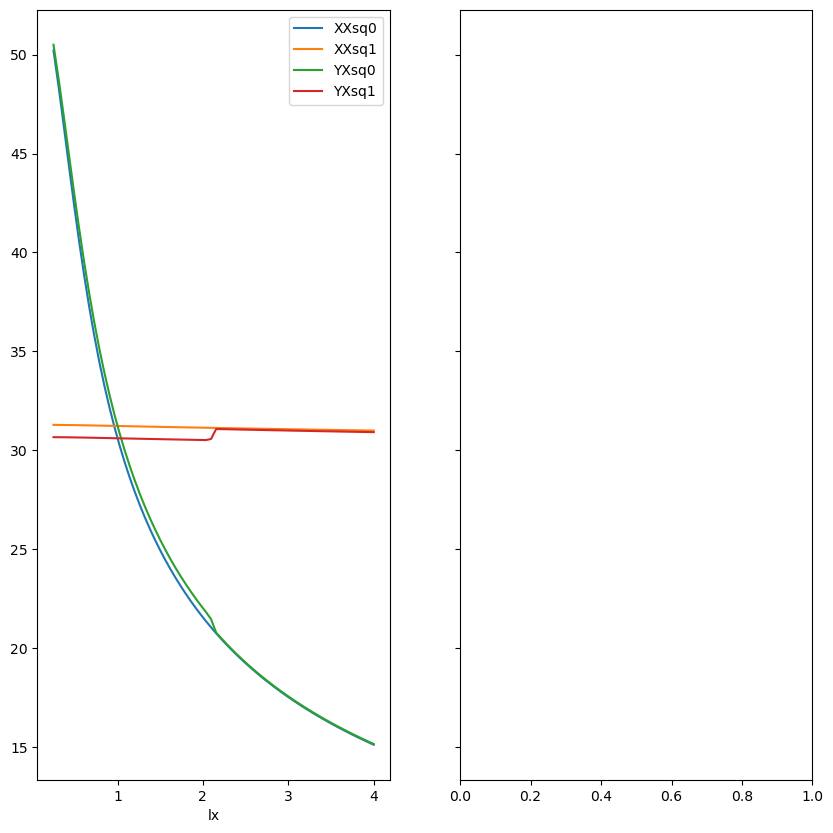

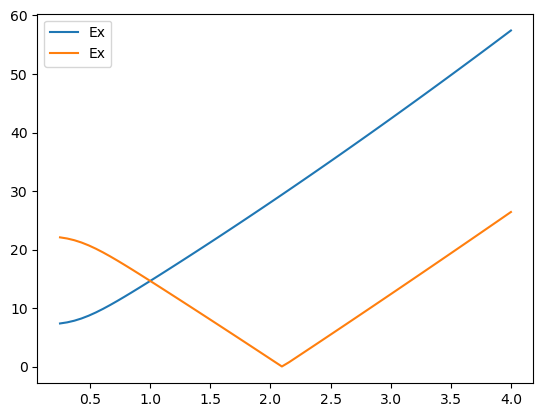

In [6]:
fig,axs = plt.subplots(ncols=2,figsize=(10,10),sharey=True)
E0 = 1/(nqcpfem.UNIT_CONVENTION['J to eV']*1000000) # unit_scale: 1muev
fig2,ax2 = plt.subplots()
ax2.plot(veridf['lx'],veridf['Ex']/E0,label='Ex')
ax2.plot(veridf['lx'],veridf['Ey']/E0,label='Ex')
ax2.legend()
veridf.plot('lx',[f'XXsq{i}' for i in range(2)],ax=axs[0])
veridf.plot('lx',[f'YXsq{i}' for i in range(2)],ax=axs[0])
veridf.plot('lx',[f'XYsq{i}' for i in range(2)],ax=axs[1])
veridf.plot('lx',[f'YYsq{i}' for i in range(2)],ax=axs[1])

In [7]:
I=(veridf['Ey']).argmin()
print((veridf['Ex'].iloc[I]-veridf['Ey'].iloc[I])/E0,veridf['lx'].iloc[I])


(29.342909681812586+0j) 2.095238095238095


In [43]:
bm = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge')
bm.add_z_confinement(1,'box',25e-9)
#bm.add_zeeman_term()#B=[1,1,1])



solver = PETScSolver(k=10,which='SM',sigma=0)
domain = RectangleDomain(Lx=300e-9,Ly=300e-9,Lz=0) 
domain.resolution = [300,300]
fem_model = FEniCsModel(bm,domain,0,('CG',1))


x,y,z = bm.position_symbols
omega_x,omega_y = sympy.symbols(r'\omega_x,\omega_y')
m = sympy.symbols('m')

V = 0.5*m*( (omega_x*x)**2 + (omega_y*y)**2 ) 

bm.add_potential(V)

bm.material_spec('Ge')

E0 = 1/(nqcpfem.UNIT_CONVENTION['J to eV']*1000000) # unit_scale: 1muev
omega_y_val = 2.5e11
omega_x_val = veridf['lx'].iloc[I]*omega_y_val


fem_model.band_model.parameter_dict[omega_y] = omega_y_val

fem_model.band_model.parameter_dict[omega_x] = omega_x_val


sol = solver.solve(fem_model)


(362404, 362404)


In [44]:
nqcpfem.plotting.plot_eigenvector(sol[1][0],fem_model)

INFO:trame_server.utils.namespace:Translator(prefix=None)
INFO:wslink.backends.aiohttp:awaiting runner setup
INFO:wslink.backends.aiohttp:awaiting site startup
INFO:wslink.backends.aiohttp:Print WSLINK_READY_MSG
INFO:wslink.backends.aiohttp:Schedule auto shutdown with timout 0
INFO:wslink.backends.aiohttp:awaiting running future
INFO:trame_server.controller:trigger(trigger__1)
INFO:trame_server.controller:trigger(trigger__2)
INFO:trame_server.controller:trigger(P_0x7f8c7dd5ca50_0Camera)
INFO:trame_server.controller:trigger(P_0x7f8c7dd5ca50_0AnimateStart)
INFO:trame_server.controller:trigger(P_0x7f8c7dd5ca50_0AnimateStop)
INFO:trame_client.widgets.core:js_key = class
INFO:trame_client.widgets.core:js_key = fluid
INFO:trame_client.widgets.core:js_key = class
INFO:trame_client.widgets.core:before: class = { 'rounded-circle': !P_0x7f8c7dd5ca50_0_show_ui }
INFO:trame_server.utils.namespace:(prefix=None) token {
INFO:trame_server.state:has({ => {) = False
INFO:trame_server.utils.namespace:(p

Widget(value='<iframe src="http://localhost:45225/index.html?ui=P_0x7f8c7dd5ca50_0&reconnect=auto" class="pyvi…

INFO:aiohttp.access:127.0.0.1 [29/Jan/2024:14:30:28 +0100] "GET /index.html?ui=P_0x7f8c7dd5ca50_0&reconnect=auto HTTP/1.1" 200 236 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.85.2 Chrome/114.0.5735.289 Electron/25.9.7 Safari/537.36"
INFO:aiohttp.access:127.0.0.1 [29/Jan/2024:14:30:28 +0100] "GET /vue.global.js HTTP/1.1" 200 253 "http://localhost:45225/index.html?ui=P_0x7f8c7dd5ca50_0&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.85.2 Chrome/114.0.5735.289 Electron/25.9.7 Safari/537.36"
INFO:aiohttp.access:127.0.0.1 [29/Jan/2024:14:30:28 +0100] "GET /assets/index-fdebfea4.js HTTP/1.1" 200 253 "http://localhost:45225/index.html?ui=P_0x7f8c7dd5ca50_0&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.85.2 Chrome/114.0.5735.289 Electron/25.9.7 Safari/537.36"
INFO:aiohttp.access:127.0.0.1 [29/Jan/2024:14:30:28 +0100] "POST /paravie

In [46]:
fenics_xsq_op = FEniCsObservable(Xsqop,fem_model)
fenics_ysq_op = FEniCsObservable(Ysqop,fem_model)

print(np.sqrt(fenics_xsq_op.mel(sol[1]))/1e-9)
print(np.sqrt(fenics_ysq_op.mel(sol[1]))/1e-9)

[21.29334006 21.29334006 21.14557532 21.14557532 20.97738187 20.97738187
 36.51170651 36.51170651 20.77170889 20.77170889 36.10222674 36.10222674
 35.63661186]
[30.82964127 30.82964127 53.05026418 53.05026418 67.56962112 67.56962112
 30.27335081 30.27335081 77.78944012 77.78944012 51.86937999 51.86937999
 65.93436532]


## Truncated SHO parameter Search


In [2]:
bm = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge')
bm.add_z_confinement(1,'box',25e-9)
#bm.add_zeeman_term()#B=[1,1,1])


from nqcpfem.solvers import IterativeSolver

single_solver = PETScSolver(k=10,which='SM',sigma=0)
solver = IterativeSolver(single_solver) # take previous states as next guess as they will be similar
domain = RectangleDomain(Lx=300e-9,Ly=300e-9,Lz=0) 
domain.resolution = [300,300]
fem_model = FEniCsModel(bm,domain,0,('CG',1))


x,y,z = bm.position_symbols
omega_x,omega_y = sympy.symbols(r'\omega_x,\omega_y')
m = sympy.symbols('m')

V = 0.5*m*( (omega_x*x)**2 + (omega_y*y)**2 ) 

Vmax = sympy.Symbol(r'V_m')
from nqcpfem.functions import SymbolicFunction
pot = SymbolicFunction(sympy.Piecewise((V,x**2+y**2 < 2*Vmax/(m*omega_x**2)),(Vmax,True)),'V(x)')

bm.add_potential(pot)

bm.material_spec('Ge')

E0 = 1/(nqcpfem.UNIT_CONVENTION['J to eV']*1000000) # unit_scale: 1muev
omega_y_val = 2e12
omega_x_val = omega_y_val


fem_model.band_model.parameter_dict[Vmax] = 1000
fem_model.band_model.parameter_dict[omega_y] = omega_y_val

fem_model.band_model.parameter_dict[omega_x] = omega_x_val


from nqcpfem.band_model import __POSITION_NAMES__
import sympy
X = sympy.symbols(__POSITION_NAMES__[0],commutative=False)
Xop = sympy.Array([[X,0,0,0],[0,X,0,0],[0,0,X,0],[0,0,0,X]])
Xsqop = sympy.Array([[X**2,0,0,0],[0,X**2,0,0],[0,0,X**2,0],[0,0,0,X**2]])
from nqcpfem.fenics import FEniCsObservable
fenics_x_op = FEniCsObservable(Xop,fem_model)
fenics_xsq_op = FEniCsObservable(Xsqop,fem_model)





In [14]:
from nqcpfem import _m_e
a=V.subs({omega_x:2e12,omega_y:2e12,x:100e-9,y:0,z:0,m:_m_e})
b=V.subs({omega_x:1e11,omega_y:1e11,x:10e-9,y:0,z:0,m:_m_e})
a,b

(1.8218767403e-20, 4.55469185075e-25)

In [16]:
from nqcpfem.parameter_search import DBParameterSearch

from nqcpfem import UNIT_CONVENTION

omega_range = np.linspace(1e11,2e12,16)
V_range = np.linspace(float(a),float(b),16) #/UNIT_CONVENTION['J to eV'] # well depth is 10 eV to 1e5 eV so we divide by conversion factor to get it in Joule


param_set = [{'omega':o, 'v':v} for v in V_range for o in omega_range]



def size_meaurement(omega,v):
    fem_model.band_model.parameter_dict[omega_x] =omega
    fem_model.band_model.parameter_dict[omega_y] =omega

    fem_model.band_model.parameter_dict[Vmax] = v
    # solve the system
    solution = solver.solve(fem_model)

    # extract only the numbers that we care about
    sq_vals = []
    last_E = -np.inf
    for eval,evec in zip(*solution):
        if not np.isclose(eval,last_E,rtol=1e-3,atol=0):
            # compute expectation value of X^2
            sq_vals.append(np.sqrt(fenics_xsq_op.mel(evec))*1e9)
            last_E = eval/E0
        else:
            pass
    print(sq_vals)
    return sq_vals
            

search = DBParameterSearch(param_set,size_meaurement,'size_meaurement_trunc.save')




In [17]:
search.run(True,True)

INFO:nqcpfem.parameter_search:running database parametersearch with 256 points
INFO:nqcpfem.parameter_search:evaluating at grid point 1/256


(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 2/256


[45.74309723753878, 45.74309719457673, 60.98041704492052, 60.98041704603289, 60.8888526103961, 60.888852610149534, 72.94639853497809, 72.94639853287441, 66.79953132139326, 66.7995313175564, 67.05104403400435, 67.05104404598858, 78.13472934893355]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 3/256


[32.48872579087163, 32.48872579087309, 45.58844812002913, 45.5884481187127, 45.64213790083666, 45.6421379007062, 55.386002420767845, 55.38600242071744, 54.75779695562761, 54.757796955617714, 55.11724810834702, 55.11724810836447, 62.82624587231802]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 4/256


[25.955949839708715, 25.955949839708772, 36.36376330945841, 36.3637633095109, 36.48265500223087, 36.48265500219391, 43.93324245742154, 43.933242463039306, 43.937782915364856, 43.937782933370315, 44.4660326157831, 44.46603261583461, 49.730642066610784, 49.77191268275943]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 5/256


[22.199739724113474, 22.199739724136492, 30.942384978288548, 30.942384978870937, 31.131296686894903, 31.13129668632185, 37.053522216535235, 37.05352222724787, 37.143544873913484, 37.14354487354942, 37.86529186865557, 37.865291868701554, 41.463642579363345, 41.49551946969435]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 6/256


[19.68921789833385, 19.6892178983256, 27.275210244908322, 27.275210244908106, 27.5442629649198, 27.544262964903986, 32.26720963947265, 32.26720963929767, 32.48005854643446, 32.48005854706555, 33.418215131163464, 33.41821513139032, 35.567316268889066, 35.599204652198665, 36.882394579969876, 38.02669473570173]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 7/256


[17.859757139912663, 17.859757139914045, 24.56506318554082, 24.565063185545117, 24.92306367306639, 24.923063673058156, 28.59621412501871, 28.596214125219593, 28.983706348345304, 28.983706348307138, 30.15670763204436, 30.156707632044707, 30.939190759815364, 31.09129337990061, 32.642525891091495, 34.173526529767386]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 8/256


[16.450482936205326, 16.450482936205024, 22.443773149262014, 22.443773149263585, 22.898084225332035, 22.898084225330447, 25.592285783164513, 25.592285782737747, 26.21245953650429, 26.212459536487184, 27.62781098449859, 27.627810984621075, 27.164296537019084, 27.526556683688856]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 9/256


[15.322009068476078, 15.322009068477005, 20.715395958645516, 20.71539595864678, 21.27176394455597, 21.271763944554134, 23.02934872517822, 23.029348725153433, 23.936273041946787, 23.936273041948024, 25.58926477185725, 25.589264771738932, 24.083529494876576, 24.680188627284203]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 10/256


[14.392177226222561, 14.392177226229924, 19.265281720926918, 19.26528172092904, 19.92760728709737, 19.92760728709475, 20.79009238029399, 20.790092380537626, 22.025110521141478, 22.025110526210238, 23.89799236897675]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 11/256


[13.608993894623357, 13.608993894623444, 18.02173391772715, 18.02173391772607, 18.79185137907591, 18.79185137907365, 18.814501005914817, 18.814501003821153, 20.399875409165176, 20.399875385366396, 22.462894219802966]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 12/256


[12.93773059664459, 12.937730596641188, 16.937670472903555, 16.937670472904045, 17.815190290305917, 17.81519029030565, 17.07129477819852, 17.071294778205537, 19.008159672697, 19.00815967206218, 21.22202844322798]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 13/256


[12.354185112966434, 12.354185112965144, 15.980969104080781, 15.98096910408093, 16.963225623394088, 16.963225623403513, 15.541359343212694, 15.541359343209745, 17.811652122976525, 17.811652121932617, 20.1300711885392]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 14/256


[11.840902670302262, 11.840902670283274, 15.128982298455457, 15.128982298452764, 16.211110453149836, 16.211110453145356, 14.209053180147162, 14.209053179290066, 16.779805438028507, 16.779805441761678, 19.149903165074353]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 15/256


[11.384933604516474, 11.384933604500814, 14.365228294219344, 14.365228294219092, 15.54037051517197, 15.540370515191698, 13.058361844859444, 13.058361847524505, 15.886937053595188, 15.886937037628325, 14.6531117655672, 18.244196281966108]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 16/256


[10.976439715119827, 10.97643971504119, 13.677305906823648, 13.677305906824385, 14.936928420843039, 14.936928420923858, 12.071659999628416, 12.071659998185483, 15.111043316082203, 15.111043267378903, 13.898722352548218]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 17/256


[10.607793982866268, 10.607793982863116, 13.055546233204254, 13.055546233204614, 14.389827564946739, 14.389827565034471, 11.229876338193348, 11.229876336960963, 14.433312795650146, 14.433312795355913, 13.257932088651515]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 18/256


[45.74309719457951, 45.743097187099174, 60.98041704494094, 60.980417044933255, 60.88885261042002, 60.888852610357866, 72.9463985348347, 72.94639853571753, 66.79953131882296, 66.7995313214916, 67.05104405702225, 67.05104407407458, 78.13472934876522]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 19/256


[32.48872579087705, 32.48872579087557, 45.58844811997628, 45.58844811875266, 45.64213790076194, 45.642137900187976, 55.38600242071691, 55.38600242054898, 54.75779677281741, 54.7577969556067, 55.11724829017519, 55.11724810835301, 62.826245872316484]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 20/256


[25.95594983970888, 25.95594983970899, 36.36376330946158, 36.363763309517935, 36.482655002238474, 36.482655002171946, 43.93324237925747, 43.9332424630502, 43.937782933348544, 43.93778293377332, 44.46603261582684, 44.46603261583624, 49.730642066605526]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 21/256


[22.199739724099395, 22.19973972411273, 30.942384979252147, 30.9423849788707, 31.131296687897173, 31.131296686896984, 37.053522216537935, 37.053522220428995, 37.14354487391091, 37.14354487678135, 37.865291868734154, 37.865291868701625, 41.46364257936404, 41.49551946969738]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 22/256


[19.68921789833342, 19.689217898337514, 27.275210244891824, 27.27521024490734, 27.54426296490386, 27.544262964899175, 32.267209639472284, 32.267209637417906, 32.48005854708899, 32.48005854048162, 33.41821512930956, 33.41821513142037, 35.567316268888234, 35.599204652200264, 36.882394579967006, 38.02669473570534]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 23/256


[17.859757139912578, 17.859757139913906, 24.565063185539596, 24.56506318554755, 24.9230636730662, 24.923063673057364, 28.596214125217674, 28.59621412555008, 28.98370634834293, 28.983706348361753, 30.156707632079364, 30.1567076320276, 30.93919075981623, 31.091293379899955, 32.64252589108976, 34.17352652977083]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 24/256


[16.45048293620537, 16.450482936205415, 22.44377314926245, 22.443773149260736, 22.89808422533467, 22.89808422533147, 25.592285782814177, 25.592285782738017, 26.212459536395983, 26.212459536504696, 27.627810984616133, 27.627810984605837, 27.164296537019972, 27.526556683692828]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 25/256


[15.322009068477044, 15.322009068473365, 20.71539595864555, 20.715395958646756, 21.271763944555527, 21.27176394455357, 23.029348725189518, 23.029348725152694, 23.93627304195347, 23.936273041964412, 25.589264772165503, 25.589264771649468, 24.083529494875037]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 26/256


[14.392177226215088, 14.392177226230116, 19.26528172092732, 19.265281720927444, 19.927607287096915, 19.927607287096375, 20.790092380537548, 20.790092377847756, 22.025110512973434, 22.025110541157037, 23.897992365888275]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 27/256


[13.60899389462317, 13.60899389462329, 18.021733917726287, 18.02173391772655, 18.79185137907129, 18.79185137907341, 18.814501005914664, 18.814501002174897, 20.39987545435743, 20.39987542647952, 22.462894220848302]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 28/256


[12.937730596711292, 12.937730596644617, 16.93767047290333, 16.937670472903978, 17.815190290304358, 17.815190290304603, 17.071294778205246, 17.0712947782529, 19.00815967070024, 19.00815967971495, 21.222028443188844]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 29/256


[12.354185112965597, 12.354185112965126, 15.980969104080245, 15.9809691040808, 16.963225623386514, 16.963225623394237, 15.54135934320988, 15.54135934321684, 17.81165212301643, 17.81165212341806, 20.130071188542466]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 30/256


[11.840902670257918, 11.840902670283246, 15.128982298452678, 15.12898229845299, 16.211110453144464, 16.21111045314897, 14.209053179269418, 14.20905317966808, 16.779805440035286, 16.779805437731312, 19.149903165074175]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 31/256


[11.384933604503296, 11.384933604500873, 14.365228294218909, 14.36522829421999, 15.540370515181566, 15.54037051516632, 13.05836184737312, 13.058361848058942, 15.886937063959426, 15.886937036265135, 14.653111765567326]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 32/256


[10.97643971511999, 10.976439714717724, 13.67730590682468, 13.67730590682426, 14.936928420861605, 14.936928420936349, 12.071659999591603, 12.07165999938776, 15.111043315580435, 15.111043375839547, 13.898722352548356]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 33/256


[10.607793982866308, 10.60779398289026, 13.055546233206647, 13.055546233204913, 14.389827564801424, 14.389827564924264, 11.22987633913172, 11.229876338345445, 14.433312795800841, 14.433312795296892, 13.257932088434444]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 34/256


[45.74309719458022, 45.743097236235634, 60.9804170448891, 60.980417045059745, 60.888852610428366, 60.888852610317336, 72.94639853443387, 72.94639853235705, 66.79953132144024, 66.79953131583201, 67.05104403776738, 67.05104404434742, 78.1347293495173]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 35/256


[32.488725790873005, 32.48872579087165, 45.5884481200734, 45.588448121374775, 45.64213790071569, 45.642137902889026, 55.38600242128277, 55.386002420714235, 54.75779695562156, 54.757796955627285, 55.11724810835248, 55.11724810835175, 62.82624587232637]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 36/256


[25.955949839709692, 25.95594983970988, 36.36376330946555, 36.36376330949637, 36.48265500223658, 36.48265500219369, 43.93324246302961, 43.93324246607573, 43.937782933345, 43.93778293324137, 44.466032615826556, 44.466032615833036, 49.73064206661276, 49.771912682758725]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 37/256


[22.199739724112682, 22.19973972408576, 30.94238497887167, 30.94238497825082, 31.131296686901372, 31.131296686432005, 37.05352221654566, 37.05352222925617, 37.14354487390119, 37.14354487448996, 37.86529186873657, 37.86529186870388, 41.46364257936345, 41.495519469693996]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 38/256


[19.68921789832675, 19.68921789833336, 27.27521024489948, 27.275210244900354, 27.5442629649119, 27.544262964921355, 32.267209640719756, 32.26720963947153, 32.48005855003265, 32.480058547065305, 33.41821513133212, 33.418215131283084, 35.567316268887836, 35.59920465219863, 36.882394579963396, 38.02669473570459]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 39/256


[17.8597571399143, 17.859757139914983, 24.565063185539113, 24.56506318557046, 24.923063673067745, 24.923063673083064, 28.596214125216434, 28.59621412472104, 28.983706348353966, 28.983706348343684, 30.1567076320485, 30.156707632037865, 30.939190759816338, 31.091293379898783, 32.64252589109102, 34.173526529769084]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 40/256


[16.45048293620462, 16.450482936205677, 22.443773149263205, 22.44377314926176, 22.898084225331125, 22.898084225325338, 25.592285782738422, 25.59228578273238, 26.212459536485955, 26.212459536534034, 27.627810984551036, 27.627810984632983, 27.164296537018966, 27.526556683691]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 41/256


[15.322009068477067, 15.32200906847536, 20.71539595864651, 20.715395958647076, 21.27176394455464, 21.271763944553562, 23.029348725153177, 23.02934872442471, 23.936273042644448, 23.93627304195053, 25.589264771770214, 25.589264771772086, 24.083529494876228]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 42/256


[14.392177226229355, 14.392177226229755, 19.265281720927423, 19.265281720928307, 19.927607287096862, 19.927607287095466, 20.790092380537946, 20.790092384833674, 22.025110537187583, 22.025110531226087, 23.89799236851517]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 43/256


[13.608993894623447, 13.60899389462369, 18.02173391772587, 18.021733917726273, 18.791851379072483, 18.791851379072998, 18.81450100591508, 18.814501006684633, 20.39987542714422, 20.399875426934596, 22.462894219033938]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 44/256


[12.937730596656825, 12.937730596644652, 16.93767047290351, 16.9376704729029, 17.815190290306074, 17.815190290306028, 17.071294778163995, 17.071294778209502, 19.008159670562083, 19.008159657713442, 21.222028443222726]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 45/256


[12.35418511296712, 12.354185112965233, 15.98096910408046, 15.980969104081648, 16.963225623404156, 16.9632256233983, 15.541359343210331, 15.541359343209669, 17.81165212251561, 17.811652121897566, 20.130071188544495]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 46/256


[11.840902670289417, 11.840902670283205, 15.128982298452007, 15.128982298452181, 16.211110453124935, 16.211110453161897, 14.209053178598136, 14.209053179363359, 16.779805440109996, 16.7798054461384, 19.149903165074885]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 47/256


[11.384933604480702, 11.384933604500837, 14.365228294219751, 14.36522829422103, 15.540370515173661, 15.540370515185232, 13.058361847452638, 13.058361845600018, 15.886937053870586, 15.886937059175875, 14.653111765567782]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 48/256


[10.976439715120057, 10.976439715167533, 13.677305906824493, 13.677305906825822, 14.936928420890906, 14.93692842085115, 12.071659999660723, 12.071659999604934, 15.111043314850745, 15.111043293076786, 13.898722352550793]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 49/256


[10.607793982866802, 10.607793982868431, 13.05554623320745, 13.05554623320704, 14.38982756441661, 14.389827564991652, 11.229876341523063, 11.229876338212096, 14.433312795286614, 14.43331279537574, 13.25793208963229]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 50/256


[45.74309720720319, 45.743097194561884, 60.98041704483804, 60.98041704506803, 60.88885261037171, 60.888852610328456, 72.94639853388435, 72.94639853497469, 66.79953132180279, 66.79953131942469, 67.05104405218697, 67.05104405753174, 78.13472934923941]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 51/256


[32.48872579087167, 32.48872579087361, 45.58844812001679, 45.5884481207151, 45.64213790068763, 45.64213789945687, 55.38600242570675, 55.38600242071688, 54.75779695561778, 54.757796955512184, 55.11724810831231, 55.11724810838153, 62.82624587234228, 62.729462565407346]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 52/256


[25.955949839708776, 25.955949839708932, 36.36376330946502, 36.36376330950056, 36.48265500222058, 36.48265500220068, 43.933242463046874, 43.93324247340646, 43.93778293289013, 43.937782933355976, 44.46603261582985, 44.4660326158264, 49.73064206661464]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 53/256


[22.199739724113172, 22.199739724082402, 30.942384978839225, 30.942384978875065, 31.131296686613204, 31.131296686901525, 37.053522216527, 37.053522214319315, 37.14354487391439, 37.143544868945135, 37.865291868223714, 37.8652918686997, 41.46364257936497, 41.495519469701975]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 54/256


[19.689217898333766, 19.68921789833396, 27.27521024484896, 27.275210244904635, 27.544262964906753, 27.544262964890308, 32.2672096394741, 32.26720963897065, 32.480058545310676, 32.480058547059436, 33.41821513124795, 33.418215131445244, 35.56731626888958, 35.59920465220123, 36.8823945799676, 38.02669473570742]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 55/256


[17.85975713991382, 17.859757139914016, 24.565063185540232, 24.565063185548397, 24.923063673028413, 24.92306367306702, 28.5962141254451, 28.596214125218772, 28.983706348346384, 28.983706348408397, 30.15670763205125, 30.156707632041538, 30.939190759815993, 31.091293379899348, 32.64252589109077, 34.173526529772246]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 56/256


[16.450482936205923, 16.450482936206043, 22.443773149262956, 22.4437731492632, 22.898084225331562, 22.898084225330873, 25.59228578268514, 25.592285782738003, 26.212459536530318, 26.212459536518985, 27.627810984534282, 27.627810984654843, 27.164296537019865, 27.52655668368791]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 57/256


[15.322009068478389, 15.322009068477254, 20.715395958646138, 20.715395958646834, 21.271763944555005, 21.271763944553754, 23.029348725124237, 23.029348725153717, 23.936273041955715, 23.936273041958362, 25.5892647718381, 25.58926477169371, 24.08352949487611, 24.680188627285904]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 58/256


[14.392177226229874, 14.392177226233542, 19.265281720927703, 19.265281720928918, 19.927607287096755, 19.927607287095974, 20.790092380537786, 20.790092380307826, 22.025110519674794, 22.025110524155334, 23.897992368327245]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 59/256


[13.608993894623113, 13.608993894623323, 18.021733917724735, 18.021733917726532, 18.791851379066657, 18.791851379068685, 18.814501005914938, 18.814501005536556, 20.399875410315943, 20.39987543716489, 22.462894218453137]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 60/256


[12.937730596644707, 12.937730596623798, 16.937670472903672, 16.937670472904262, 17.81519029030471, 17.815190290304198, 17.0712947782545, 17.071294778196677, 19.00815967230677, 19.008159678730216, 21.22202844322787]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 61/256


[12.354185112964302, 12.354185112965064, 15.980969104080794, 15.98096910407992, 16.963225623391068, 16.96322562339709, 15.541359343209503, 15.541359343214523, 17.81165212264803, 17.8116521226609, 20.130071188536814]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 62/256


[11.840902670327692, 11.840902670283274, 15.128982298454282, 15.12898229845213, 16.21111045312093, 16.211110453162465, 14.20905318039095, 14.209053179278895, 16.779805440290996, 16.779805460463376, 19.149903165075905]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 63/256


[11.384933604518144, 11.38493360450074, 14.36522829421959, 14.365228294217433, 15.540370515175889, 15.54037051519303, 13.05836184721413, 13.058361847158952, 15.886937069944988, 15.8869370544462, 14.653111765571788, 18.24419628197469]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 64/256


[10.97643971512085, 10.976439715038346, 13.677305906825909, 13.677305906829652, 14.936928420775336, 14.936928420926598, 12.071659999577482, 12.071660000357207, 15.111043314849702, 15.111043314525991, 13.898722352577378]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 65/256


[10.607793982872389, 10.607793982847344, 13.055546233236498, 13.055546233236557, 14.389827564851421, 14.389827565085962, 11.229876337933945, 11.229876338401322, 14.433312795684044, 14.433312795623994, 13.257932089034805]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 66/256


[45.74309723243755, 45.74309719458099, 60.98041704499666, 60.980417044980705, 60.88885261041611, 60.88885261036611, 72.94639853324344, 72.94639853570179, 66.79953132149542, 66.79953131771988, 67.05104403378778, 67.0510440528839, 78.13472934791736]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 67/256


[32.488725790872934, 32.48872579087209, 45.58844812171697, 45.58844812017189, 45.6421379005929, 45.64213790196968, 55.38600243547197, 55.38600242071701, 54.75779695561392, 54.7577969555218, 55.11724810833714, 55.117248108401284, 62.826245872331874, 62.729462565401334]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 68/256


[25.95594983971099, 25.955949839711145, 36.36376330945778, 36.363763309491254, 36.48265500224198, 36.48265500220482, 43.933242463917836, 43.93324246303213, 43.9377829333377, 43.93778293287496, 44.466032615829796, 44.46603261583045, 49.73064206661933]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 69/256


[22.199739724113208, 22.19973972411119, 30.942384978874827, 30.942384978496666, 31.131296686895908, 31.131296685701287, 37.0535222422866, 37.05352221652075, 37.14354487391343, 37.14354487310511, 37.86529186869357, 37.86529186869999, 41.46364257936536, 41.49551946969732]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 70/256


[19.689217898334288, 19.689217898346396, 27.27521024488316, 27.275210244908084, 27.54426296490905, 27.544262964912647, 32.26720964019608, 32.267209639476576, 32.480058548917874, 32.48005854705921, 33.41821513126447, 33.41821513138415, 35.567316268890025, 35.59920465219736, 36.88239457996646, 38.02669473569736]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 71/256


[17.859757139914173, 17.859757139914073, 24.565063185538026, 24.565063185541522, 24.92306367306935, 24.92306367306708, 28.59621412463114, 28.596214125220822, 28.98370634834158, 28.983706348344736, 30.15670763204167, 30.15670763204535, 30.939190759817894, 31.091293379900076, 32.64252589109039, 34.17352652977035]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 72/256


[16.450482936205713, 16.450482936205642, 22.44377314926214, 22.443773149263677, 22.898084225330884, 22.898084225329352, 25.592285782737168, 25.592285782736727, 26.212459536490417, 26.212459536497562, 27.627810984517303, 27.627810984675023, 27.164296537019542, 27.52655668369051]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 73/256


[15.322009068476945, 15.322009068461904, 20.715395958646727, 20.71539595864562, 21.271763944554994, 21.271763944555058, 23.02934872515294, 23.029348725165825, 23.93627304194151, 23.936273041952354, 25.589264771879186, 25.589264771768715, 24.08352949487569]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 74/256


[14.39217722622843, 14.39217722622988, 19.265281720927355, 19.265281720929092, 19.927607287096595, 19.927607287094418, 20.790092380537345, 20.790092381273944, 22.025110517147898, 22.025110529496224, 23.897992372190295]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 75/256


[13.608993894623518, 13.608993894623445, 18.02173391772649, 18.021733917726124, 18.79185137906676, 18.791851379068717, 18.814501005915062, 18.814501015163327, 20.39987542320045, 20.399875483959114]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 76/256


[12.937730596647379, 12.937730596644649, 16.93767047290354, 16.937670472904042, 17.81519029030498, 17.815190290306173, 17.07129477819941, 17.071294778223855, 19.008159670939882, 19.00815967241927, 21.22202844322155]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 77/256


[12.354185112967377, 12.354185112965167, 15.980969104080291, 15.980969104080685, 16.963225623404824, 16.963225623387455, 15.541359343210171, 15.541359343212829, 17.811652122251985, 17.81165212310267, 20.13007118853043]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 78/256


[11.840902670283688, 11.840902670283416, 15.128982298455332, 15.128982298453128, 16.211110453147004, 16.211110453154735, 14.209053179292951, 14.209053180475907, 16.779805441513588, 16.779805433015756, 19.149903165086176]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 79/256


[11.384933604458661, 11.38493360450231, 14.36522829422899, 14.365228294228968, 15.540370515182317, 15.540370515216463, 13.0583618470313, 13.058361847986928, 15.886937051415597, 15.886937057553892, 14.653111765627036, 18.24419628207277]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 80/256


[10.976439715131166, 10.9764397151316, 13.677305906890716, 13.677305906888764, 14.936928421121541, 14.936928420918548, 12.071659997464947, 12.071659999791843, 15.111043250066691, 15.111043315606778, 13.89872235287397]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 81/256


[10.607793982932547, 10.607793983025218, 13.055546233528087, 13.055546233528414, 14.38982756551745, 14.38982756571049, 11.22987633887812, 11.229876338708124, 14.433312797286359, 14.433312797277134, 13.2579320878321]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 82/256


[45.74309717983107, 45.74309719457974, 60.98041704484235, 60.980417045018406, 60.88885261042493, 60.88885261033355, 72.94639853579825, 72.94639853359095, 66.79953132146565, 66.79953131724177, 67.05104407358878, 67.05104406087882, 78.1347293477698]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 83/256


[32.48872579087204, 32.48872579087576, 45.588448120705856, 45.58844812005281, 45.64213790062943, 45.64213790113063, 55.3860024207152, 55.38600241951284, 54.757796955554795, 54.75779695560957, 55.11724810835019, 55.117248108355795, 62.8262458723324]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 84/256


[25.955949839709735, 25.955949839709778, 36.36376330945768, 36.363763309509764, 36.48265500223846, 36.482655002186135, 43.93324246053185, 43.93324246300471, 43.937782932919184, 43.93778293338137, 44.466032615827025, 44.46603261582986, 49.73064206661069]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 85/256


[22.199739724201557, 22.19973972411381, 30.94238497886964, 30.94238497868218, 31.131296686898608, 31.13129668591982, 37.05352221654653, 37.0535222195984, 37.143544873906826, 37.1435448733866, 37.865291868794955, 37.86529186870519, 41.46364257936558, 41.49551946970202]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 86/256


[19.689217898333833, 19.68921789833514, 27.275210244942485, 27.275210244907534, 27.54426296491018, 27.544262964897257, 32.26720963947101, 32.267209641497494, 32.48005854402797, 32.480058547059556, 33.41821513139186, 33.41821513124094, 35.567316268888, 35.59920465219869, 36.88239457996759, 38.02669473570313]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 87/256


[17.859757139914066, 17.859757139909288, 24.565063185543256, 24.565063185541938, 24.92306367308977, 24.923063673066878, 28.596214125217138, 28.596214124964458, 28.98370634835046, 28.983706348341844, 30.156707632036223, 30.15670763203718, 30.939190759814398, 31.091293379901728, 32.642525891091225, 34.173526529769966]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 88/256


[16.450482936205727, 16.45048293620548, 22.443773149261805, 22.44377314926246, 22.89808422533175, 22.898084225329235, 25.592285782663478, 25.592285782737505, 26.21245953648305, 26.21245953649332, 27.627810984478398, 27.627810984643325, 27.16429653702007, 27.52655668368889]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 89/256


[15.322009068476644, 15.322009068477078, 20.71539595864652, 20.71539595864584, 21.271763944555985, 21.271763944554507, 23.02934872515303, 23.02934872516803, 23.93627304195065, 23.936273041956767, 25.589264771933035, 25.589264771746997, 24.083529494875368]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 90/256


[14.392177226230084, 14.392177226252178, 19.265281720929167, 19.26528172092699, 19.92760728709618, 19.927607287095622, 20.790092381673055, 20.790092380538077, 22.02511051892434, 22.02511053246593, 23.897992369741413]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 91/256


[13.608993894623396, 13.608993894623312, 18.021733917726202, 18.02173391772673, 18.791851379095533, 18.79185137906845, 18.814501006708074, 18.81450100591495, 20.39987543929226, 20.3998754327911, 22.46289421826913]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 92/256


[12.937730596644602, 12.937730596694227, 16.9376704729037, 16.937670472904035, 17.81519029030739, 17.815190290306916, 17.071294778209495, 17.071294778208042, 19.008159672191756, 19.00815967390422, 21.222028443219223]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 93/256


[12.35418511296543, 12.35418511296529, 15.980969104082442, 15.980969104082792, 16.963225623389967, 16.96322562340407, 15.541359343216307, 15.541359343212504, 17.811652123469354, 17.81165212844618, 20.130071188539176]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 94/256


[11.840902670285908, 11.840902670282233, 15.128982298471495, 15.128982298472318, 16.21111045318301, 16.211110453177852, 14.209053179395934, 14.209053181636955, 16.779805440488214, 16.779805430100257, 19.14990316527324]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 95/256


[11.384933604526276, 11.38493360452376, 14.365228294358769, 14.36522829436093, 15.540370515412347, 15.54037051548793, 13.058361846249019, 13.058361847724829, 15.88693705304588, 15.88693704791872, 14.653111766344765, 18.24419628337266]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 96/256


[10.976439715262972, 10.976439715368132, 13.677305907587273, 13.677305907586112, 14.936928422191006, 14.936928422406096, 12.071660001740439, 12.071660000948203, 15.11104332058708, 15.111043319708585, 13.898722356104038]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 97/256


[10.607793983569909, 10.607793983569277, 13.055546236460014, 13.05554623645884, 14.389827571534969, 14.38982757184221, 11.229876343570597, 11.229876343455741, 14.4333128139704, 14.433312813651183, 13.257932101868356]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 98/256


[45.743097194582035, 45.7430971974789, 60.980417044851755, 60.98041704500536, 60.88885261043539, 60.88885261035393, 72.94639853498293, 72.94639853316751, 66.79953132156348, 66.79953131392995, 67.0510440906436, 67.05104402871612, 78.13472934868844]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 99/256


[32.488725790872955, 32.488725790871065, 45.588448119999725, 45.588448118774174, 45.642137900102234, 45.64213790081218, 55.38600242071803, 55.38600241957432, 54.75779695540363, 54.75779695560371, 55.11724810833411, 55.117248108337996, 62.82624587232106, 62.72946256547165]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 100/256


[25.95594983970943, 25.95594983970945, 36.363763309461184, 36.36376330950192, 36.482655002240904, 36.482655002188054, 43.93324245782377, 43.93324246306991, 43.93778293457755, 43.937782933400875, 44.46603261583127, 44.46603261582806, 49.73064206661023]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 101/256


[22.199739724113595, 22.199739723995965, 30.942384978929162, 30.942384978874223, 31.13129668786319, 31.131296686898846, 37.053522216302774, 37.05352221652318, 37.14354487532561, 37.143544873923155, 37.86529186868214, 37.86529186870007, 41.46364257936266, 41.49551946968758]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 102/256


[19.689217898333737, 19.68921789833413, 27.27521024491287, 27.275210244907125, 27.544262964907002, 27.544262964897356, 32.26720963947243, 32.26720963519792, 32.48005854088934, 32.480058547067514, 33.418215131358885, 33.41821513143172, 35.56731626888926, 35.59920465219727, 36.88239457996528, 38.02669473571757]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 103/256


[17.859757139914272, 17.859757139914052, 24.56506318554136, 24.565063185512084, 24.923063673068192, 24.92306367306053, 28.596214125156006, 28.596214125218722, 28.98370634833779, 28.983706348344466, 30.156707632043066, 30.156707632046434, 30.93919075981614, 31.091293379899618, 32.64252589109, 34.17352652977064]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 104/256


[16.450482936205667, 16.450482936205894, 22.443773149262807, 22.443773149262668, 22.89808422533267, 22.898084225329832, 25.592285782737513, 25.592285782810595, 26.212459536631723, 26.21245953649838, 27.627810984646576, 27.62781098451724, 27.164296537019407, 27.526556683684134]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 105/256


[15.322009068476913, 15.32200906847636, 20.715395958646756, 20.7153959586462, 21.271763944554785, 21.271763944554408, 23.02934872515302, 23.0293487251295, 23.936273041942375, 23.936273041952127, 25.589264771867516, 25.589264771565723, 24.083529494875865, 24.680188627285148]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 106/256


[14.39217722621755, 14.392177226230173, 19.265281720927646, 19.265281720929277, 19.927607287096844, 19.927607287095334, 20.790092381875905, 20.79009238053772, 22.025110518843334, 22.025110530066847, 23.897992368144056]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 107/256


[13.608993894623556, 13.608993894623651, 18.021733917726593, 18.021733917726415, 18.791851379072085, 18.79185137907553, 18.814501005915563, 18.81450100734318, 20.39987540378794, 20.399875442905277, 22.462894217200454]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 108/256


[12.93773059665137, 12.937730596644991, 16.937670472907328, 16.937670472907215, 17.815190290310944, 17.815190290309687, 17.071294778223976, 17.071294778216078, 19.0081596720156, 19.008159671768247, 21.222028443250135]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 109/256


[12.35418511297068, 12.354185112970576, 15.980969104123828, 15.980969104123357, 16.96322562348591, 16.963225623471786, 15.541359343328429, 15.541359343328926, 17.811652121789397, 17.811652124634566, 20.130071188964383]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 110/256


[11.840902670330719, 11.840902670334279, 15.12898229879703, 15.128982298795815, 16.211110453757918, 16.21111045382317, 14.209053181551543, 14.209053180121714, 16.77980543965307, 16.77980544802721, 19.149903168387834]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 111/256


[11.384933604850069, 11.38493360484478, 14.365228296216193, 14.3652282962161, 15.54037051881203, 15.540370518846967, 13.058361850792268, 13.058361850814148, 15.886937064909198, 15.886937064938941, 14.653111775582678]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 112/256


[10.976439716900174, 10.976439716633173, 13.67730591578029, 13.677305915779558, 14.936928440720802, 14.936928438359777, 12.071660016875223, 12.071660015089211, 15.11104336793033, 15.111043367440466, 13.898722390874495]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 113/256


[10.607793990300777, 10.607793990314748, 13.05554626575966, 13.055546265758812, 14.389827632244717, 14.389827632299408, 11.229876387938479, 11.229876388745025, 14.43331297387356, 14.433312972504302, 13.2579322122997]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 114/256


[45.743097194581026, 45.74309719756256, 60.98041704491964, 60.9804170449883, 60.88885261043206, 60.88885261034386, 72.94639853399715, 72.94639853620231, 66.79953131708925, 66.7995313213034, 67.05104404366912, 67.05104408154715, 78.13472934804665]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 115/256


[32.48872579086821, 32.48872579087094, 45.58844811932209, 45.58844811999133, 45.6421378983401, 45.642137900789976, 55.386002420719265, 55.386002421086516, 54.757796955627605, 54.757796955494555, 55.11724810831238, 55.11724810833731, 62.8262458723246]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 116/256


[25.955949839709277, 25.955949839709398, 36.36376330947565, 36.363763309502026, 36.48265500222232, 36.48265500218948, 43.933242460419905, 43.93324246300885, 43.93778293340349, 43.93778293385302, 44.46603261582877, 44.466032615830926, 49.73064206660769]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 117/256


[22.199739724095828, 22.199739724113712, 30.94238497886691, 30.942384979478245, 31.131296686901518, 31.131296688465742, 37.05352221653602, 37.05352221827312, 37.14354487391608, 37.14354487589575, 37.86529186869958, 37.86529186875575, 41.4636425793633, 41.49551946968702]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 118/256


[19.689217898333233, 19.68921789833499, 27.27521024488618, 27.275210244903672, 27.544262964910416, 27.544262964903666, 32.26720963938805, 32.26720963947551, 32.480058535905435, 32.48005854706316, 33.418215131275495, 33.418215131461416, 35.5673162688916, 35.599204652199, 36.88239457996798, 38.026694735703785]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 119/256


[17.85975713991443, 17.859757139915022, 24.565063185540293, 24.565063185538087, 24.923063673067865, 24.92306367307836, 28.596214125432002, 28.59621412521835, 28.983706348345756, 28.983706348371136, 30.15670763204453, 30.156707632047542, 30.939190759818125, 31.09129337989796, 32.64252589109109, 34.173526529768075]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 120/256


[16.450482936205496, 16.450482936205628, 22.443773149262558, 22.443773149261993, 22.898084225330475, 22.898084225330344, 25.592285782830754, 25.592285782738426, 26.21245953647315, 26.212459536529863, 27.627810984528384, 27.627810984588738, 27.164296537019172, 27.52655668368969]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 121/256


[15.32200906847676, 15.322009068475102, 20.715395958646607, 20.715395958646823, 21.271763944554365, 21.27176394455378, 23.029348725153127, 23.02934872514795, 23.93627304194739, 23.936273041954237, 25.58926477179488, 25.589264771753463, 24.08352949487474, 24.680188627286352]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 122/256


[14.392177226230167, 14.392177226216127, 19.26528172092748, 19.265281720928204, 19.92760728709774, 19.927607287095846, 20.790092380538656, 20.790092363556706, 22.02511050879414, 22.025110544474348, 23.89799236815311]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 123/256


[13.608993894623852, 13.608993894623827, 18.021733917733005, 18.021733917733457, 18.791851379085713, 18.791851379079205, 18.814501005943544, 18.814501003568655, 20.39987541053005, 20.39987543825964, 22.46289421841577]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 124/256


[12.937730596674736, 12.93773059665695, 16.937670473007326, 16.93767047300764, 17.815190290461018, 17.815190290464148, 17.071294778545457, 17.0712947786653, 19.008159672740423, 19.00815967274076, 21.222028444190613]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 125/256


[12.354185113095967, 12.354185113095886, 15.980969105027677, 15.980969105026606, 16.96322562489427, 16.96322562492226, 15.54135934569714, 15.54135934569383, 17.811652127561217, 17.811652131433867, 20.13007119736075]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 126/256


[11.840902671233954, 11.840902671223812, 15.128982304401926, 15.128982304403108, 16.211110463250446, 16.21111046325928, 14.20905319256961, 14.209053187952462, 16.779805486175714, 16.779805479716096, 19.149903218577204]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 127/256


[11.384933609651382, 11.384933609651258, 14.365228322174678, 14.365228322175557, 15.540370565630042, 15.540370565663638, 13.058361897184625, 13.05836190008106, 15.886937222962205, 15.88693722641162, 14.653111892716572, 18.244196525502147]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 128/256


[10.976439737202291, 10.97643973723864, 13.677306011137517, 13.677306011137683, 14.936928620941073, 14.936928621198737, 12.071660183527555, 12.0716601723268, 15.111043899312783, 15.111044037160877, 13.898722760383514]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 129/256


[10.6077940612122, 10.607794061212743, 13.055546556434173, 13.05554655643334, 14.38982822517616, 14.389828225675897, 11.229876820263968, 11.229876819513033, 14.433314463706138, 14.433314463526731, 13.257933213971251]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 130/256


[45.74309721426226, 45.74309719457907, 60.98041704487061, 60.98041704501379, 60.88885261044079, 60.8888526103214, 72.9463985343836, 72.94639853436104, 66.79953132151037, 66.79953131912943, 67.05104405933665, 67.05104403944685, 78.13472934822232]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 131/256


[32.48872579087377, 32.488725790871804, 45.588448119390215, 45.58844812002527, 45.64213789985592, 45.64213790078575, 55.38600242146469, 55.386002420716046, 54.75779695561535, 54.75779695559304, 55.11724810835647, 55.117248108358424, 62.82624587230466]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 132/256


[25.955949839709113, 25.955949839709273, 36.36376330946318, 36.36376330950703, 36.48265500223357, 36.482655002186135, 43.93324253317732, 43.93324246302236, 43.93778293338762, 43.937782933149634, 44.46603261582808, 44.46603261582918, 49.73064206661392]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 133/256


[22.19973972416154, 22.199739724113048, 30.942384979140318, 30.942384978873225, 31.131296686897105, 31.131296687634546, 37.05352221653194, 37.05352222120688, 37.143544873920305, 37.14354487399628, 37.865291868704375, 37.86529186869946, 41.46364257936575, 41.495519469693114]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 134/256


[19.689217898333315, 19.68921789833333, 27.27521024490238, 27.275210244926367, 27.544262964908597, 27.544262964903858, 32.26720963947319, 32.26720964107758, 32.48005854705851, 32.480058546652984, 33.418215131326434, 33.41821513137263, 35.56731626888717, 35.59920465219819, 36.88239457996747, 38.02669473570545]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 135/256


[17.859757139914755, 17.859757139914024, 24.565063185537767, 24.565063185540986, 24.9230636730646, 24.92306367306774, 28.59621412478195, 28.596214125218587, 28.98370634833776, 28.983706348346704, 30.156707632033537, 30.156707632053557, 30.939190759816317, 31.09129337989931, 32.642525891090116, 34.17352652976951]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 136/256


[16.450482936205713, 16.450482936206022, 22.443773149260412, 22.4437731492624, 22.89808422533116, 22.898084225331516, 25.59228578273767, 25.592285782763955, 26.212459536510323, 26.212459536504852, 27.627810984581178, 27.627810984576673, 27.164296537019624]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 137/256


[15.322009068476621, 15.322009068477293, 20.71539595864682, 20.71539595864763, 21.271763944555854, 21.271763944552806, 23.02934872518032, 23.02934872515591, 23.93627304195504, 23.936273041956955, 25.589264771931727, 25.58926477166461, 24.083529494888985, 24.68018862730615]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 138/256


[14.392177226236022, 14.392177226231484, 19.265281720943694, 19.265281720945662, 19.927607287117574, 19.927607287117198, 20.79009238061473, 20.790092388599245, 22.025110510390956, 22.025110535144062, 23.89799236807349]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 139/256


[13.608993894656205, 13.60899389465609, 18.021733918024143, 18.021733918023145, 18.791851379509513, 18.7918513795152, 18.81450100969415, 18.814501007025438, 20.39987542044315, 20.399875426005988]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 140/256


[12.93773059706329, 12.93773059704178, 16.937670475982593, 16.937670475983083, 17.81519029493731, 17.81519029493776, 17.07129478737555, 17.071294787417525, 19.008159697534328, 19.00815969790253, 21.222028470802442]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 141/256


[12.354185116083478, 12.354185116083643, 15.980969124938031, 15.980969124937756, 16.963225656503816, 16.963225656530216, 15.541359394569406, 15.541359394578635, 17.811652274135195, 17.811652275405315, 20.130071367870542]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 142/256


[11.840902687871408, 11.840902687891345, 15.128982400524285, 15.128982400525064, 16.211110624773152, 16.211110624782595, 14.2090533912066, 14.209053390111634, 16.779806087460987, 16.779806092931757, 19.149904012482647]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 143/256


[11.384933681342012, 11.384933681343043, 14.365228681932404, 14.365228681932447, 15.54037120619602, 15.540371206226137, 13.058362542187506, 13.058362544219996, 15.886939285914776, 15.886939294894873, 14.653113354281391]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 144/256


[10.9764399883876, 10.9764399882335, 13.677307111477056, 13.677307111476775, 14.936930700089, 14.936930700140772, 12.07166191234624, 12.071661911717682, 15.111049663909359, 15.1110496963419, 13.898726629436412]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 145/256


[10.60779480662221, 10.607794806621625, 13.05554941704831, 13.055549417047894, 14.389833964907195, 14.389833965884149, 11.229880921474958, 11.229880926727079, 14.433328272789261, 14.433328272706083, 13.257942263181102]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 146/256


[45.74309719457947, 45.743097232674714, 60.98041704492218, 60.980417044958955, 60.888852610446285, 60.88885261031427, 72.94639853130218, 72.94639853424329, 66.79953131814742, 66.7995313214393, 67.05104405202009, 67.0510440303506, 78.13472934857687]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 147/256


[32.48872579087217, 32.48872579087169, 45.58844811996398, 45.58844811919829, 45.64213790078574, 45.64213790077167, 55.38600242604054, 55.38600242071829, 54.75779695559392, 54.75779695561361, 55.11724810833335, 55.117248108379925, 62.826245872306515, 62.729462565474286]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 148/256


[25.955949839708836, 25.95594983970905, 36.36376330945905, 36.36376330950453, 36.48265500223593, 36.482655002191244, 43.933242463049595, 43.933242449107915, 43.93778293334932, 43.93778293330603, 44.46603261582673, 44.46603261583132, 49.73064206662156]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 149/256


[22.199739724113133, 22.19973972409132, 30.94238497887269, 30.942384978955058, 31.131296686895702, 31.131296685374867, 37.053522216534056, 37.05352221731692, 37.143544873922515, 37.1435448717649, 37.86529186870358, 37.865291868707914, 41.46364257936322, 41.49551946969398]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 150/256


[19.689217898333183, 19.689217898333858, 27.27521024488557, 27.275210244908944, 27.54426296493495, 27.54426296490043, 32.26720963532813, 32.26720963947621, 32.48005854446049, 32.4800585470627, 33.41821513118953, 33.41821513150932, 35.567316268890124, 35.599204652200505, 36.882394579968114, 38.0266947357055]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 151/256


[17.85975713991394, 17.859757139913206, 24.5650631855289, 24.56506318554144, 24.923063673067425, 24.92306367306949, 28.596214125217372, 28.596214125372622, 28.983706348327363, 28.983706348342242, 30.156707632048043, 30.156707632052715, 30.93919075981555, 31.091293379900023, 32.64252589109137, 34.173526529769326]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 152/256


[16.450482936205656, 16.450482936206328, 22.443773149262093, 22.443773149263155, 22.89808422533426, 22.898084225329562, 25.59228578274224, 25.592285782748775, 26.212459536517418, 26.212459536504742, 27.627810984515158, 27.627810984624396, 27.164296537053072, 27.526556683732604]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 153/256


[15.322009068481078, 15.322009068480833, 20.7153959586913, 20.715395958691797, 21.271763944613838, 21.271763944611187, 23.02934872538323, 23.029348725400375, 23.936273042501643, 23.936273042517747, 25.589264772277275, 25.58926477245947, 24.08352949611486, 24.68018862940062]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 154/256


[14.392177226340772, 14.39217722633876, 19.26528172197739, 19.265281721979548, 19.927607288517684, 19.92760728851438, 20.790092385058937, 20.79009241525636, 22.025110514873234, 22.025110538193385, 23.897992377808695]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 155/256


[13.60899389614102, 13.608993896141119, 18.02173393016263, 18.02173393016259, 18.79185139672536, 18.791851396704683, 18.814501051901548, 18.814501048418585, 20.399875533871764, 20.399875533882053, 22.46289432754229]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 156/256


[12.93773060942119, 12.93773060942033, 16.937670563012784, 16.937670563012475, 17.81519042460581, 17.815190424589606, 17.07129502791864, 17.07129502799572, 19.008160352217093, 19.00816037463871, 21.222029178720508]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 157/256


[12.354185187227927, 12.354185187228099, 15.980969557798794, 15.980969557798986, 16.96322633598734, 16.963226335968457, 15.541360386811471, 15.541360386825113, 17.811655178696743, 17.811655187172843, 20.130074744416664]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 158/256


[11.840902995656352, 11.840902995653364, 15.128984029333122, 15.128984029333626, 16.211113324285236, 16.211113324192844, 14.209056564670309, 14.209056564453505, 16.77981579002337, 16.779815798152583, 19.149916280617973]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 159/256


[11.38493474818295, 11.384934748183724, 14.365233614969616, 14.365233614970169, 15.540379852371059, 15.540379852423518, 13.058370913690332, 13.058370917673507, 15.886965685474882, 15.886965683019652, 14.653131270570785]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 160/256


[10.976443088788848, 10.976443088779105, 13.677319685926543, 13.677319685927756, 14.936954040378952, 14.936954040914149, 12.071680965774483, 12.071680968508652, 15.11111096809235, 15.111110967052895, 13.898766529703542]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 161/256


[10.607802623623012, 10.60780262359688, 13.0555773256228, 13.055577325620755, 14.389888884014084, 14.389888884659225, 11.229919523788038, 11.229919525722599, 14.43345395978188, 14.433453958223533, 13.258022580836025]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 162/256


[45.743097224878674, 45.74309719458238, 60.980417044919044, 60.980417044997075, 60.888852610388476, 60.888852610376354, 72.946398534276, 72.946398534528, 66.79953132149677, 66.79953131729528, 67.05104405553259, 67.05104403618348, 78.13472934799874]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 163/256


[32.48872579087369, 32.488725790872174, 45.588448122617216, 45.58844812013619, 45.64213790062914, 45.64213790259213, 55.38600242071558, 55.38600241997078, 54.75779695561709, 54.757796955692115, 55.11724810834482, 55.11724810834976, 62.826245872327085]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 164/256


[25.955949839709398, 25.955949839709614, 36.36376330948986, 36.36376330949346, 36.48265500224174, 36.48265500217069, 43.93324247624102, 43.93324246298063, 43.937782934122666, 43.93778293343551, 44.466032615826215, 44.46603261583596, 49.730642066606165, 49.771912682759684]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 165/256


[22.19973972409793, 22.199739724113222, 30.942384977382698, 30.9423849788684, 31.13129668689866, 31.131296686867444, 37.05352221399919, 37.053522216527874, 37.14354487329404, 37.14354487391219, 37.865291868703856, 37.865291868685404, 41.463642579364695, 41.49551946969248]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 166/256


[19.689217898319942, 19.68921789833367, 27.275210244909037, 27.275210244906663, 27.54426296490412, 27.544262964875045, 32.267209639019754, 32.26720963947266, 32.480058560321694, 32.480058547065084, 33.41821513122717, 33.41821513137057, 35.56731626888723, 35.599204652200584, 36.88239457996813, 38.02669473570746]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 167/256


[17.85975713991411, 17.859757139914528, 24.565063185541376, 24.565063185547967, 24.923063673060135, 24.923063673066522, 28.59621412523024, 28.596214126377912, 28.98370634833099, 28.983706348359256, 30.156707632076426, 30.15670763202796, 30.9391907599101, 31.091293379992674, 32.642525891139464, 34.17352652980901]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 168/256


[16.45048293621936, 16.450482936218357, 22.443773149426715, 22.44377314942532, 22.89808422553104, 22.898084225525352, 25.59228578376438, 25.59228578371537, 26.21245953924227, 26.212459538663754, 27.627810986161137, 27.627810986020503, 27.164296543430293, 27.526556693104844]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 169/256


[15.32200906897503, 15.32200906897687, 20.715395963666253, 20.715395963666346, 21.27176395099827, 21.27176395099618, 23.029348749559496, 23.02934874955189, 23.936273097442825, 23.936273097458503, 25.58926481548157, 25.589264815335536, 24.08352960552754, 24.680188818055854]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 170/256


[14.39217723413806, 14.392177234137849, 19.265281788266087, 19.26528178826828, 19.927607377328208, 19.92760737732574, 20.790092639441987, 20.79009263798977, 22.02511114185581, 22.025111160447043, 23.897992916342712]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 171/256


[13.608993964732132, 13.608993964731946, 18.02173443020908, 18.02173443020977, 18.791852097796887, 18.791852097848015, 18.81450259413776, 18.814502593899114, 20.399879531952234, 20.399879529555683, 22.462898149026724]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 172/256


[12.937731007030838, 12.9377310070302, 16.937673069562976, 16.93767306956326, 17.815194111157606, 17.81519411118092, 17.07130139430687, 17.071301394310815, 19.008177747294276, 19.008177747301325, 21.222047433185168]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 173/256


[12.354186878004638, 12.354186878005084, 15.980978835209406, 15.98097883520782, 16.96324067868129, 16.96324067860383, 15.541380175786363, 15.541380175704079, 17.81171174672002, 17.811711743809944, 20.130139620849462]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 174/256


[11.840908671060006, 11.840908671060125, 15.129011281938158, 15.12901128193697, 16.21115769490606, 16.21115769495002, 14.209106535709733, 14.209106540822322, 16.779963833258215, 16.779963834556685, 19.150100745830198]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 175/256


[11.384950589421557, 11.384950589420255, 14.365300491991299, 14.365300491991977, 15.540494719294266, 15.540494719321622, 13.058478880900418, 13.058478885510919, 15.887293697689282, 15.8872936975676, 14.653347166105537]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 176/256


[10.976481285719448, 10.976481285701196, 13.677462035958436, 13.677462035959365, 14.937212352256298, 14.937212352352907, 12.071887974261173, 12.071887972807922, 15.111749799619027, 15.111749799541931, 13.899172784362907]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 177/256


[10.60788447572112, 10.607884475734254, 13.055847599261083, 13.055847599261424, 14.39040765898361, 14.390407659269357, 11.230281148694038, 11.230281148504318, 14.4345783072053, 14.43457830753775, 13.25872972785478]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 178/256


[45.74309718358575, 45.74309719457839, 60.98041704495409, 60.98041704503023, 60.88885261036674, 60.888852610347364, 72.94639853542253, 72.94639853525582, 66.79953131452314, 66.79953132178724, 67.05104404398953, 67.05104409557849, 78.13472935035439]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 179/256


[32.48872579087304, 32.488725790871975, 45.58844811946822, 45.5884481201819, 45.64213790071578, 45.64213790366361, 55.38600242071938, 55.38600242184439, 54.75779695576062, 54.757796955603574, 55.117248108348164, 55.117248108355895, 62.82624587231287, 62.729462566271664]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 180/256


[25.95594983970991, 25.955949839710033, 36.363763309469334, 36.36376330950432, 36.48265500222268, 36.482655002196076, 43.93324246305183, 43.933242540943084, 43.93778293337346, 43.93778293324418, 44.46603261582844, 44.466032615831004, 49.73064206661838]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 181/256


[22.199739724113545, 22.199739724155076, 30.942384978876078, 30.94238497887558, 31.131296686892526, 31.131296688185913, 37.0535222165475, 37.05352222185184, 37.14354487391392, 37.14354487457211, 37.86529186870406, 37.86529186862745, 41.46364257936404, 41.495519469686236]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 182/256


[19.689217898333943, 19.68921789834997, 27.275210244893366, 27.2752102449107, 27.544262964911493, 27.544262964902828, 32.2672096396697, 32.267209639497786, 32.480058546651165, 32.48005854708884, 33.4182151314179, 33.41821513140695, 35.56731626912652, 35.599204652427694, 36.88239458001997, 38.02669473575106]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 183/256


[17.859757139983437, 17.859757139983323, 24.56506318639204, 24.56506318582197, 24.923063674069027, 24.923063673728187, 28.59621412530462, 28.596214131532303, 28.98370635499269, 28.983706359929347, 30.15670763154492, 30.15670763922876, 30.939190809379042, 31.091293436326854]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 184/256


[16.450482939831403, 16.45048293983137, 22.443773186455093, 22.44377318645565, 22.89808427083445, 22.89808427083225, 25.59228598076388, 25.59228598062729, 26.212459961270717, 26.212459958761606, 27.62781129196606, 27.627811292018535, 27.164297624878312, 27.52655830280709]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 185/256


[15.322009132046905, 15.322009132046883, 20.715396508329135, 20.715396508329707, 21.271764643372915, 21.271764643372656, 23.029351040142632, 23.029351040148427, 23.93627830692018, 23.936278306950033, 25.589268950597596, 25.58926895267821, 24.083538845885045, 24.680204786660237]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 186/256


[14.39217779751926, 14.392177797518796, 19.26528594612089, 19.265285946121033, 19.9276128810946, 19.927612881095193, 20.79010673171232, 20.790106710063515, 22.025144984803156, 22.02514507237369, 23.898022353376124]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 187/256


[13.60899713180706, 13.60899713180727, 18.021754627708113, 18.021754627709296, 18.791879995668666, 18.79187999562235, 18.814558758161656, 18.81455875727719, 20.40002152269513, 20.40002152951941, 22.463033107415935]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 188/256


[12.937743765031875, 12.937743765029648, 16.937743992023336, 16.937743992024423, 17.815296540180444, 17.815296540212486, 17.07146627458066, 17.071466274582995, 19.00861380465721, 19.00861380355847, 21.22249960884138]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 189/256


[12.354227011957825, 12.354227011957748, 15.98117469046312, 15.98117469046327, 16.963537024162296, 16.963537024241827, 15.541768706845328, 15.541768706910647, 17.81277832890361, 17.812778323301814, 20.13134314753449]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 190/256


[11.841013231897454, 11.84101323190046, 15.129461838008854, 15.129461838008963, 16.211873280851957, 16.211873280913643, 14.209886045649109, 14.209886046623723, 16.782165149061345, 16.78216515709165, 19.152795182301297]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 191/256


[11.385185808615699, 11.385185808614287, 14.366199898202591, 14.36619989820009, 15.541996818823282, 15.541996818049977, 13.059866445246913, 13.059866449349053, 15.891287670233814, 15.891287672101981, 14.65593166777774, 18.249967548625598]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 192/256


[10.976952276567873, 10.97695227656901, 13.679067068589191, 13.67906706858892, 14.940035754910959, 14.940035754811005, 12.074143700792472, 12.074143700988495, 15.118313225088604, 15.118313224979392, 13.903317419173066]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 193/256


[10.6087431986924, 10.608743198693412, 13.058465829363811, 13.058465829362596, 14.395265859147372, 14.395265858803167, 11.233700312702444, 11.233700312115351, 14.444565958231998, 14.444565958035268, 13.265020068696716]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 194/256


[45.74309722310404, 45.743097194581665, 60.98041704489525, 60.98041704493658, 60.88885261050279, 60.8888526103228, 72.94639853324321, 72.9463985340322, 66.7995313214996, 66.79953131890736, 67.05104404180392, 67.05104404722222, 78.13472934825234]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 195/256


[32.48872579087394, 32.48872579087217, 45.58844812008361, 45.5884481222913, 45.64213790115427, 45.642137900648606, 55.38600242047176, 55.386002420717, 54.75779695562086, 54.75779695565615, 55.11724810830799, 55.1172481083761, 62.826245872328606, 62.72946256544641]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 196/256


[25.95594983970963, 25.955949839709753, 36.363763309466584, 36.36376330950007, 36.48265500219399, 36.48265500222843, 43.93324246309249, 43.93324246307784, 43.93778293332173, 43.9377829335722, 44.466032615830876, 44.46603261582891, 49.730642066599934]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 197/256


[22.199739724095227, 22.199739724113556, 30.942384978866606, 30.942384978209137, 31.13129668690895, 31.131296686244802, 37.05352221473868, 37.05352221659099, 37.14354486087142, 37.143544873952486, 37.86529186881241, 37.86529186870708, 41.463642579880116, 41.495519470210674]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 198/256


[19.68921789895401, 19.689217898952034, 27.27521025238844, 27.275210252396842, 27.544262973394247, 27.544262973405914, 32.267209711402444, 32.267209706850544, 32.48005864658512, 32.480058648023295, 33.41821517813109, 33.41821517826326, 35.56731688166545, 35.59920523152775, 36.882394908541265, 38.02669501060923]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 199/256


[17.859757193120686, 17.85975719312081, 24.56506372565853, 24.565063725659588, 24.92306430470708, 24.92306430471144, 28.59621713594863, 28.596217135343156, 28.983712474684896, 28.983712465872255, 30.15671176090307, 30.15671176813412, 30.93921142670617, 31.091317253957527]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 200/256


[16.450483898318137, 16.450483898316318, 22.443781302510747, 22.44378130251533, 22.898094079573877, 22.89809407956642, 25.59232178502884, 25.59232178506769, 26.212536338741895, 26.212536338760547, 27.627867410785292, 27.627867410722263, 27.164465645009038, 27.526807619627714, 29.268539410278137, 31.169035185782462]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 201/256


[15.322017166471774, 15.322017166471152, 20.715454429212958, 20.71545442921467, 21.271837106253823, 21.271837106273203, 23.029558614271508, 23.029558614288764, 23.936740470564725, 23.936740470635684, 25.58963757261566, 25.589637571215043, 24.08426694489673, 24.681450438608522]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 202/256


[14.392218588235465, 14.392218588238576, 19.26554024252665, 19.265540242529003, 19.927942773926592, 19.927942773924695, 20.79086117644064, 20.79086117779269, 22.026894793889852, 22.026894873256122, 23.899536830276066]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 203/256


[13.60914364950455, 13.60914364950503, 18.022554191448734, 18.02255419144771, 18.79295745538125, 18.792957455347537, 18.81655611880695, 18.81655611453574, 20.40483554298916, 20.404835523026968, 22.467554749341073]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 204/256


[12.938154311245372, 12.938154311245095, 16.939724352787703, 16.939724352787646, 17.81807372476846, 17.81807372470143, 17.07570377718464, 17.07570377687337, 19.019186926966952, 19.019186942413718, 21.233276226378038]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 205/256


[12.355183988458673, 12.355183988459064, 15.985287818275355, 15.985287818275314, 16.969551207734657, 16.969551207646003, 15.549447505063386, 15.549447505076573, 17.83250611241836, 17.832506158663957, 20.153152827821895]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 206/256


[11.842952604818523, 11.842952604817963, 15.136938689806588, 15.136938689807804, 16.223294929172145, 16.223294929029265, 14.222303850964074, 14.222303837505024, 16.814807483575514, 16.814807483665255, 19.19191548857627]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 207/256


[11.388711355107276, 11.388711355107302, 14.37846128604495, 14.37846128604525, 15.561604386354663, 15.56160438659437, 13.07834235446467, 13.078342353452582, 15.94067483070898, 15.940674818679335, 14.688408061050838, 18.314193272806865]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 208/256


[10.98283399600456, 10.98283399600646, 13.697612280470233, 13.697612280471228, 14.971141032059782, 14.971141032098444, 12.099977828579203, 12.09997783468372, 15.188185590768919, 15.188185591402211, 13.94861004600241]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 209/256


[10.61790144101773, 10.617901441016231, 13.084763083950788, 13.084763083944155, 14.441612134803112, 14.441612138004372, 11.2681508346277, 11.268150833028963, 14.538544534364854, 14.53854453432627, 13.32614893073761]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 210/256


[45.743097177687616, 45.74309719458315, 60.980417044894956, 60.980417045024325, 60.88885261042376, 60.888852610321734, 72.94639853448733, 72.94639853350542, 66.79953131859303, 66.79953132149522, 67.05104407712952, 67.05104406026584, 78.13472934841882]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 211/256


[32.48872579087323, 32.48872579087142, 45.58844812036057, 45.588448120089886, 45.6421379006228, 45.642137902251335, 55.38600241990639, 55.386002420714696, 54.757796955621956, 54.75779695562806, 55.1172481083448, 55.11724810836621, 62.8262458723223]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 212/256


[25.955949839709536, 25.955949839709636, 36.363763309453354, 36.3637633094999, 36.482655002201575, 36.48265500224046, 43.93324247198639, 43.93324246302986, 43.93778293336665, 43.937782933284254, 44.46603261582805, 44.4660326158316, 49.7306420666375, 49.77191268278521]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 213/256


[22.199739744490344, 22.199739744483626, 30.942385209178127, 30.942385209365355, 31.131296937921935, 31.13129693803143, 37.05352457101953, 37.05352454427349, 37.14354766685099, 37.14354766954107, 37.865292811353584, 37.86529281139189, 41.46366249257684, 41.495538948529635, 42.47093139158367]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 214/256


[19.689220409492897, 19.689220409489735, 27.27523393338454, 27.275233933333606, 27.544289439786144, 27.544289439884768, 32.267338616260126, 32.26733862764819, 32.480304150084606, 32.48030417100939, 33.418373249880695, 33.418373250457456, 35.568330395160466, 35.600096034502656, 36.88338262244695, 38.02746445214332]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 215/256


[17.85979577266496, 17.85979577266677, 24.565364746183693, 24.565364746190667, 24.923409514752073, 24.923409514751143, 28.59751811443681, 28.597518115807148, 28.986298329155538, 28.986298328862606, 30.15850276799592, 30.158502767989162, 30.946391474617695, 31.09937365178043, 32.65196802673865, 34.18088225540856]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 216/256


[16.450741404268616, 16.450741404273497, 22.445493416006965, 22.445493416009153, 22.9001103103941, 22.900110310388293, 25.59846317966306, 25.59846317958004, 26.225064446366563, 26.225064445881717, 27.637157142530704, 27.637157142360824, 27.188426502850778, 27.561538158189844, 29.31031014504478, 31.20223438150991]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 217/256


[15.323053952003006, 15.323053952003226, 20.721469803826217, 20.721469803828594, 21.279118713365236, 21.27911871336484, 23.047945055097113, 23.047945055100104, 23.975223366569157, 23.97522336666775, 25.620192445378912, 25.62019244618261, 24.140221037594515, 24.77454268676459, 26.638477623883826, 28.835938606921143]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 218/256


[14.39521985521629, 14.395219855216244, 19.281021206247182, 19.28102120623526, 19.947229237109653, 19.947229237174597, 20.83195936462281, 20.831959363620363, 22.11539977276455, 22.115399788279387, 23.97489507994169]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 219/256


[13.616070167889678, 13.616070167888804, 18.054800035023, 18.054800035023227, 18.834363805639015, 18.834363805625916, 18.892060288118106, 18.892060285365293, 20.572815803163373, 20.572815805572432, 22.621328565772483]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 220/256


[12.951749426110696, 12.951749426110652, 16.997566477619447, 16.997566477599356, 17.894765507971208, 17.894765507555423, 17.19686033209637, 17.19686032795165, 19.298945819775717, 19.29894582476732, 21.509521216727922]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 221/256


[12.37886489394479, 12.378864893941422, 16.078352036599636, 16.078352036601284, 17.097219973353212, 17.097219973332706, 15.72628999004383, 15.726289990031713, 18.258650973383492, 18.258650973386104, 20.608959753223775]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 222/256


[11.8806394725512, 11.88063947255164, 15.27502003690035, 15.275020036896079, 16.419727560465994, 16.419727561754108, 14.463673781992608, 14.46367377963147, 17.42645941478447, 17.426459419914035, 19.905206566031254]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 223/256


[11.444648407864584, 11.44464840786502, 14.571147780314142, 14.571147780314009, 15.846540211681807, 15.846540210922992, 13.39223330389689, 13.392233304053187, 16.78692403274954, 16.786924033190058, 15.32176640487384, 19.40382075363932]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 224/256


[11.06142631757156, 11.061426317551998, 13.954159297333362, 13.95415929732867, 15.366467626692742, 15.366467626465164, 12.493822832547645, 12.493822832524916, 16.337891695092974, 16.337891672137538, 14.79814489258223]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 225/256


[10.723592210829999, 10.723592210831054, 13.414237738188023, 13.414237738079505, 14.972007713301121, 14.972007713306429, 11.748985561009803, 11.74898555441002, 16.098348372568502, 16.09834837236512, 14.481897153471362]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 226/256


[45.743097194583186, 45.74309718710816, 60.98041704489166, 60.980417044958294, 60.88885261045707, 60.8888526103301, 72.9463985343884, 72.94639853567459, 66.7995313215824, 66.79953131985735, 67.05104404920036, 67.05104407677031, 78.13472934844546]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 227/256


[32.4887257908685, 32.4887257908743, 45.588448121622704, 45.58844812016504, 45.64213790059894, 45.6421379035659, 55.38600242071742, 55.38600242221989, 54.75779695562535, 54.75779695558694, 55.117248108294106, 55.11724810836051, 62.826245872331675]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 228/256


[25.955964209523703, 25.955964209523838, 36.36389412903863, 36.36389412908365, 36.48279096511512, 36.482790965081705, 43.93445404032517, 43.934454040320354, 43.93889468658514, 43.93889468655504, 44.466396655779015, 44.46639665577263, 49.73802231932672, 49.77926553794749]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 229/256


[22.200752358952556, 22.200752359036855, 30.950031465952915, 30.950031465951273, 31.139397497370496, 31.139397497359347, 37.09224689006088, 37.09224689009004, 37.20136357571986, 37.20136357564191, 37.9039955056205, 37.903995505618475, 41.706168423114335, 41.70330141069546]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 230/256


[19.69715998692881, 19.69715998692863, 27.326088512862373, 27.326088512871358, 27.598889211919094, 27.598889211923215, 32.4733201417245, 32.473320104269696, 32.83665513509325, 32.836655123239346, 33.65792780718161, 33.657927816917336, 36.96626358176914, 36.69728798304506, 38.03508027113276, 38.95472252299814]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 231/256


[17.889734650860394, 17.889734650858717, 24.737753220918794, 24.737753220902476, 25.110895397429225, 25.110895397432138, 29.26248959196183, 29.262489573802124, 30.153099842158586, 30.153099844120543, 30.975513533790984, 30.97551353391972, 36.4941552698525, 35.5835446523338, 37.156045416856934, 38.16201493382153]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 232/256


[16.52671812679346, 16.52671812679368, 22.85850890885137, 22.85850890716988, 23.355356120263686, 23.35535611270942, 28.155878357335723, 28.155878357293783, 28.400199506830557, 28.400199506802778, 29.87218404920763, 29.8721840492881, 49.20883746851589, 51.461064003522736]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 233/256


[15.475023714895766, 15.475023714896977, 21.535821729984768, 21.535821729983528, 22.190200273288188, 22.19020027328987, 31.839356547796378, 31.839356545549165, 26.818136597511728, 32.15555449478312]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 234/256


[14.655937138994483, 14.655937138987463, 20.71900939703951, 20.719009397400264, 21.585242103316144, 21.585242103732153, 42.86398812837612, 42.863988132037264, 32.04200356285909, 32.042003714249375, 72.22864065601293, 73.32613318837276, 50.45040059786237, 73.72404925273803, 78.53438171631475]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 235/256


[14.019067658978813, 14.019067659276619, 20.459358870928547, 20.45935887531261, 21.64009713629417, 21.64009713637619, 57.73073211482152, 73.4098254598054, 74.24486168251762, 62.33214947187674, 64.77815519042441]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 236/256


[13.530444818123256, 13.530444818623216, 20.98704438190601, 20.987044374591658, 22.71724585204025, 22.717245891005287, 64.04950500086146, 73.88274748349983, 74.66125704359075, 76.10445231333725]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 237/256


[13.166426281943432, 13.16642628026948, 22.98544038886923, 22.985440345140127, 25.885580721867836, 25.885580721802686, 66.24734909412236, 66.24734915314885, 74.11239147445214, 74.1123914695018, 74.79652107974368, 74.79652111522456, 78.24186869328719]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 238/256


[12.910430953747593, 12.910430953747634, 28.371952160400273, 28.371952156727602, 33.72096069470075, 33.72096057925834, 67.14833435902919, 67.14833440467251, 73.71197639426306, 73.71197644695633]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 239/256


[12.750805945712942, 12.750805945713017, 40.11243891783576, 40.11243888853805, 46.789009011087636, 46.78900771725813, 67.57920075521322, 67.57920078159056, 70.96284637665315, 79.20193170551407]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 240/256


[12.679722867476013, 12.67972286747626, 53.307901265058746, 53.307901666423675, 56.93524772452885, 56.93524746035204, 67.81932953696459, 67.81932992671933, 79.35448255140706, 67.43900440485677]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 241/256


[12.69233596891776, 12.692335968909108, 60.46433215572562, 60.46433227352024, 67.9808190379222, 67.98081880948945, 61.85907976082112, 61.8590797447045, 79.44312516496487, 79.44312515232475, 70.26313395616772]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 242/256


[54.21323988933944, 54.2132398924222, 68.24445821855943, 68.24445825450383, 68.07973743811213, 68.07973738752368, 79.66491608204525, 79.66491607957391, 70.37458682911016, 70.3745868282233, 70.46417417660123, 70.46417417879225]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 243/256


[54.21486909735039, 54.214869097351254, 68.24447263853668, 68.24447264614994, 68.07975187587475, 68.07975187594046, 79.66491818821383, 79.66491818854949, 70.37531986266451, 70.37531986037813, 70.46417425605334, 70.46417425667043, 81.79852451228061]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 244/256


[54.215102949285246, 54.215102949352584, 68.24447311961808, 68.24447312127394, 68.07975235374977, 68.07975234828126, 79.66491849217026, 79.66491847956694, 70.37542979260945, 70.37542983858201, 70.46417408398364, 70.46417414820073, 81.79852493116553, 81.79852492218191, 81.32369017098202]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 245/256


[54.215178387942885, 54.21517838300904, 68.24447318945514, 68.24447318934216, 68.07975242554105, 68.07975242292139, 79.664918605585, 79.66491859177282, 70.37546551130865, 70.37546550772498, 70.4641740965251, 70.46417409737276, 81.79852495682928, 81.7985249534729, 81.323690198482, 81.32369018080287]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 246/256


[54.215211566275315, 54.21521156437747, 68.24447320813178, 68.24447320637346, 68.07975244102398, 68.07975244014611, 79.66491863569605, 79.66491861976169, 70.37548126008505, 70.37548126258919, 70.46417407781173, 70.46417407507582, 81.79852494080588, 81.79852493801816, 81.32369024953866, 81.32369023203769]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 247/256


[54.21522848363449, 54.21522848840309, 68.2444732158261, 68.24447321331371, 68.07975244469566, 68.0797525272808, 79.66491864118902, 79.66491863555798, 70.37548930211763, 70.3754893015785, 70.46417406385643, 70.46417406430692, 81.79852496533233, 81.79852498439035, 81.32369021151794, 81.32369019559808]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 248/256


[54.21523935363019, 54.21523935470985, 68.2444732158879, 68.24447321609694, 68.07975244867643, 68.07975244637692, 79.66491865580035, 79.66491863452266, 70.37549446634547, 70.37549447037095, 70.46417406003978, 70.46417405810915, 81.79852496537487, 81.79852496503742, 81.32369021099568, 81.32369021197708]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 249/256


[54.21524609473882, 54.21524609424591, 68.24447321745347, 68.24447321793116, 68.07975244967501, 68.07975244467417, 79.66491864893818, 79.66491866466218, 70.37549767724492, 70.37549767633384, 70.46417405222176, 70.464174052255, 81.79852497588713, 81.7985249632018, 81.32369020790189, 81.32369022636348]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 250/256


[54.21525023041446, 54.21525023063565, 68.24447321764029, 68.24447321794796, 68.0797524503316, 68.07975244864608, 79.66491866748899, 79.66491866854189, 70.37549963907894, 70.37549964578349, 70.46417405310035, 70.46417405211906, 81.79852496600381, 81.7985249630533, 81.32369021663219, 81.32369021675451]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 251/256


[54.215253414089084, 54.215253413863444, 68.24447321840381, 68.24447321736355, 68.0797524558288, 68.0797524502104, 79.66491867562563, 79.66491870655022, 70.37550116156557, 70.37550116057179, 70.46417404634917, 70.46417404738327, 81.79852496000092, 81.7985249649144, 81.32369021574131, 81.32369021798478]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 252/256


[54.21525599748037, 54.21525599707398, 68.24447321868239, 68.24447321852142, 68.07975245061884, 68.07975245044493, 79.664918675765, 79.66491866852668, 70.37550239064127, 70.37550238733483, 70.46417404917955, 70.46417404333037, 81.79852496574789, 81.79852496407166, 81.32369021158432, 81.32369021217073]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 253/256


[54.21525790663498, 54.215257906428, 68.24447321860482, 68.24447321850411, 68.07975245031743, 68.07975245082427, 79.66491867905745, 79.66491867874599, 70.37550329980142, 70.37550329894543, 70.46417404315405, 70.46417404393623, 81.79852496498567, 81.79852496516213, 81.323690214108, 81.32369021388247]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 254/256


[54.2152595072356, 54.21525950787515, 68.24447321895894, 68.24447321897271, 68.07975245080723, 68.07975245069765, 79.66491868047788, 79.66491868046548, 70.37550406748171, 70.37550407145507, 70.46417405209253, 70.46417405209178, 81.79852494912636, 81.79852497326766, 81.32369018974407, 81.32369022524749]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 255/256


[54.21526088358286, 54.215260883180775, 68.24447321908049, 68.24447321909655, 68.07975245113096, 68.07975245083927, 79.66491868390385, 79.66491868180566, 70.37550471592716, 70.37550471599816, 70.46417404133379, 70.46417404184196, 81.79852496512896, 81.79852496512056, 81.32369021412015, 81.32369021407538]
(362404, 362404)


INFO:nqcpfem.parameter_search:evaluating at grid point 256/256


[54.21526167343218, 54.21526167394851, 68.24447312510338, 68.24447322154495, 68.07975240361259, 68.07975245288286, 79.66491868322254, 79.66491868305027, 70.3755051001931, 70.37550509836814, 70.4641740606614, 70.46417405419477, 81.79852521238357, 81.79852508817841, 81.32368990518017, 81.32369032074072]
(362404, 362404)
[54.21526234629028, 54.21526234737492, 68.24447321877992, 68.24447321874942, 68.07975245098446, 68.0797524510403, 79.6649186817395, 79.66491868387301, 70.37550540294993, 70.37550541251224, 70.46417403945173, 70.46417404057999, 81.79852496437422, 81.79852496472922, 81.32369021479815, 81.3236902143935]


In [18]:
res_stack = np.stack([s[:10] for s in search.results])

In [19]:
import pandas as pd 
for r,p in zip(res_stack,param_set):

    p.update({f'E{i}':e for i,e in enumerate(r)})



In [20]:
df = pd.DataFrame(param_set)

In [21]:
df

,omega,v,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9
0,1.000000e+11,1.821877e-20,45.743097,45.743097,60.980417,60.980417,60.888853,60.888853,72.946399,72.946399,66.799531,66.799531
1,2.266667e+11,1.821877e-20,32.488726,32.488726,45.588448,45.588448,45.642138,45.642138,55.386002,55.386002,54.757797,54.757797
2,3.533333e+11,1.821877e-20,25.955950,25.955950,36.363763,36.363763,36.482655,36.482655,43.933242,43.933242,43.937783,43.937783
3,4.800000e+11,1.821877e-20,22.199740,22.199740,30.942385,30.942385,31.131297,31.131297,37.053522,37.053522,37.143545,37.143545
4,6.066667e+11,1.821877e-20,19.689218,19.689218,27.275210,27.275210,27.544263,27.544263,32.267210,32.267210,32.480059,32.480059
...,...,...,...,...,...,...,...,...,...,...,...,...
251,1.493333e+12,4.554692e-25,54.215258,54.215258,68.244473,68.244473,68.079752,68.079752,79.664919,79.664919,70.375503,70.375503
252,1.620000e+12,4.554692e-25,54.215260,54.215260,68.244473,68.244473,68.079752,68.079752,79.664919,79.664919,70.375504,70.375504
253,1.746667e+12,4.554692e-25,54.215261,54.215261,68.244473,68.244473,68.079752,68.079752,79.664919,79.664919,70.375505,70.375505
254,1.873333e+12,4.554692e-25,54.215262,54.215262,68.244473,68.244473,68.079752,68.079752,79.664919,79.664919,70.375505,70.375505


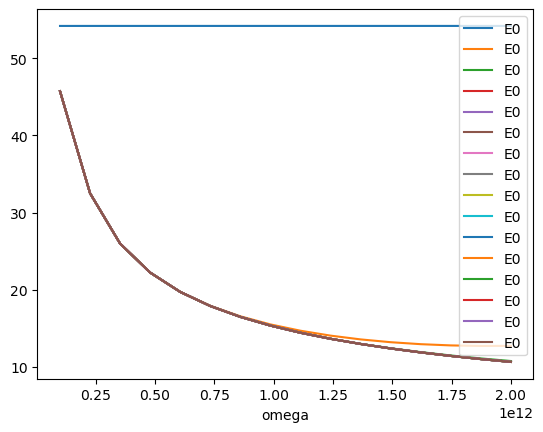

In [25]:
fig,ax = plt.subplots()
for u,g in df.groupby('v'):
    g.plot('omega','E0',ax=ax)
    #ax.plot(g['v']*UNIT_CONVENTION['J to eV'])